# Predicting Flight Delay Duration Using Machine Learning

## 1. Problem Description and Project Objective

Flight delays represent a major operational challenge for airlines, leading to reduced efficiency, increased operational costs, additional crew expenses, and decreased passenger satisfaction. Persistent delays can also negatively affect long-term customer demand and airline reputation.

This project addresses the **Tunisair Flight Delay Prediction Challenge**, which aims to predict the **expected delay duration for individual flights operated by the Tunisian national airline, Tunisair**.

Each record in the dataset corresponds to a single flight instance and contains operational, temporal, geographic, and aircraft-related information. The target variable represents the **delay duration (in minutes)** associated with each flight.

The main objective of this project is to develop a machine learning model capable of accurately estimating flight delays before departure, enabling airlines and airport operators to:

* Improve operational planning and resource allocation
* Anticipate congestion-related disruptions
* Reduce cascading delays across flight schedules
* Enhance passenger experience through better communication and scheduling decisions

To achieve this objective, the project follows a structured pipeline including data exploration, feature engineering, model training, and performance evaluation, with a strong focus on avoiding data leakage and ensuring real-world applicability of the predictive model.

Ultimately, this solution aims to provide actionable insights that support data-driven decision-making within airline operations.


## 2. Technical Setup and Utilities

### 2.1 Imports

In [4]:
# ============================================================
# 📦 Core Scientific Stack
# ============================================================
import numpy as np
import pandas as pd

# ============================================================
# 📊 Visualization
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# 📐 Statistics & Analysis Support
# ============================================================
import scipy.stats as stats
import statsmodels.api as sm

# ============================================================
# 🤖 Machine Learning — Data Splitting & Validation
# ============================================================
from sklearn.model_selection import (
    train_test_split,
    KFold,
    StratifiedKFold,
    cross_val_score,
    cross_validate,
    GridSearchCV
)

# ============================================================
# 🧱 Preprocessing & Pipelines
# ============================================================
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    StandardScaler,
    RobustScaler,
    OneHotEncoder,
    PolynomialFeatures,
    FunctionTransformer
)
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

# ============================================================
# 📈 Regression Models
# ============================================================
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    RidgeCV,
    Lasso,
    LassoCV,
    ElasticNet,
    ElasticNetCV
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor
)
from sklearn.svm import SVR
from xgboost import XGBRegressor

# ============================================================
# ⚖️ Classification Models
# ============================================================
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier
)
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier

# ============================================================
# ⚡ Imbalanced Learning
# ============================================================
#from imblearn.over_sampling import SMOTE
#from imblearn.pipeline import Pipeline as ImbPipeline

# ============================================================
# 📏 Evaluation Metrics — Regression
# ============================================================
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score
)

# ============================================================
# 📏 Evaluation Metrics — Classification
# ============================================================
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# ============================================================
# 🔍 Model Inspection & Interpretation
# ============================================================
from sklearn.inspection import (
    permutation_importance,
    PartialDependenceDisplay
)

# ============================================================
# 🚨 Anomaly Detection (EDA / Preprocessing)
# ============================================================
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# ============================================================
# 🛠 Utilities & Configuration
# ============================================================
import os
import re
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

# ============================================================
# 🎨 Project Styling & Reproducibility
# ============================================================
MAIN_COLOR = "#B388EB"
RANDOM_STATE = 1234


### 2.2  IQR-Based Outlier Handling Utilities

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

class IQRCapper(BaseEstimator, TransformerMixin):
    def __init__(self, k=1.5):
        self.k = k

    def fit(self, X, y=None):
        # Ensure DataFrame for column-wise operations
        X = pd.DataFrame(X)

        q1 = X.quantile(0.25)
        q3 = X.quantile(0.75)
        iqr = q3 - q1

        self.lower_bounds_ = q1 - self.k * iqr
        self.upper_bounds_ = q3 + self.k * iqr

        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()

        for col in X.columns:
            X[col] = X[col].clip(
                lower=self.lower_bounds_[col],
                upper=self.upper_bounds_[col]
            )

        return X

### 2.4 Model Evaluation Utilities

In [6]:

RANDOM_STATE = 0

def metric_report(y_true, y_pred, y_proba=None, label="model"):
    # Basic metrics
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)

    # Specificity (True Negative Rate)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    # ROC-AUC (if probabilities are provided)
    roc = roc_auc_score(y_true, y_proba) if y_proba is not None else None

    # PR-AUC
    if y_proba is not None:
        prec_curve, rec_curve, _ = precision_recall_curve(y_true, y_proba)
        pr_auc = auc(rec_curve, prec_curve)
    else:
        pr_auc = None

    out = {
        "model": label,
        "accuracy": acc,
        "precision": prec,
        "specificity": spec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc,
        "pr_auc": pr_auc
    }
    return out

def plot_roc_pr(y_true, y_score, title_prefix=""):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    rocA = auc(fpr, tpr)
    prec, rec, _ = precision_recall_curve(y_true, y_score)
    prA = auc(rec, prec)

    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={rocA:.3f}")
    plt.plot([0,1],[0,1],"--")
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"{title_prefix} ROC"); plt.legend()
    plt.show()

    plt.figure()
    plt.plot(rec, prec, label=f"AP={prA:.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"{title_prefix} Precision-Recall"); plt.legend()
    plt.show()

def show_confusion(y_true, y_pred, title="Confusion Matrix"):
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
    plt.title(title); plt.show()

### 2.3 Threshold Optimization Utilities

In [7]:
# ============================================
# Threshold Optimization Tools (Steps A–C)
# ============================================

# =====================
# Step A — Threshold sweep
# =====================
def threshold_sweep(y_true, y_score, thresholds=None):
    """
    Sweep thresholds and compute metrics using metric_report.
    """
    if thresholds is None:
        thresholds = np.linspace(0.01, 0.99, 99)

    rows = []
    for t in thresholds:
        y_pred = (y_score >= t).astype(int)
        m = metric_report(y_true, y_pred, y_score, label=f"t={t:.3f}")

        rows.append({
            "threshold": t,
            "accuracy":   m["accuracy"],
            "precision":  m["precision"],
            "specificity": m["specificity"],
            "recall":     m["recall"],
            "f1":         m["f1"],
            "roc_auc":    m["roc_auc"],
            "pr_auc":     m["pr_auc"],
        })
    return pd.DataFrame(rows)


# =====================
# Step B — Choose threshold by objective
# =====================
def choose_threshold_by_objective(sweep_df, objective="f1_max", target=0.8):

    if objective == "f1_max":
        i = sweep_df["f1"].idxmax()
        return float(sweep_df.loc[i, "threshold"]), "F1-max"

    if objective == "precision_at":
        df = sweep_df[sweep_df["precision"] >= target]
        if len(df) == 0:
            return float(sweep_df.iloc[-1]["threshold"]), f"precision_at({target}) — best available"
        i = df["recall"].idxmax()
        return float(df.loc[i, "threshold"]), f"precision≥{target}, max recall"

    if objective == "recall_at":
        df = sweep_df[sweep_df["recall"] >= target]
        if len(df) == 0:
            return float(sweep_df.iloc[-1]["threshold"]), f"recall_at({target}) — best available"
        i = df["precision"].idxmax()
        return float(df.loc[i, "threshold"]), f"recall≥{target}, max precision"

    raise ValueError("Unknown objective")


# =====================
# Step C — Evaluate model at chosen threshold
# =====================
#def show_at_threshold(y_true, y_score, t, label=""):
#   y_pred = (y_score >= t).astype(int)
#    show_confusion(y_true, y_pred, f"{label} (t={t:.2f})")
#    return metric_report(y_true, y_pred, y_score, f"{label} (t={t:.2f})")

# ============================================
def show_at_threshold(y_true, y_score, t, label="", ax=None):
    y_pred = (y_score >= t).astype(int)

    cm = confusion_matrix(y_true, y_pred)

    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))

    ax.imshow(cm, vmin=0, vmax=1)

    green_pastel = "#C2E7C4"
    red_pastel   = "#F0C6C3"

    for i in range(2):
        for j in range(2):
            ax.add_patch(
                plt.Rectangle(
                    (j - 0.5, i - 0.5),
                    1, 1,
                    facecolor=green_pastel if i == j else red_pastel,
                    edgecolor="white"
                )
            )
            ax.text(
                j, i,
                f"{cm[i, j]:.0f}",
                ha="center", va="center",
                fontsize=11,
                color="black"
            )

    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["Pred 0", "Pred 1"], fontsize=9)
    ax.set_yticklabels(["True 0", "True 1"], fontsize=9)

    ax.set_title(f"{label}\n(t = {t:.2f})", fontsize=10)
    ax.set_xlim(-0.5, 1.5)
    ax.set_ylim(1.5, -0.5)

    if ax is None:
        plt.tight_layout()
        plt.show()

    return metric_report(y_true, y_pred, y_score, f"{label} (t={t:.2f})")



## 3. Data Loading & Initial Exploration

### 3.1 Load Raw Datasets

In [8]:
# ----------------------------
# Load datasets
# ----------------------------

train_path = "../data/Zindi/Train.csv"
test_path = "../data/Zindi/Test.csv"

airports_path = "../data/airportsdata/airports.csv"
iata_macs_path = "../data/airportsdata/iata_macs.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

airports_df = pd.read_csv(airports_path)
iata_macs_df = pd.read_csv(iata_macs_path)


### 3.2 Basic Dataset Inspection

In [9]:

# ----------------------------
# Basic inspection
# ----------------------------

print("=== TRAIN ===")
print(train_df.shape)
display(train_df.info())
display(train_df.head())

print("\n=== TEST ===")
print(test_df.shape)
display(test_df.info())
display(test_df.head())

print("\n=== AIRPORTS ===")
print(airports_df.shape)
display(airports_df.info()) 
display(airports_df.head())

print("\n=== IATA MACS ===")
print(iata_macs_df.shape)
display(iata_macs_df.info())
display(iata_macs_df.head())


# ----------------------------
# Column overview
# ----------------------------

print("\nTrain columns:\n", train_df.columns.tolist())
print("\nTrain columns:\n", test_df.columns.tolist())
print("\nAirports columns:\n", airports_df.columns.tolist())
print("\nIATA MACS columns:\n", iata_macs_df.columns.tolist())


=== TRAIN ===
(107833, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107833 entries, 0 to 107832
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      107833 non-null  object 
 1   DATOP   107833 non-null  object 
 2   FLTID   107833 non-null  object 
 3   DEPSTN  107833 non-null  object 
 4   ARRSTN  107833 non-null  object 
 5   STD     107833 non-null  object 
 6   STA     107833 non-null  object 
 7   STATUS  107833 non-null  object 
 8   AC      107833 non-null  object 
 9   target  107833 non-null  float64
dtypes: float64(1), object(9)
memory usage: 8.2+ MB


None

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12.55.00,ATA,TU 32AIMN,260.0
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16.55.00,ATA,TU 31BIMO,20.0
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06.45.00,ATA,TU 32AIMN,0.0
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17.00.00,ATA,TU 736IOK,0.0
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15.50.00,ATA,TU 320IMU,22.0



=== TEST ===
(9333, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9333 entries, 0 to 9332
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      9333 non-null   object
 1   DATOP   9333 non-null   object
 2   FLTID   9333 non-null   object
 3   DEPSTN  9333 non-null   object
 4   ARRSTN  9333 non-null   object
 5   STD     9333 non-null   object
 6   STA     9333 non-null   object
 7   STATUS  9333 non-null   object
 8   AC      9333 non-null   object
dtypes: object(9)
memory usage: 656.4+ KB


None

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC
0,test_id_0,2016-05-04,TU 0700,DJE,TUN,2016-05-04 06:40:00,2016-05-04 07.30.00,ATA,TU 32AIMF
1,test_id_1,2016-05-05,TU 0395,TUN,BKO,2016-05-05 15:20:00,2016-05-05 20.05.00,ATA,TU 320IMW
2,test_id_2,2016-05-06,TU 0745,FRA,TUN,2016-05-06 10:00:00,2016-05-06 12.25.00,ATA,TU 32AIMC
3,test_id_3,2016-05-11,TU 0848,BEY,TUN,2016-05-11 09:40:00,2016-05-11 13.10.00,ATA,TU 31BIMO
4,test_id_4,2016-05-11,TU 0635,ORY,MIR,2016-05-11 09:50:00,2016-05-11 12.35.00,ATA,TU 736IOQ



=== AIRPORTS ===
(28270, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28270 entries, 0 to 28269
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   icao       28270 non-null  object 
 1   iata       7859 non-null   object 
 2   name       28270 non-null  object 
 3   city       25440 non-null  object 
 4   subd       27497 non-null  object 
 5   country    28207 non-null  object 
 6   elevation  28270 non-null  float64
 7   lat        28270 non-null  float64
 8   lon        28270 non-null  float64
 9   tz         28270 non-null  object 
 10  lid        12610 non-null  object 
dtypes: float64(3), object(8)
memory usage: 2.4+ MB


None

,icao,iata,name,city,subd,country,elevation,lat,lon,tz,lid
0,00AA,NaN,Aero B Ranch Airport,Leoti,Kansas,US,3435.0,38.70402,-101.47391,America/Chicago,00AA
1,00AK,NaN,Lowell Field,Anchor Point,Alaska,US,252.0,59.94889,-151.69222,America/Anchorage,00AK
2,00AL,NaN,Epps Airpark,Harvest,Alabama,US,820.0,34.86481,-86.77028,America/Chicago,00AL
3,00AN,NaN,Katmai Lodge Airport,King Salmon,Alaska,US,80.0,59.09347,-156.45583,America/Anchorage,00AN
4,00AR,NaN,Arland Airport,Bennington,Kansas,US,1352.0,38.96965,-97.60156,America/Chicago,00AR



=== IATA MACS ===
(89, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Country       89 non-null     object
 1   City Code     89 non-null     object
 2   City Name     89 non-null     object
 3   Airport Code  89 non-null     object
 4   Airport Name  89 non-null     object
dtypes: object(5)
memory usage: 3.6+ KB


None

,Country,City Code,City Name,Airport Code,Airport Name
0,AE,DXB,Dubai,DWC,Al Maktoum Intl
1,AE,DXB,Dubai,DXB,International
2,AR,BUE,Buenos Aires,AEP,Jorge Newbery
3,AR,BUE,Buenos Aires,EZE,Ministro Pistarini
4,AU,MEL,Melbourne,AVV,Avalon



Train columns:
 ['ID', 'DATOP', 'FLTID', 'DEPSTN', 'ARRSTN', 'STD', 'STA', 'STATUS', 'AC', 'target']

Train columns:
 ['ID', 'DATOP', 'FLTID', 'DEPSTN', 'ARRSTN', 'STD', 'STA', 'STATUS', 'AC']

Airports columns:
 ['icao', 'iata', 'name', 'city', 'subd', 'country', 'elevation', 'lat', 'lon', 'tz', 'lid']

IATA MACS columns:
 ['Country', 'City Code', 'City Name', 'Airport Code', 'Airport Name']


### 3.3 Unique Values & Airport Code Exploration

In [10]:
# ----------------------------
# Unique values in flight data
# ----------------------------

print("Unique DEPSTN airports:", train_df["DEPSTN"].nunique())
print("Unique ARRSTN airports:", train_df["ARRSTN"].nunique())

print("\nSample DEPSTN values:")
print(train_df["DEPSTN"].value_counts().head(10))

print("\nSample ARRSTN values:")
print(train_df["ARRSTN"].value_counts().head(10))


Unique DEPSTN airports: 132
Unique ARRSTN airports: 128

Sample DEPSTN values:
DEPSTN
TUN    42522
DJE    10252
ORY     6755
MIR     5248
MRS     2845
LYS     2358
NCE     2227
ALG     1573
MXP     1534
IST     1442
Name: count, dtype: int64

Sample ARRSTN values:
ARRSTN
TUN    42572
DJE    10198
ORY     6755
MIR     5251
MRS     2845
LYS     2359
NCE     2228
ALG     1573
MXP     1534
IST     1442
Name: count, dtype: int64


In [11]:
# ----------------------------
# Unique IATA airports
# ----------------------------

print("Unique IATA airports in airports dataset:", airports_df["iata"].nunique())

print("\nSample IATA values:")
print(airports_df["iata"].value_counts().head(10))


Unique IATA airports in airports dataset: 7859

Sample IATA values:
iata
OCA    1
SGL    1
MNL    1
DRP    1
LAO    1
CRK    1
SFS    1
ENI    1
OGN    1
RNJ    1
Name: count, dtype: int64


In [12]:
# ----------------------------
# Inspect Airport Code in iata_macs
# ----------------------------

print("Unique Airport Codes in iata_macs:",
      iata_macs_df["Airport Code"].nunique())

print("\nSample Airport Codes from iata_macs:")
print(iata_macs_df["Airport Code"].value_counts().head(10))


Unique Airport Codes in iata_macs: 89

Sample Airport Codes from iata_macs:
Airport Code
DWC    1
NGO    1
DKR    1
BMA    1
ARN    1
VKO    1
SVO    1
DME    1
TRF    1
OSL    1
Name: count, dtype: int64


### 3.4 Dataset Relationship & Join Feasibility Check

In [13]:
# ----------------------------
# Check matching coverage
# ----------------------------

dep_not_found = set(train_df["DEPSTN"]) - set(airports_df["iata"])
arr_not_found = set(train_df["ARRSTN"]) - set(airports_df["iata"])

print("DEPSTN not found in airports IATA:", len(dep_not_found))
print("ARRSTN not found in airports IATA:", len(arr_not_found))

print("\nSample missing DEPSTN:", list(dep_not_found)[:10])
print("Sample missing ARRSTN:", list(arr_not_found)[:10])

# ----------------------------
# Check matching coverage (TEST)
# ----------------------------

dep_not_found_test = set(test_df["DEPSTN"]) - set(airports_df["iata"])
arr_not_found_test = set(test_df["ARRSTN"]) - set(airports_df["iata"])

print("\n\nTEST DEPSTN not found in airports IATA:", len(dep_not_found_test))
print("TEST ARRSTN not found in airports IATA:", len(arr_not_found_test))

print("\nSample missing TEST DEPSTN:", list(dep_not_found_test)[:10])
print("Sample missing TEST ARRSTN:", list(arr_not_found_test)[:10])

DEPSTN not found in airports IATA: 1
ARRSTN not found in airports IATA: 1

Sample missing DEPSTN: ['SXF']
Sample missing ARRSTN: ['SXF']


TEST DEPSTN not found in airports IATA: 1
TEST ARRSTN not found in airports IATA: 1

Sample missing TEST DEPSTN: ['SXF']
Sample missing TEST ARRSTN: ['SXF']


In [14]:
dep_not_in_macs = set(train_df["DEPSTN"]) - set(iata_macs_df["Airport Code"])

print("DEPSTN not found in iata_macs:", len(dep_not_in_macs))
print("Sample missing DEPSTN:", list(dep_not_in_macs)[:10])


arr_not_in_macs = set(train_df["ARRSTN"]) - set(iata_macs_df["Airport Code"])

print("ARRSTN not found in iata_macs:", len(arr_not_in_macs))
print("Sample missing ARRSTN:", list(arr_not_in_macs)[:10])


DEPSTN not found in iata_macs: 114
Sample missing DEPSTN: ['KSC', 'SKX', 'CMN', 'CKY', 'NTE', 'GHA', 'NKC', 'TNG', 'VCE', 'VIE']
ARRSTN not found in iata_macs: 110
Sample missing ARRSTN: ['KSC', 'SKX', 'CMN', 'CKY', 'NTE', 'GHA', 'NKC', 'TNG', 'VCE', 'VIE']


🔍 Observation: Airport Code Coverage

The airports.csv dataset provides almost full coverage for the flight dataset. Only one airport code (SXF) from both DEPSTN and ARRSTN was not found in the airports IATA list.

In contrast, the iata_macs.csv dataset shows very low coverage. More than 110 airport codes from the flight dataset are missing in this file. This indicates that iata_macs is mainly designed for city-to-airport mapping and is not suitable for enriching airport-level features.

Therefore, airports.csv is selected as the main source for joining airport information, while iata_macs.csv will not be used in the modeling pipeline.

### 3.5 Handling Missing Airport Code (SXF)

The airport code SXF (Berlin Schönefeld Airport) appears in the flight dataset but is missing from the airports reference dataset. This is expected because SXF was closed and merged into BER (Berlin Brandenburg Airport) in recent airport databases.

Since both airports are located in the same metropolitan area and have very similar geographic properties, SXF is manually mapped to BER prior to performing the airport join. This approach avoids data loss and ensures consistent geographic feature enrichment.

In [15]:
# ----------------------------
# Manual mapping: SXF -> BER
# ----------------------------

train_df["DEPSTN"] = train_df["DEPSTN"].replace("SXF", "BER")
train_df["ARRSTN"] = train_df["ARRSTN"].replace("SXF", "BER")

test_df["DEPSTN"] = test_df["DEPSTN"].replace("SXF", "BER")
test_df["ARRSTN"] = test_df["ARRSTN"].replace("SXF", "BER")


Airport code normalization (SXF → BER) was applied prior to the merge operation to ensure consistent key matching and prevent missing geographic attributes during dataset enrichment.

### 3.6 Airport Data Enrichment (Departure & Arrival Join)

In this step, airport-level geographic and contextual information is merged into the flight dataset.
The airports reference dataset is joined twice:

Once for the departure airport (DEPSTN)

Once for the arrival airport (ARRSTN)

This allows adding location-based features such as latitude, longitude, elevation, country, and timezone for both origin and destination airports.

In [16]:
# ----------------------------
# Prepare airport reference tables
# ----------------------------

dep_airports = airports_df.add_prefix("dep_")
arr_airports = airports_df.add_prefix("arr_")


# ----------------------------
# Merge departure airport info
# ----------------------------

train_df = train_df.merge(
    dep_airports,
    how="left",
    left_on="DEPSTN",
    right_on="dep_iata"
)

test_df = test_df.merge(
    dep_airports,
    how="left",
    left_on="DEPSTN",
    right_on="dep_iata"
)


# ----------------------------
# Merge arrival airport info
# ----------------------------

train_df = train_df.merge(
    arr_airports,
    how="left",
    left_on="ARRSTN",
    right_on="arr_iata"
)

test_df = test_df.merge(
    arr_airports,
    how="left",
    left_on="ARRSTN",
    right_on="arr_iata"
)


In [17]:
train_df.columns

Index(['ID', 'DATOP', 'FLTID', 'DEPSTN', 'ARRSTN', 'STD', 'STA', 'STATUS',
       'AC', 'target', 'dep_icao', 'dep_iata', 'dep_name', 'dep_city',
       'dep_subd', 'dep_country', 'dep_elevation', 'dep_lat', 'dep_lon',
       'dep_tz', 'dep_lid', 'arr_icao', 'arr_iata', 'arr_name', 'arr_city',
       'arr_subd', 'arr_country', 'arr_elevation', 'arr_lat', 'arr_lon',
       'arr_tz', 'arr_lid'],
      dtype='object')

In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107833 entries, 0 to 107832
Data columns (total 32 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ID             107833 non-null  object 
 1   DATOP          107833 non-null  object 
 2   FLTID          107833 non-null  object 
 3   DEPSTN         107833 non-null  object 
 4   ARRSTN         107833 non-null  object 
 5   STD            107833 non-null  object 
 6   STA            107833 non-null  object 
 7   STATUS         107833 non-null  object 
 8   AC             107833 non-null  object 
 9   target         107833 non-null  float64
 10  dep_icao       107833 non-null  object 
 11  dep_iata       107833 non-null  object 
 12  dep_name       107833 non-null  object 
 13  dep_city       107833 non-null  object 
 14  dep_subd       105783 non-null  object 
 15  dep_country    107833 non-null  object 
 16  dep_elevation  107833 non-null  float64
 17  dep_lat        107833 non-nul

In [19]:
train_df.head()
train_df.columns

Index(['ID', 'DATOP', 'FLTID', 'DEPSTN', 'ARRSTN', 'STD', 'STA', 'STATUS',
       'AC', 'target', 'dep_icao', 'dep_iata', 'dep_name', 'dep_city',
       'dep_subd', 'dep_country', 'dep_elevation', 'dep_lat', 'dep_lon',
       'dep_tz', 'dep_lid', 'arr_icao', 'arr_iata', 'arr_name', 'arr_city',
       'arr_subd', 'arr_country', 'arr_elevation', 'arr_lat', 'arr_lon',
       'arr_tz', 'arr_lid'],
      dtype='object')

### 3.7 Post-Join Missing Value Check (Airport Features)

This step verifies whether airport information was successfully merged for both departure and arrival airports.
Missing values are inspected to ensure that the join operation produced complete geographic feature coverage.

In [20]:
# ----------------------------
# Check missing values after airport join
# ----------------------------

airport_feature_cols = [
    "dep_lat", "dep_lon", "dep_country", "dep_tz", "dep_elevation",
    "arr_lat", "arr_lon", "arr_country", "arr_tz", "arr_elevation"
]

print("Missing values in TRAIN (airport features):")
print(train_df[airport_feature_cols].isna().sum())

print("\nMissing values in TEST (airport features):")
print(test_df[airport_feature_cols].isna().sum())


Missing values in TRAIN (airport features):
dep_lat          0
dep_lon          0
dep_country      0
dep_tz           0
dep_elevation    0
arr_lat          0
arr_lon          0
arr_country      0
arr_tz           0
arr_elevation    0
dtype: int64

Missing values in TEST (airport features):
dep_lat          0
dep_lon          0
dep_country      0
dep_tz           0
dep_elevation    0
arr_lat          0
arr_lon          0
arr_country      0
arr_tz           0
arr_elevation    0
dtype: int64


## 4. Train / Validation Split

### 4.1 Validation Strategy Justification and Data Leakage Considerations

Although flight delay prediction problems are often treated as time-series forecasting tasks, this project is formulated as a standard tabular regression problem.

The model exclusively relies on calendar-based features such as departure time, day of the week, and month of the flight. It does not use historical delay information or lag-based features to predict future delays. As a result, individual flight observations are considered independent, and no temporal dependency between records is assumed.

Furthermore, the competition test set temporally overlaps with the training data period, indicating that the evaluation setup does not represent a strict future forecasting scenario.

Based on these considerations, a random train-validation split (or standard cross-validation) is used throughout the modeling process. This approach avoids data leakage, aligns with the competition setup, and provides a reliable estimate of model generalization performance.

### 4.2 Train / Validation Split

In [21]:
from sklearn.model_selection import train_test_split

# Separate target
y = train_df["target"]
X = train_df.drop(columns=["target"])

# Train / Validation split (random)
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

# Recombine for convenience
train_df_eda = X_train.copy()
train_df_eda["target"] = y_train

val_df = X_val.copy()
val_df["target"] = y_val

train_df.shape, train_df_eda.shape,val_df.shape , X_train.shape, X_val.shape, y_train.shape, y_val.shape
#train_df_eda.columns
#X_train.columns

((107833, 32),
 (86266, 32),
 (21567, 32),
 (86266, 31),
 (21567, 31),
 (86266,),
 (21567,))

## 5. Exploratory Data Analysis (EDA)

### 5.1 Missing Data Overview

In [22]:
# ----------------------------
# Missing values per column
# ----------------------------

missing_counts = train_df_eda.isna().sum()
missing_percent = (train_df_eda.isna().mean() * 100).round(2)

missing_summary = pd.DataFrame({
    "missing_count": missing_counts,
    "missing_percent": missing_percent
}).sort_values(by="missing_percent", ascending=False)

display(missing_summary)


,missing_count,missing_percent
arr_lid,86266,100.00
dep_lid,86266,100.00
arr_subd,1629,1.89
dep_subd,1596,1.85
ID,0,0.00
dep_lon,0,0.00
arr_tz,0,0.00
arr_lon,0,0.00
arr_lat,0,0.00
arr_elevation,0,0.00


**Missing Airport Metadata Observation**

The columns dep_lid and arr_lid contain 100% missing values. These fields represent FAA internal location identifiers, which are only applicable to a limited subset of US airports and are not relevant for a global flight dataset. Therefore, these columns will be removed during the data cleaning stage.

A small fraction of missing values (~1.9%) is observed in the dep_subd and arr_subd columns, which correspond to administrative subdivisions. This is expected for certain countries where subdivision data is not available.

### 5.2 Data Types Overview

In [23]:
# ----------------------------
# Data types summary table
# ----------------------------

dtype_summary = pd.DataFrame({
    "column": train_df_eda.columns,
    "dtype": train_df_eda.dtypes.values
})

display(dtype_summary)


,column,dtype
0,ID,object
1,DATOP,object
2,FLTID,object
3,DEPSTN,object
4,ARRSTN,object
5,STD,object
6,STA,object
7,STATUS,object
8,AC,object
9,dep_icao,object


**Data Type Inspection Summary**

The target variable is correctly stored as a numerical feature (float64), confirming the regression formulation of the problem.

Geographic attributes such as latitude, longitude, and elevation for both departure and arrival airports are stored as numeric values and are ready for modeling.

Date and time-related columns (DATOP, STD, STA) are currently stored as object types and will be converted to appropriate datetime representations during the preprocessing stage.

Categorical attributes (airport codes, aircraft type, country, timezone, and status) are represented as object types and will be handled during feature encoding.

The columns dep_lid and arr_lid contain only missing values and will be removed in the data cleaning phase.

### 5.3 Duplicate Record Check

In [24]:
# ----------------------------
# Check full row duplicates
# ----------------------------

total_duplicates = train_df_eda.duplicated().sum()
print("Total duplicated rows:", total_duplicates)


Total duplicated rows: 0


In [25]:
# ----------------------------
# Check duplicate IDs
# ----------------------------

duplicate_ids = train_df_eda["ID"].duplicated().sum()
print("Duplicate IDs:", duplicate_ids)


Duplicate IDs: 0


In [26]:
# ----------------------------
# Logical duplicate check (flight + date)
# ----------------------------

logical_duplicates = train_df_eda.duplicated(subset=["FLTID", "DATOP"]).sum()
print("Duplicate FLTID + DATOP:", logical_duplicates)


Duplicate FLTID + DATOP: 5812


In [27]:
true_duplicates = train_df_eda.duplicated(
    subset=["FLTID", "DATOP", "DEPSTN", "ARRSTN"]
).sum()

print("True route-level duplicates:", true_duplicates)


True route-level duplicates: 1344


In [28]:
route_dup_mask = train_df_eda.duplicated(
    subset=["FLTID", "DATOP", "DEPSTN", "ARRSTN"],
    keep=False
)

route_dups = train_df_eda[route_dup_mask]

print(route_dups.shape)


(2181, 32)


In [29]:
route_dups_sorted = route_dups.sort_values(
    by=["FLTID", "DATOP", "DEPSTN", "ARRSTN"]
)

route_dups_sorted.head(10)


,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,dep_icao,...,arr_name,arr_city,arr_subd,arr_country,arr_elevation,arr_lat,arr_lon,arr_tz,arr_lid,target
68174,train_id_68174,2017-04-25,A 0000,TUN,TUN,2017-04-25 20:00:00,2017-04-26 23.59.00,SCH,TU 32AIMG,DTTA,...,Tunis Carthage International Airport,Tunis,Tunis,TN,22.0,36.851,10.2272,Africa/Tunis,NaN,0.0
67845,train_id_67845,2017-04-25,A 0000,TUN,TUN,2017-04-25 07:00:00,2017-04-25 21.00.00,SCH,TU 320IMT,DTTA,...,Tunis Carthage International Airport,Tunis,Tunis,TN,22.0,36.851,10.2272,Africa/Tunis,NaN,0.0
66857,train_id_66857,2017-06-19,A 0000,TUN,TUN,2017-06-19 21:00:00,2017-06-20 05.00.00,SCH,TU 32AIMM,DTTA,...,Tunis Carthage International Airport,Tunis,Tunis,TN,22.0,36.851,10.2272,Africa/Tunis,NaN,0.0
66558,train_id_66558,2017-06-19,A 0000,TUN,TUN,2017-06-19 05:00:00,2017-06-19 15.00.00,SCH,TU 332IFN,DTTA,...,Tunis Carthage International Airport,Tunis,Tunis,TN,22.0,36.851,10.2272,Africa/Tunis,NaN,0.0
67987,train_id_67987,2017-07-19,A 0000,TUN,TUN,2017-07-19 21:00:00,2017-07-20 04.00.00,SCH,TU 32AIML,DTTA,...,Tunis Carthage International Airport,Tunis,Tunis,TN,22.0,36.851,10.2272,Africa/Tunis,NaN,0.0
68759,train_id_68759,2017-07-19,A 0000,TUN,TUN,2017-07-19 06:00:00,2017-07-19 13.30.00,SCH,TU 320IMR,DTTA,...,Tunis Carthage International Airport,Tunis,Tunis,TN,22.0,36.851,10.2272,Africa/Tunis,NaN,0.0
105694,train_id_105694,2018-05-23,A 0000,TUN,TUN,2018-05-23 21:00:00,2018-05-26 04.45.00,SCH,TU 332IFN,DTTA,...,Tunis Carthage International Airport,Tunis,Tunis,TN,22.0,36.851,10.2272,Africa/Tunis,NaN,0.0
106250,train_id_106250,2018-05-23,A 0000,TUN,TUN,2018-05-23 21:00:00,2018-05-25 13.00.00,SCH,TU 320IMW,DTTA,...,Tunis Carthage International Airport,Tunis,Tunis,TN,22.0,36.851,10.2272,Africa/Tunis,NaN,0.0
107154,train_id_107154,2018-05-28,A 0000,TUN,TUN,2018-05-28 21:00:00,2018-05-30 04.00.00,SCH,TU 736IOK,DTTA,...,Tunis Carthage International Airport,Tunis,Tunis,TN,22.0,36.851,10.2272,Africa/Tunis,NaN,0.0
105240,train_id_105240,2018-05-28,A 0000,TUN,TUN,2018-05-28 07:00:00,2018-05-30 13.30.00,SCH,TU 332IFM,DTTA,...,Tunis Carthage International Airport,Tunis,Tunis,TN,22.0,36.851,10.2272,Africa/Tunis,NaN,0.0


**Interpretation of Route-Level Duplicate Records**

Inspection of route-level duplicate entries shows that records sharing the same flight number, date, and route often differ in scheduled departure and arrival times as well as aircraft identifiers. This indicates that these entries represent multiple operational flight instances rather than erroneous duplicated records. Therefore, these records are retained in the dataset.

### 5.4 Numerical Feature Distribution and Outlier Analysis

#### 5.4.1 Target Variable

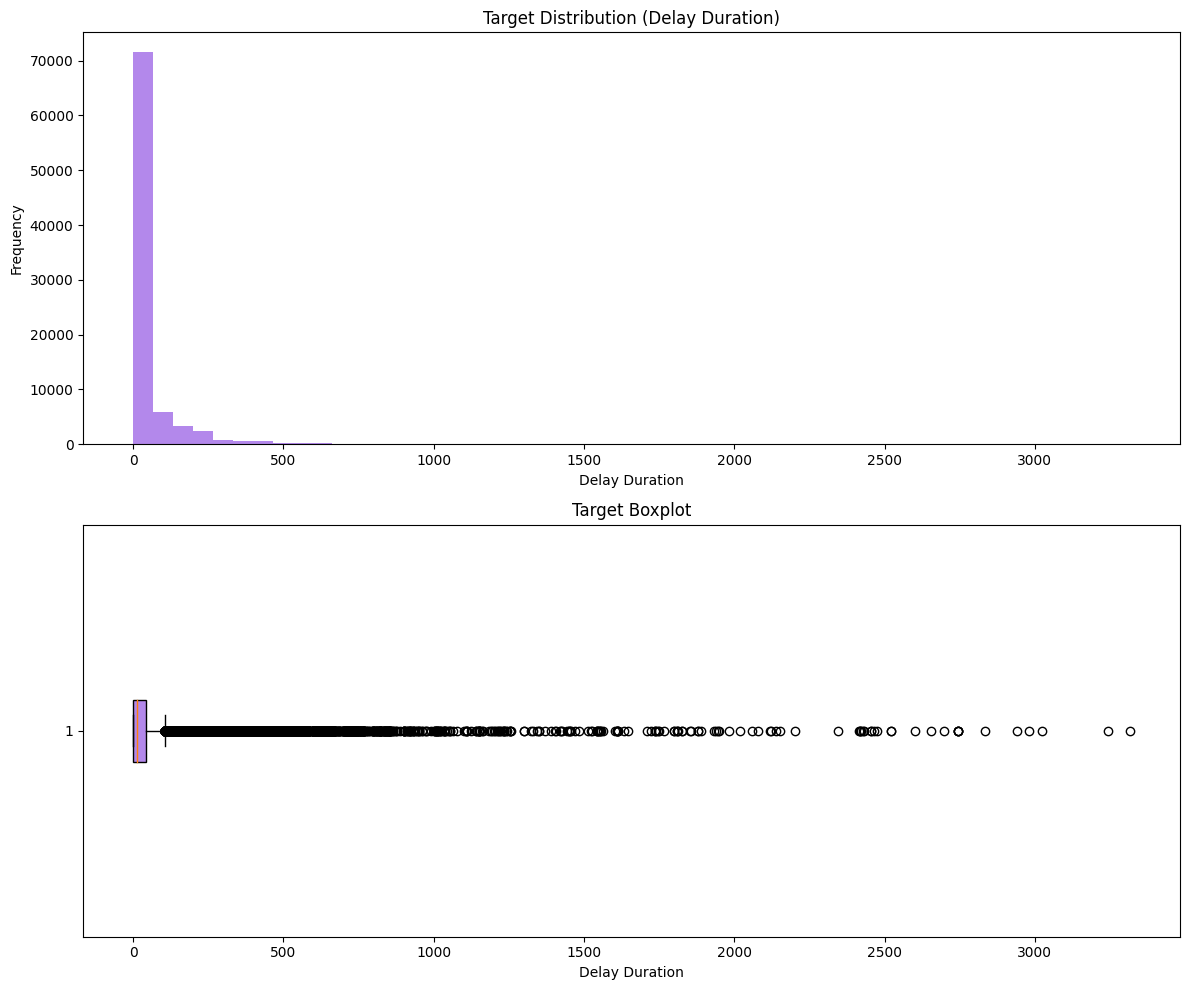

In [30]:
import matplotlib.pyplot as plt

# ----------------------------
# Target distribution and outlier inspection
# ----------------------------

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Histogram
axes[0].hist(train_df_eda["target"], bins=50, color="#B388EB")
axes[0].set_title("Target Distribution (Delay Duration)")
axes[0].set_xlabel("Delay Duration")
axes[0].set_ylabel("Frequency")

# Boxplot
axes[1].boxplot(
    train_df_eda["target"],
    vert=False,
    patch_artist=True,
    boxprops=dict(facecolor="#B388EB")
)
axes[1].set_title("Target Boxplot")
axes[1].set_xlabel("Delay Duration")

plt.tight_layout()
plt.show()


The target variable (delay duration) shows a highly right-skewed distribution.
Most flights have small or zero delays, while a small number of observations have extremely large delay values.
The boxplot confirms the presence of many extreme outliers, indicating a heavy-tailed distribution.
This suggests that outlier handling or transformation may be required before modeling.

In [31]:
# ----------------------------
# Target percentile analysis
# ----------------------------

percentiles = train_df_eda["target"].quantile([0.90, 0.95, 0.99])

percentiles_df = percentiles.reset_index()
percentiles_df.columns = ["percentile", "delay_minutes"]

#percentiles_df

# Print formatted percentile values

for p, v in percentiles.items():
    print(f"{int(p*100)}th percentile: {v:.2f} minutes")



90th percentile: 135.00 minutes
95th percentile: 226.00 minutes
99th percentile: 515.00 minutes


Based on the percentile analysis and the strong right-skewness of the target variable,
two potential strategies can be considered for handling extreme values:
(1) applying an upper cap on large delay values (for example at high percentiles),
or (2) using a logarithmic transformation of the target.
The final decision will be evaluated during the modeling phase.

#### 5.4.2 Airport Elevation

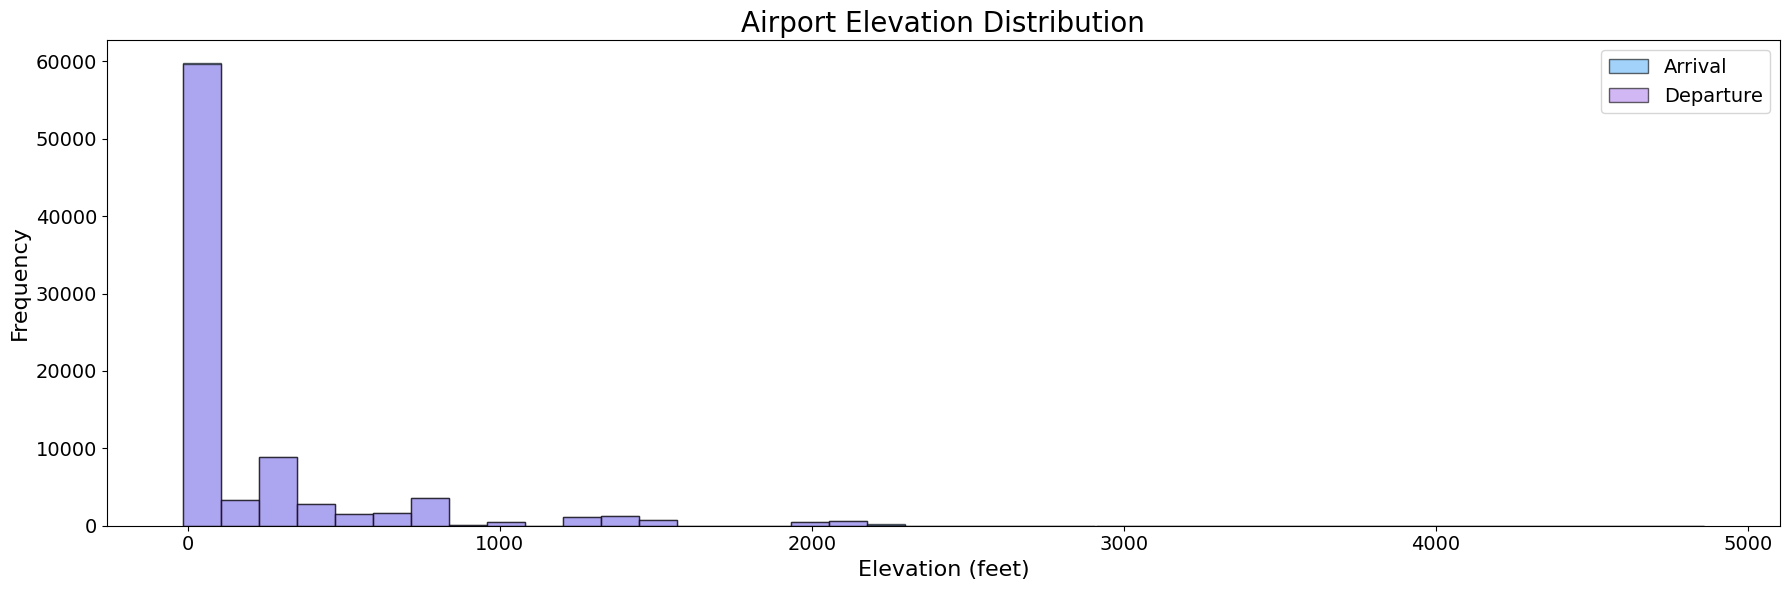

In [32]:
import matplotlib.pyplot as plt

# ----------------------------
# Airport elevation distribution (improved visibility)
# ----------------------------

plt.figure(figsize=(18, 6))

# Arrival first (background)
plt.hist(train_df_eda["arr_elevation"], bins=40,
         label="Arrival",
         color="#64B5F6",
         alpha=0.6,
         edgecolor="black",
         zorder=1)

# Departure on top
plt.hist(train_df_eda["dep_elevation"], bins=40,
         label="Departure",
         color="#B388EB",
         alpha=0.6,
         edgecolor="black",
         zorder=2)

plt.title("Airport Elevation Distribution", fontsize=20)
plt.xlabel("Elevation (feet)", fontsize=16)
plt.ylabel("Frequency", fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=14)

plt.tight_layout()
plt.show()


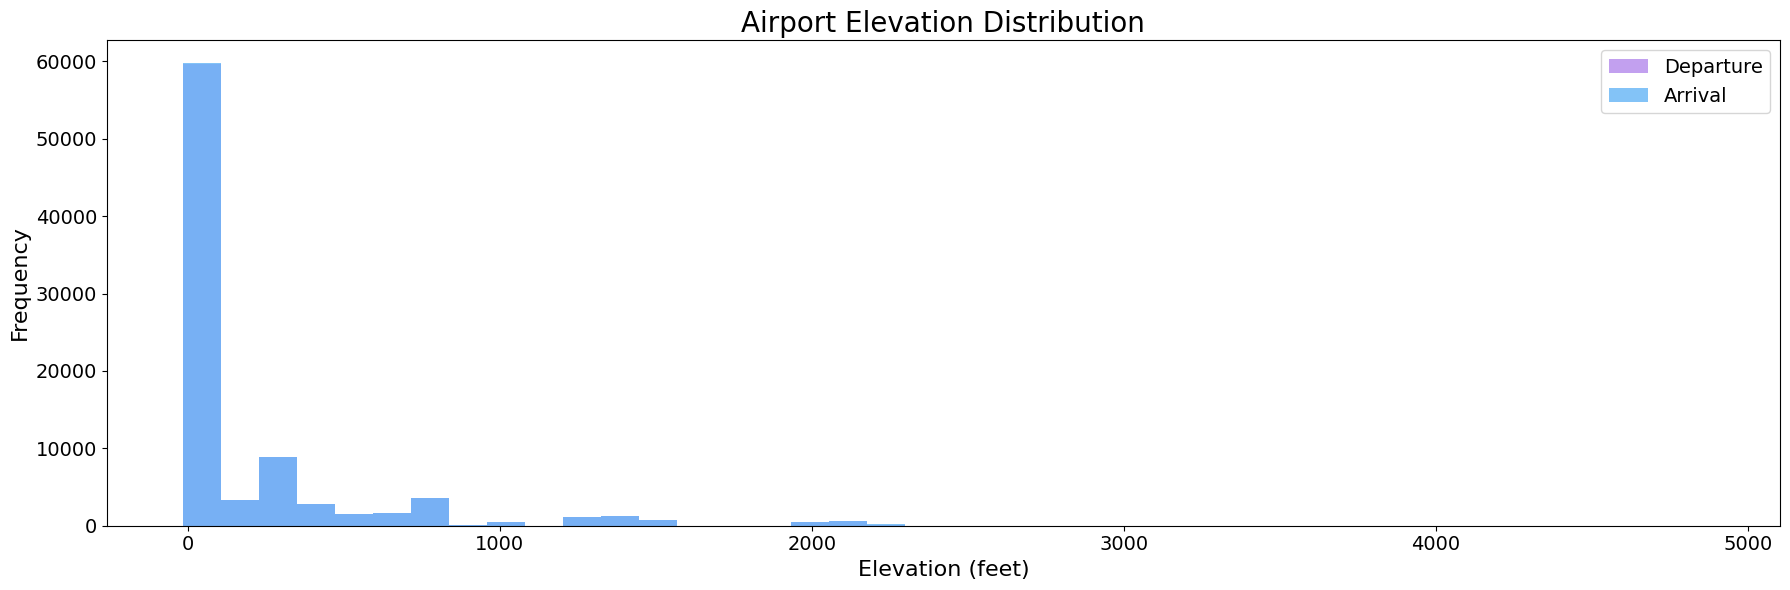

In [33]:
import matplotlib.pyplot as plt

# ----------------------------
# Airport elevation distribution (readable version)
# ----------------------------

plt.figure(figsize=(18, 6))

plt.hist(train_df_eda["dep_elevation"], bins=40,
         label="Departure", color="#B388EB", alpha=0.8)

plt.hist(train_df_eda["arr_elevation"], bins=40,
         label="Arrival", color="#64B5F6", alpha=0.8)

plt.title("Airport Elevation Distribution", fontsize=20)
plt.xlabel("Elevation (feet)", fontsize=16)
plt.ylabel("Frequency", fontsize=16)

#
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=14)

plt.tight_layout()
plt.show()


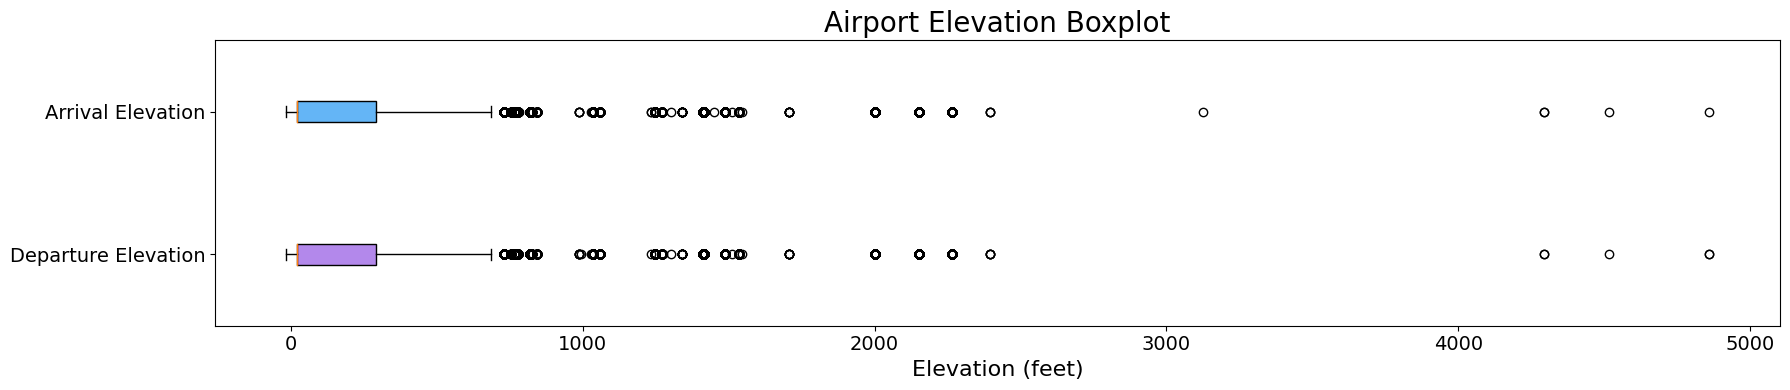

In [34]:
# ----------------------------
# Airport elevation boxplot (two-color version)
# ----------------------------

plt.figure(figsize=(18, 4))

bp = plt.boxplot(
    [train_df_eda["dep_elevation"], train_df_eda["arr_elevation"]],
    vert=False,
    patch_artist=True,
    labels=["Departure Elevation", "Arrival Elevation"]
)

# Set individual box colors
colors = ["#B388EB", "#64B5F6"]  # Purple = Departure, Blue = Arrival

for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)

plt.title("Airport Elevation Boxplot", fontsize=20)
plt.xlabel("Elevation (feet)", fontsize=16)
#plt.xlim(0, 3000)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()


**Observation**

Both departure and arrival airport elevations show a strongly right-skewed distribution.  
The majority of flights operate between low-altitude airports (mostly below 1000 feet),  
while a small number of airports appear at much higher elevations (above 3000–5000 feet),  
creating visible outliers in the boxplot.  

The similarity between departure and arrival elevation distributions indicates that  
flight routes in this dataset are not biased toward systematically higher or lower altitude airports.


#### 5.4.3 Geographic Coordinates

✅ Code Cell 1 — Latitude Distribution (Departure vs Arrival)

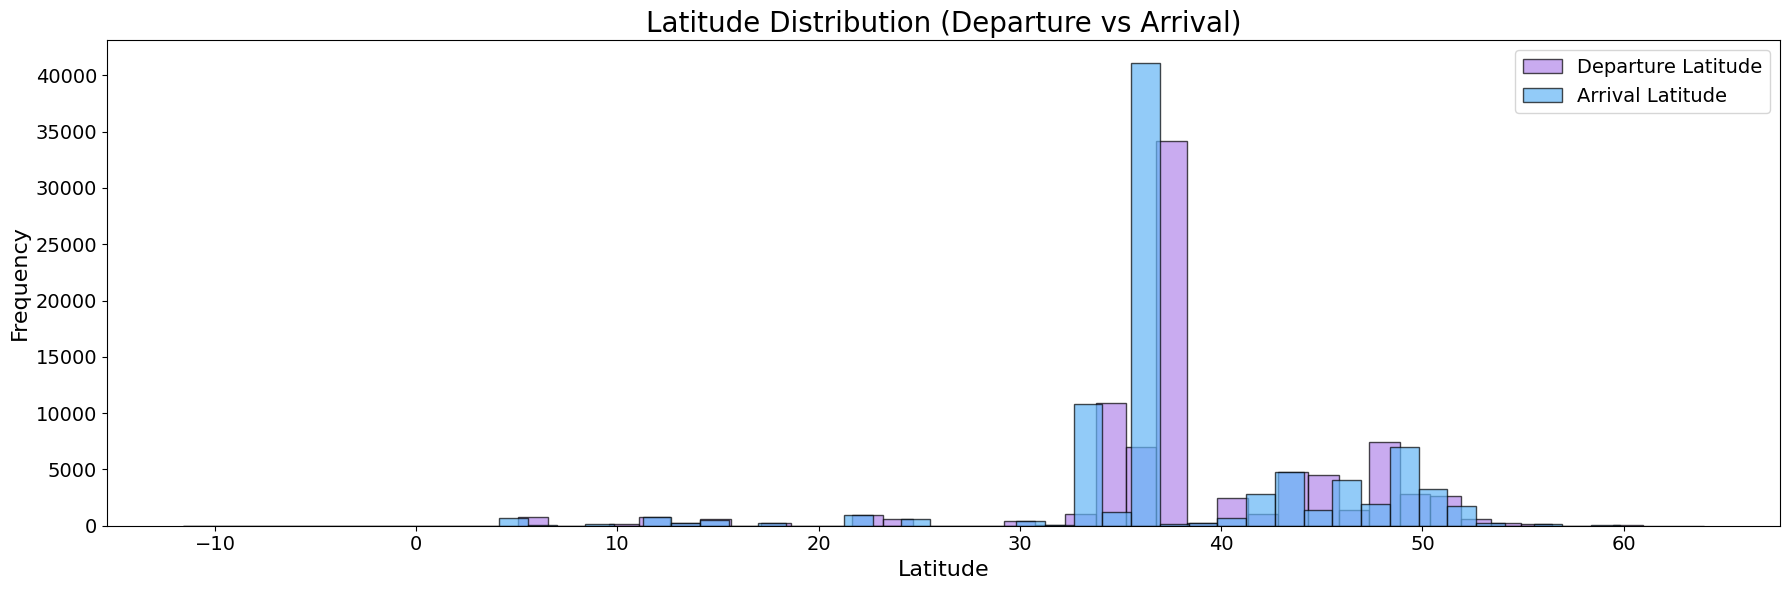

In [35]:
import matplotlib.pyplot as plt

# ----------------------------
# Latitude distribution
# ----------------------------

plt.figure(figsize=(18, 6))

plt.hist(train_df_eda["dep_lat"], bins=50,
         label="Departure Latitude",
         color="#B388EB", alpha=0.7,
         edgecolor="black")

plt.hist(train_df_eda["arr_lat"], bins=50,
         label="Arrival Latitude",
         color="#64B5F6", alpha=0.7,
         edgecolor="black")

plt.title("Latitude Distribution (Departure vs Arrival)", fontsize=20)
plt.xlabel("Latitude", fontsize=16)
plt.ylabel("Frequency", fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=14)

plt.tight_layout()
plt.show()


✅ Code Cell 2 — Longitude Distribution (Departure vs Arrival)

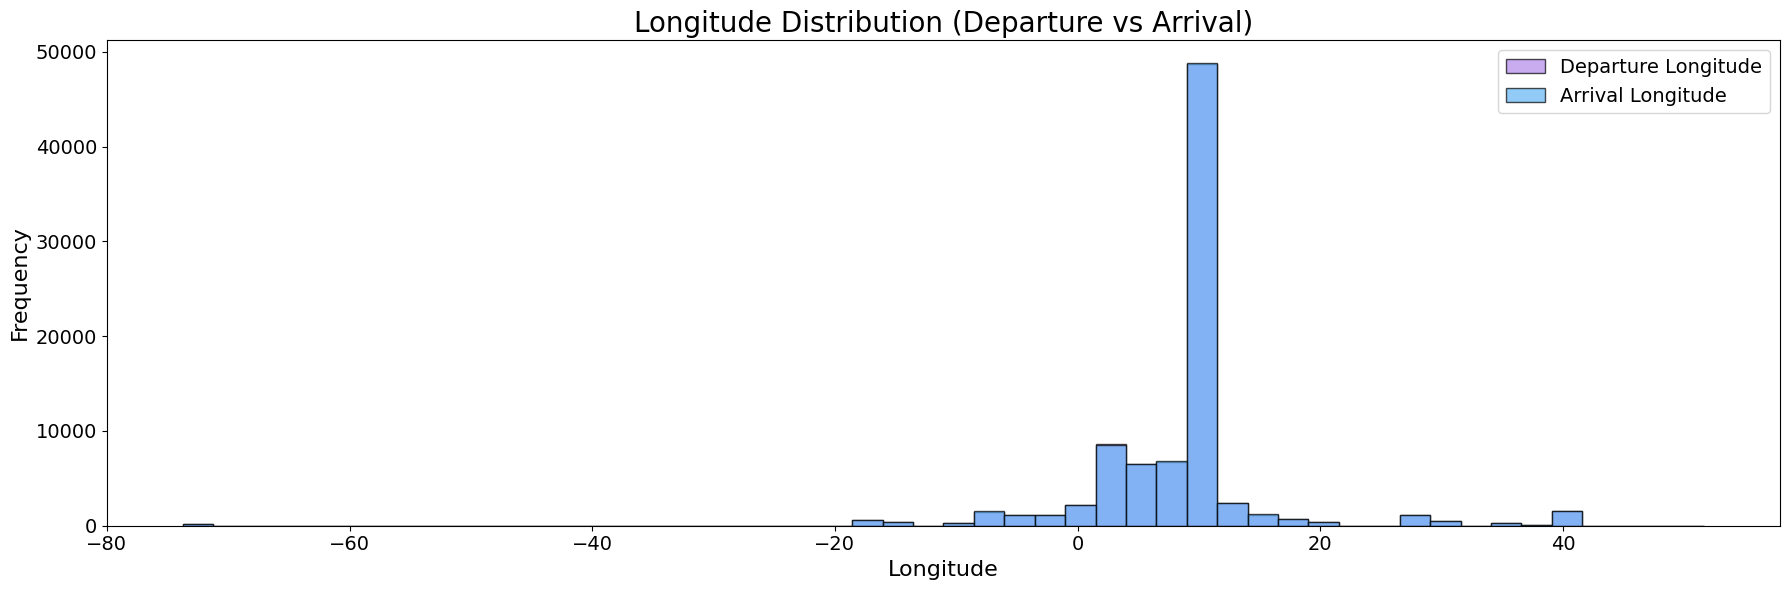

In [36]:
# ----------------------------
# Longitude distribution
# ----------------------------

plt.figure(figsize=(18, 6))

plt.hist(train_df_eda["dep_lon"], bins=50,
         label="Departure Longitude",
         color="#B388EB", alpha=0.7,
         edgecolor="black")

plt.hist(train_df_eda["arr_lon"], bins=50,
         label="Arrival Longitude",
         color="#64B5F6", alpha=0.7,
         edgecolor="black")

plt.title("Longitude Distribution (Departure vs Arrival)", fontsize=20)
plt.xlabel("Longitude", fontsize=16)
plt.ylabel("Frequency", fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=14)

plt.tight_layout()
plt.show()


**Observation**

Both departure and arrival latitude distributions are highly concentrated between approximately 30° and 55°, indicating that most flights operate within mid-latitude regions, primarily covering Europe and surrounding areas.  
Longitude values are mainly clustered between approximately -10° and 20°, with smaller secondary clusters extending toward eastern and western longitudes.  
The strong overlap between departure and arrival coordinate distributions suggests similar geographic coverage for origin and destination airports.  
No invalid coordinate ranges are observed (latitude remains within [-90, 90] and longitude within [-180, 180]), indicating that the geographic data is physically consistent.

This geographic concentration is consistent with the operational network of Tunisair, which mainly serves regional and short-to-medium haul routes connecting Tunisia with nearby European and Mediterranean destinations.  
Therefore, the dataset is geographically aligned with the target application domain of the challenge and is suitable for learning location-dependent delay patterns relevant to Tunisair operations.


#### 5.4.4 Time-Based Features

#### 5.4.4.1 Temporal Feature Construction

In [37]:
# ----------------------------
# Central Temporal Feature Construction
# ----------------------------

import pandas as pd

# Parse departure date (DATOP)
train_df_eda["DATOP_dt"] = pd.to_datetime(
    train_df_eda["DATOP"],
    errors="coerce"
)

# Parse scheduled arrival time (STA) with dot-separated time format
train_df_eda["STA_dt"] = pd.to_datetime(
    train_df_eda["STA"],
    format="%Y-%m-%d %H.%M.%S",
    errors="coerce"
)

# Parse scheduled departure time (STD)
train_df_eda["STD_dt"] = pd.to_datetime(
    train_df_eda["STD"],
    errors="coerce"
)

# ----------------------------
# Extract time-based features
# ----------------------------

# Hour of day
train_df_eda["dep_hour"] = train_df_eda["STD_dt"].dt.hour
train_df_eda["arr_hour"] = train_df_eda["STA_dt"].dt.hour

# Day of week
train_df_eda["dep_day"] = train_df_eda["DATOP_dt"].dt.day_name()
train_df_eda["arr_day"] = train_df_eda["STA_dt"].dt.day_name()

# Month
train_df_eda["dep_month"] = train_df_eda["DATOP_dt"].dt.month
train_df_eda["arr_month"] = train_df_eda["STA_dt"].dt.month

# ----------------------------
# Quick sanity check
# ----------------------------

train_df_eda[[
    "STD", "STA",
    "dep_hour", "arr_hour",
    "dep_day", "arr_day",
    "dep_month", "arr_month"
]].head()


,STD,STA,dep_hour,arr_hour,dep_day,arr_day,dep_month,arr_month
30962,2016-11-10 15:25:00,2016-11-10 16.00.00,15,16,Thursday,Thursday,11,11
34625,2017-06-24 16:35:00,2017-06-24 18.05.00,16,18,Saturday,Saturday,6,6
76736,2018-06-03 16:55:00,2018-06-03 19.55.00,16,19,Sunday,Sunday,6,6
52580,2017-08-18 00:35:00,2017-08-18 05.10.00,0,5,Friday,Friday,8,8
97130,2018-12-09 15:00:00,2018-12-09 16.25.00,15,16,Sunday,Sunday,12,12


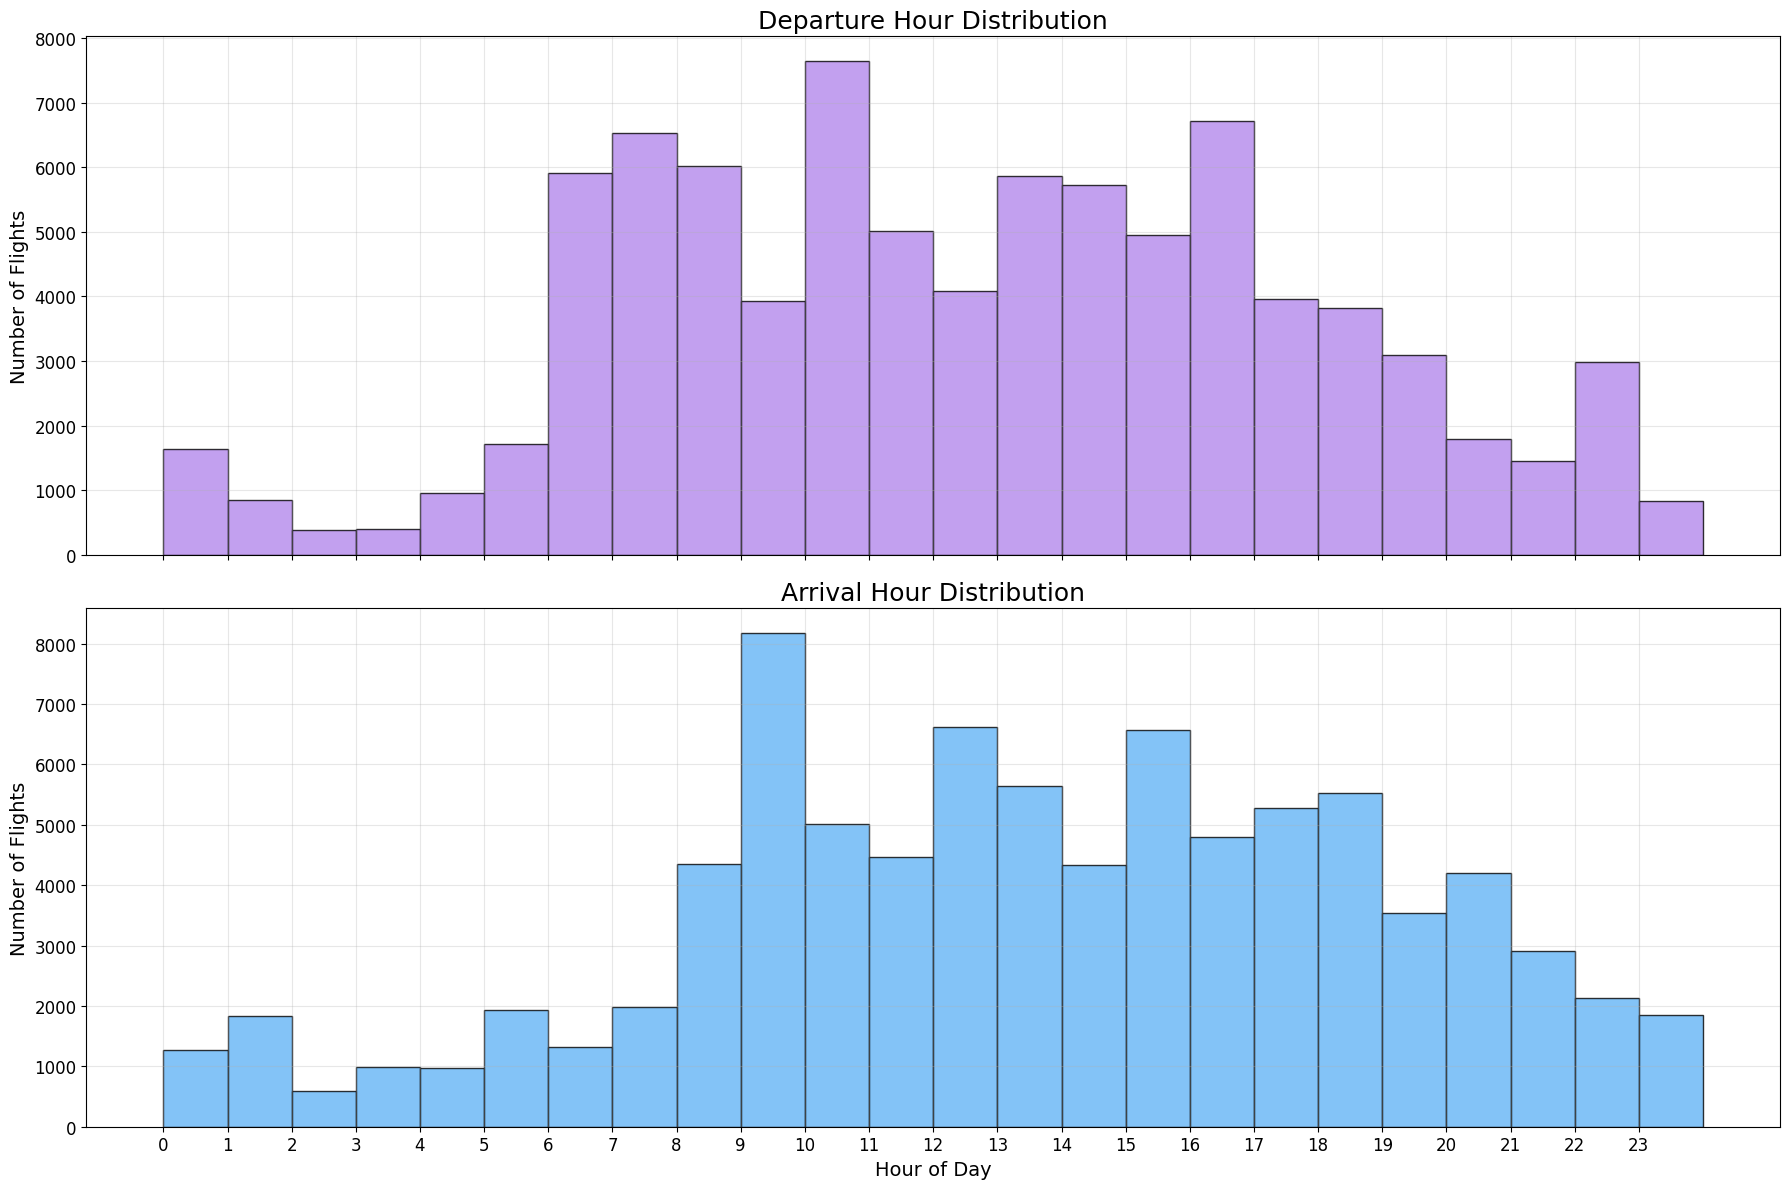

In [38]:

# ----------------------------
# Hour of day distribution (Departure vs Arrival)
# ----------------------------

fig, axes = plt.subplots(2, 1, figsize=(18, 12), sharex=True)

# Departure hour
axes[0].hist(
    train_df_eda["dep_hour"].dropna(),
    bins=24,
    range=(0, 24),
    color="#B388EB",
    alpha=0.8,
    edgecolor="black"
)

axes[0].set_title("Departure Hour Distribution", fontsize=18)
axes[0].set_ylabel("Number of Flights", fontsize=14)
axes[0].tick_params(axis="y", labelsize=12)
axes[0].grid(alpha=0.3)

# Arrival hour
axes[1].hist(
    train_df_eda["arr_hour"].dropna(),
    bins=24,
    range=(0, 24),
    color="#64B5F6",
    alpha=0.8,
    edgecolor="black"
)

axes[1].set_title("Arrival Hour Distribution", fontsize=18)
axes[1].set_xlabel("Hour of Day", fontsize=14)
axes[1].set_ylabel("Number of Flights", fontsize=14)
axes[1].tick_params(axis="both", labelsize=12)
axes[1].grid(alpha=0.3)

plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()


**Observation**

Both departure and arrival flights show strong concentration during daytime operational hours, with clear peaks in the morning and afternoon periods.
Most flights are scheduled during daytime hours.
Departure and arrival activity peaks in the morning (around 7–10) and again in the afternoon (around 14–17).
Very few flights operate during late night and early morning hours (0–5), indicating limited overnight operations.
This pattern reflects typical airline scheduling behavior and indicates that time-of-day may be an important temporal feature for modeling delay dynamics.

##### - Day of Week Distribution (Departure vs Arrival)

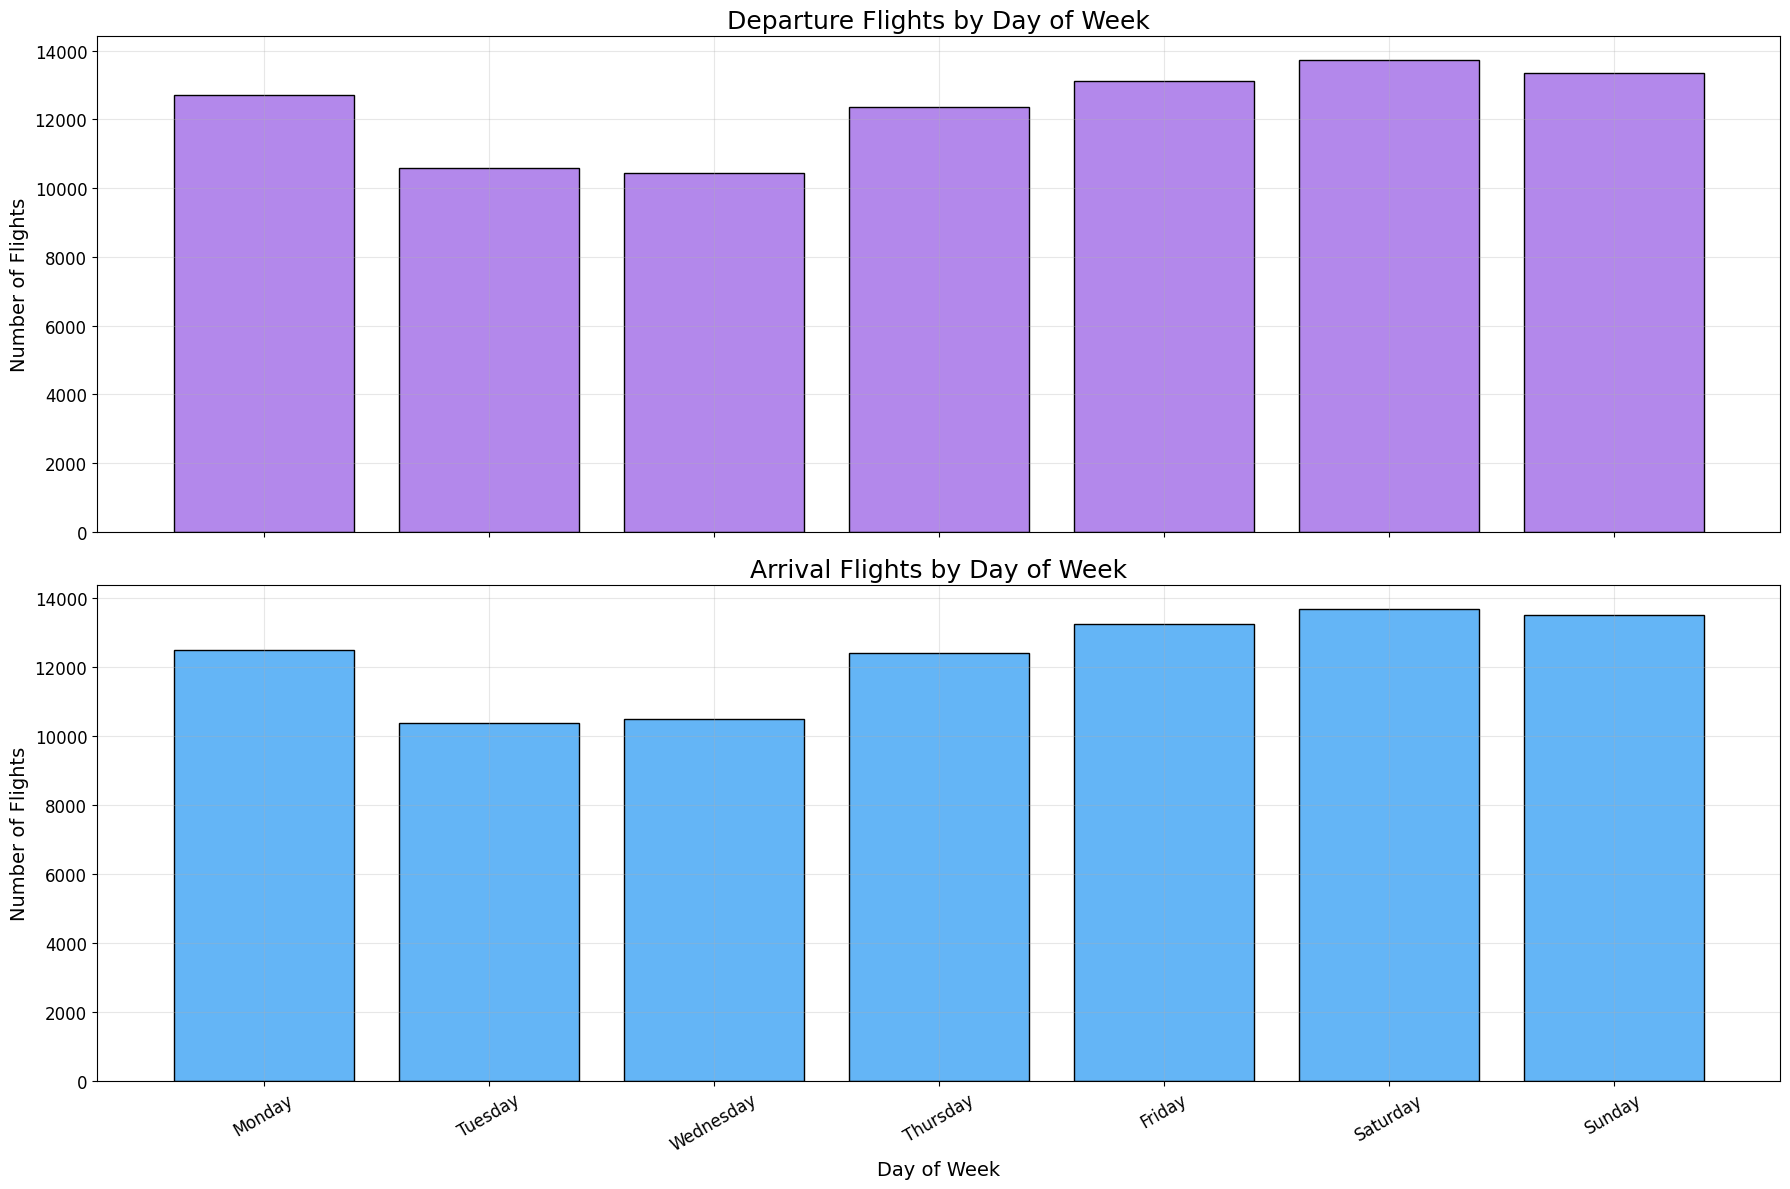

In [39]:

# ----------------------------
# Day of week distribution (Departure vs Arrival)
# ----------------------------

day_order = ["Monday", "Tuesday", "Wednesday", "Thursday",
             "Friday", "Saturday", "Sunday"]

dep_counts = train_df_eda["dep_day"].value_counts().reindex(day_order)
arr_counts = train_df_eda["arr_day"].value_counts().reindex(day_order)

# ----------------------------
# Plot subplots
# ----------------------------

fig, axes = plt.subplots(2, 1, figsize=(18, 12), sharex=True)

# Departure
axes[0].bar(day_order, dep_counts,
            color="#B388EB", edgecolor="black")

axes[0].set_title("Departure Flights by Day of Week", fontsize=18)
axes[0].set_ylabel("Number of Flights", fontsize=14)
axes[0].tick_params(axis="y", labelsize=12)
axes[0].grid(alpha=0.3)

# Arrival
axes[1].bar(day_order, arr_counts,
            color="#64B5F6", edgecolor="black")

axes[1].set_title("Arrival Flights by Day of Week", fontsize=18)
axes[1].set_xlabel("Day of Week", fontsize=14)
axes[1].set_ylabel("Number of Flights", fontsize=14)
axes[1].tick_params(axis="both", labelsize=12)
axes[1].grid(alpha=0.3)

plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


**Observation**

Flight volume is relatively stable across the week, with slightly lower activity on Tuesday and Wednesday.
The highest number of both departures and arrivals occurs during the weekend, especially on Saturday and Sunday, indicating increased travel demand toward the end of the week.

##### - Monthly Distribution (Departure vs Arrival)


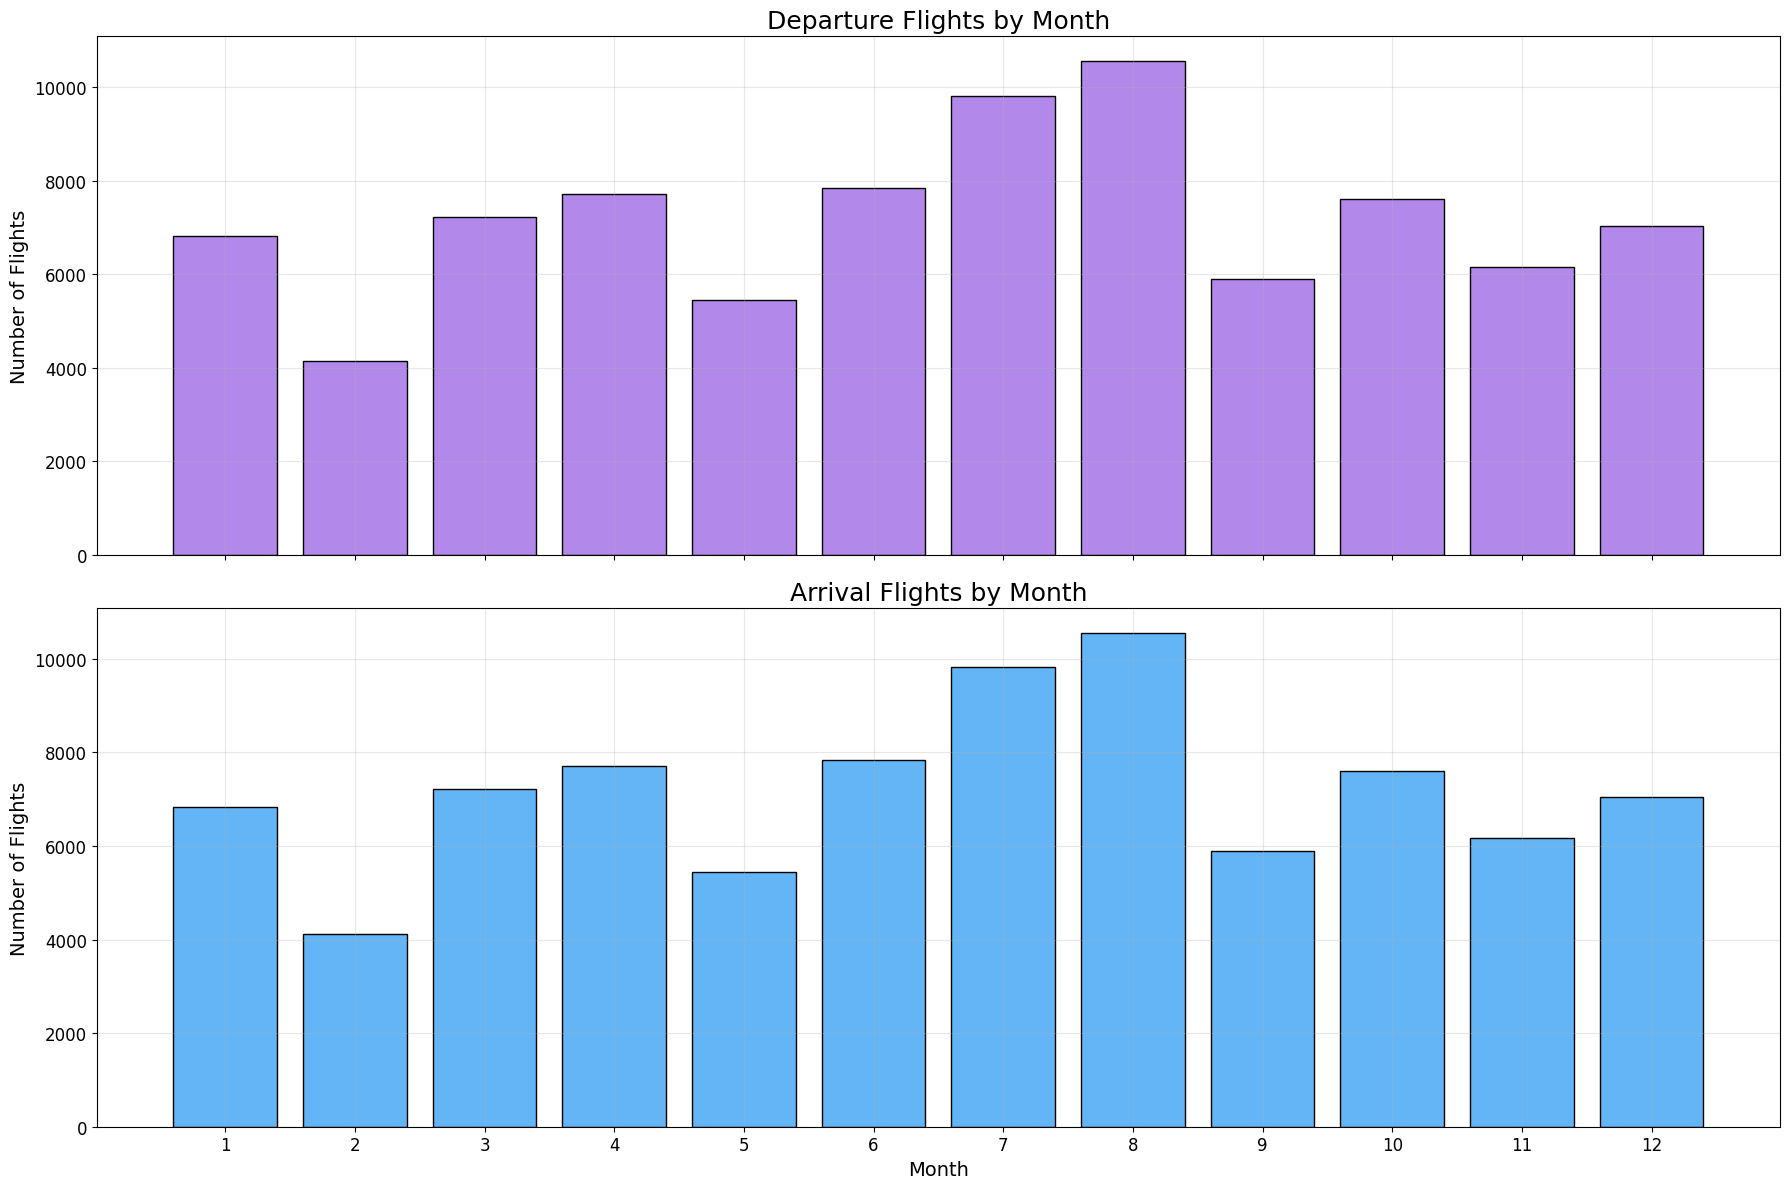

In [40]:

# ----------------------------
# Monthly distribution (Departure vs Arrival)
# ----------------------------

months = range(1, 13)

dep_month_counts = (
    train_df_eda["dep_month"]
    .value_counts()
    .sort_index()
    .reindex(months)
)

arr_month_counts = (
    train_df_eda["arr_month"]
    .value_counts()
    .sort_index()
    .reindex(months)
)

# ----------------------------
# Plot subplots
# ----------------------------

fig, axes = plt.subplots(2, 1, figsize=(18, 12), sharex=True)

# Departure
axes[0].bar(
    months,
    dep_month_counts,
    color="#B388EB",
    edgecolor="black"
)

axes[0].set_title("Departure Flights by Month", fontsize=18)
axes[0].set_ylabel("Number of Flights", fontsize=14)
axes[0].tick_params(axis="y", labelsize=12)
axes[0].grid(alpha=0.3)

# Arrival
axes[1].bar(
    months,
    arr_month_counts,
    color="#64B5F6",
    edgecolor="black"
)

axes[1].set_title("Arrival Flights by Month", fontsize=18)
axes[1].set_xlabel("Month", fontsize=14)
axes[1].set_ylabel("Number of Flights", fontsize=14)
axes[1].tick_params(axis="both", labelsize=12)
axes[1].grid(alpha=0.3)

plt.xticks(months)
plt.tight_layout()
plt.show()



**Observation**

Both departure and arrival flight volumes show clear seasonal patterns.
Flight activity is lowest in February and May, while peak volumes occur during summer months, especially July and August.

This seasonal trend is consistent with increased travel demand during the summer holiday period and indicates that month-of-year is a meaningful temporal feature for capturing demand-driven delay patterns.

### 5.5 Distribution Analysis (Categorical Features)

#### 5.5.1 Categorical Feature Cardinality Analysis

In [41]:
# ----------------------------------
# 5.5.1 Categorical Feature Cardinality Analysis
# ----------------------------------

# Select categorical features for analysis
categorical_cols = [
    'STATUS',
    'AC',
    'DEPSTN',
    'ARRSTN',
    'dep_country',
    'arr_country',
    'dep_tz',
    'arr_tz'
]

# Cardinality overview
cardinality_summary = (
    train_df_eda[categorical_cols]
    .nunique()
    .sort_values(ascending=False)
    .to_frame(name="n_unique")
)

cardinality_summary


,n_unique
ARRSTN,127
DEPSTN,125
AC,68
dep_tz,53
arr_tz,53
dep_country,52
arr_country,51
STATUS,5


In [42]:
# Inspect frequency distribution for high-cardinality candidates
for col in categorical_cols:
    print(f"\n=== {col} ===")
    display(
        train_df_eda[col]
        .value_counts(normalize=True)
        .head(10)
    )



=== STATUS ===


STATUS
ATA    0.868082
SCH    0.123351
DEP    0.004312
RTR    0.002852
DEL    0.001403
Name: proportion, dtype: float64


=== AC ===


AC
TU 320IMU    0.044177
TU 320IMW    0.043007
TU 320IMT    0.042972
TU 320IMR    0.042949
TU 320IMV    0.041847
TU 320IMS    0.039146
TU 32AIML    0.038358
TU 32AIMP    0.038335
TU 32AIMG    0.037616
TU 31BIMQ    0.037489
Name: proportion, dtype: float64


=== DEPSTN ===


DEPSTN
TUN    0.394211
DJE    0.095611
ORY    0.062817
MIR    0.048432
MRS    0.026673
LYS    0.021932
NCE    0.020321
ALG    0.014641
MXP    0.014096
IST    0.013192
Name: proportion, dtype: float64


=== ARRSTN ===


ARRSTN
TUN    0.394420
DJE    0.095704
ORY    0.062330
MIR    0.049000
MRS    0.026557
LYS    0.021863
NCE    0.020506
ALG    0.014351
MXP    0.014026
IST    0.013505
Name: proportion, dtype: float64


=== dep_country ===


dep_country
TN    0.570399
FR    0.164514
IT    0.037744
DE    0.034057
DZ    0.020680
SA    0.017620
MA    0.016484
CH    0.013922
TR    0.013424
BE    0.013122
Name: proportion, dtype: float64


=== arr_country ===


arr_country
TN    0.570607
FR    0.164051
IT    0.037952
DE    0.034162
DZ    0.020622
SA    0.017956
MA    0.016785
CH    0.014003
TR    0.013771
BE    0.013076
Name: proportion, dtype: float64


=== dep_tz ===


dep_tz
Africa/Tunis         0.570399
Europe/Paris         0.164514
Europe/Rome          0.037744
Europe/Berlin        0.034057
Africa/Algiers       0.020680
Asia/Riyadh          0.017620
Africa/Casablanca    0.016484
Europe/Zurich        0.013922
Europe/Istanbul      0.013424
Europe/Brussels      0.013122
Name: proportion, dtype: float64


=== arr_tz ===


arr_tz
Africa/Tunis         0.570607
Europe/Paris         0.164051
Europe/Rome          0.037952
Europe/Berlin        0.034162
Africa/Algiers       0.020622
Asia/Riyadh          0.017956
Africa/Casablanca    0.016785
Europe/Zurich        0.014003
Europe/Istanbul      0.013771
Europe/Brussels      0.013076
Name: proportion, dtype: float64

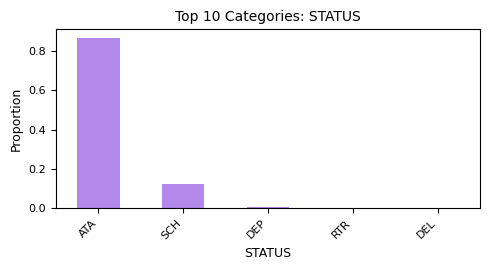

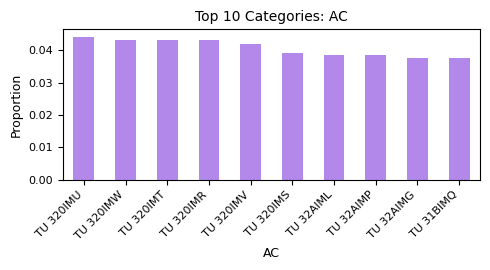

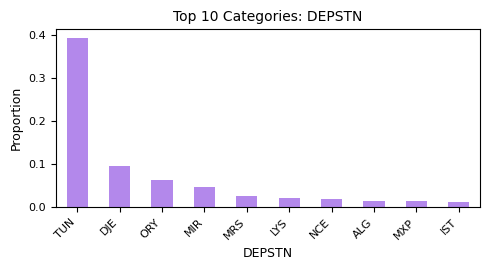

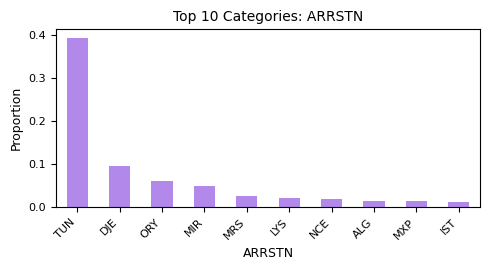

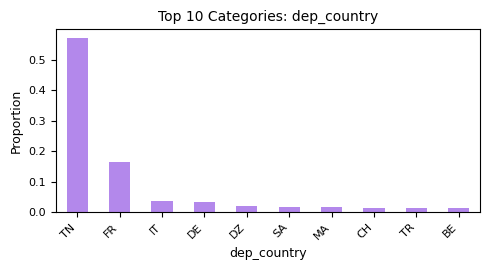

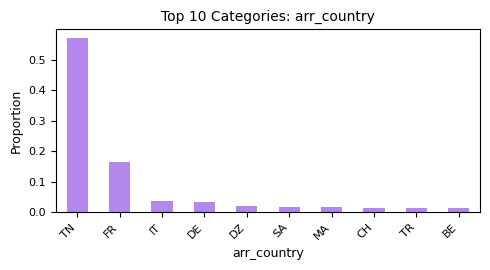

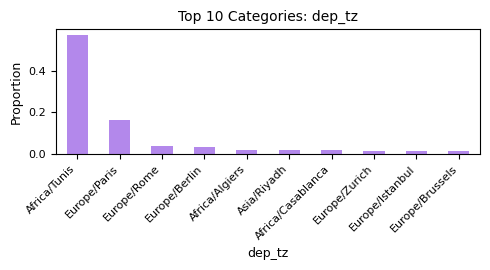

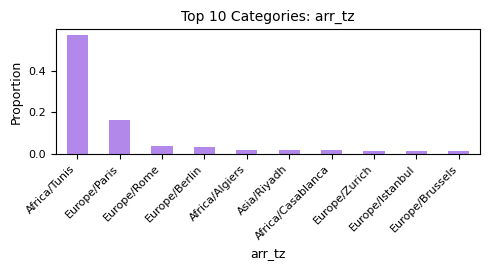

In [43]:
import matplotlib.pyplot as plt

# Visualize frequency distribution for high-cardinality categorical features
for col in categorical_cols:
    vc = (
        train_df_eda[col]
        .value_counts(normalize=True)
        .head(10)
    )

    plt.figure(figsize=(5, 2.8))  # smaller figure
    vc.plot(kind="bar", color="#B388EB")
    
    plt.title(f"Top 10 Categories: {col}", fontsize=10)
    plt.ylabel("Proportion", fontsize=9)
    plt.xlabel(col, fontsize=9)
    plt.xticks(rotation=45, ha="right", fontsize=8)
    plt.yticks(fontsize=8)
    
    plt.tight_layout()
    plt.show()


#### Observations from Cardinality & Frequency Analysis

- `STATUS` has very low cardinality (5 unique values) but exhibits strong class imbalance.  
  The category `ATA` dominates the distribution (≈87%), while `SCH`, `DEP`, `RTR`, and `DEL` occur only rarely.  
  *Potential handling:* one-hot encoding with awareness of imbalance, or grouping rare categories.

- `DEPSTN` and `ARRSTN` are very high-cardinality features with 125 and 127 unique values, respectively.  
  Both show a clear long-tail distribution, where a small number of airports (e.g. `TUN`, `DJE`, `ORY`) account for a large share of observations.  
  *Potential handling:* top-N grouping with an `Other` category, frequency encoding, or exclusion from linear models.

- `AC` is a high-cardinality categorical feature with 68 unique aircraft identifiers.  
  While common aircraft types cover a substantial portion of the data, a long tail of rare aircraft models remains present.  
  *Potential handling:* frequency encoding or grouping rare aircraft types.

- `dep_country` and `arr_country` each contain more than 50 unique categories and show heavily skewed distributions.  
  A small number of countries dominate, followed by many infrequent categories.  
  *Potential handling:* top-K grouping, region-based aggregation, or frequency encoding.

- `dep_tz` and `arr_tz` display similar behavior to country features, with strong concentration on a few dominant time zones.  
  *Potential handling:* grouping rare time zones or replacing with higher-level regional indicators.

- Overall, the analysis confirms a clear separation between low- and high-cardinality categorical features.  
  `STATUS` can be treated as low-cardinality, while `DEPSTN`, `ARRSTN`, `AC`, `dep_country`, `arr_country`, `dep_tz`, and `arr_tz` should be handled using model-dependent preprocessing strategies.


#### 5.5.2 Flight Status Distribution

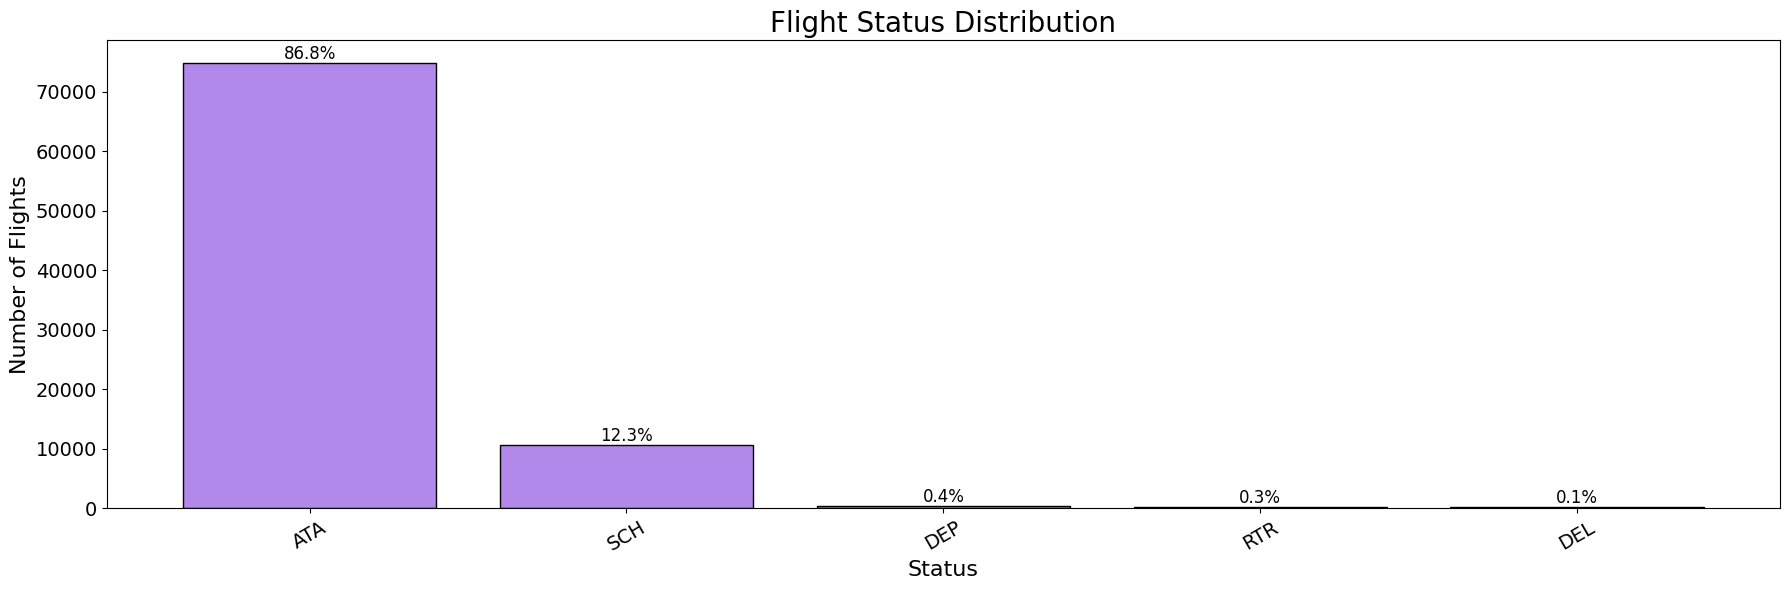

In [44]:

# ----------------------------
# Flight status distribution with percentage labels
# ----------------------------

status_counts = train_df_eda["STATUS"].value_counts()
total_count = status_counts.sum()

plt.figure(figsize=(18, 6))

bars = plt.bar(
    status_counts.index,
    status_counts.values,
    color="#B388EB",
    edgecolor="black"
)

plt.title("Flight Status Distribution", fontsize=20)
plt.xlabel("Status", fontsize=16)
plt.ylabel("Number of Flights", fontsize=16)

plt.xticks(fontsize=14, rotation=30)
plt.yticks(fontsize=14)

# Add percentage labels on top of bars
for bar in bars:
    height = bar.get_height()
    percentage = (height / total_count) * 100

    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{percentage:.1f}%",
        ha="center",
        va="bottom",
        fontsize=12
    )

plt.tight_layout()
plt.show()


**Observation — Flight Status Distribution**

The majority of flights are labeled as ATA (~87%), indicating that most records correspond to successfully completed flights with recorded arrival times.
A smaller but still significant portion is labeled as SCH (~12%), which likely represents scheduled flights without confirmed arrival timestamps.

The remaining categories (DEP, RTR, DEL) each account for less than 1% of the dataset and represent rare operational events such as partial departures, returns to gate, or major disruptions.

Likely interpretation of status codes:

ATA (Actual Time of Arrival): Completed flights with recorded arrival time

SCH (Scheduled): Flights planned but without confirmed arrival record

DEP (Departed): Flights that departed but lack arrival information

RTR (Return to Ramp/Gate): Flights that returned to gate after pushback or taxi

DEL (Delayed/Cancelled): Flights with major operational disruption (delay or cancellation)

⚠️ Data Leakage Consideration:
The STATUS variable may contain post-event operational information that is not available at prediction time.
Using this feature directly for delay prediction could introduce data leakage and artificially inflate model performance.
Therefore, this variable should be carefully evaluated or excluded during the modeling phase.

#### 5.5.3 Aircraft Type Distribution (AC)

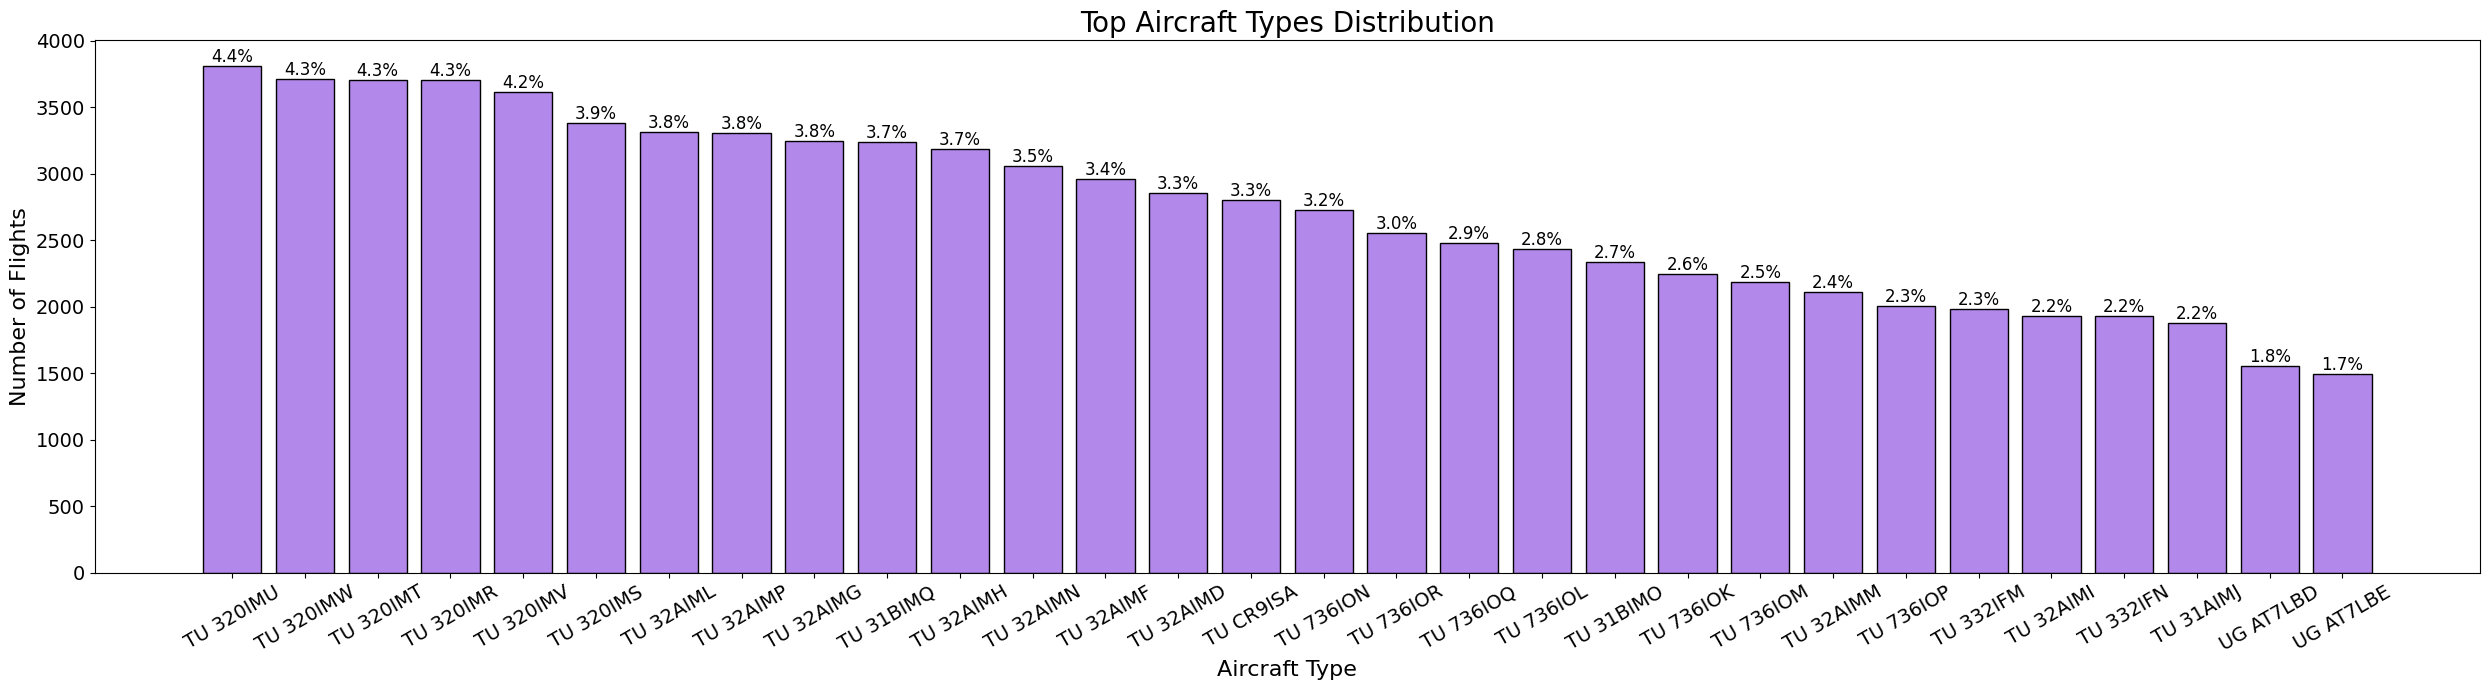

In [45]:
import matplotlib.pyplot as plt

# ----------------------------
# Aircraft type distribution
# ----------------------------

ac_counts = train_df_eda["AC"].value_counts()
ac_percent = ac_counts / ac_counts.sum() * 100

# Take top 30 aircraft types for readability
top_n = 30
ac_counts_top = ac_counts.head(top_n)
ac_percent_top = ac_percent.head(top_n)

plt.figure(figsize=(25, 7))

bars = plt.bar(
    ac_counts_top.index,
    ac_counts_top.values,
    color="#B388EB",
    edgecolor="black"
)

plt.title("Top Aircraft Types Distribution", fontsize=20)
plt.xlabel("Aircraft Type", fontsize=16)
plt.ylabel("Number of Flights", fontsize=16)

plt.xticks(rotation=30, fontsize=14)
plt.yticks(fontsize=14)

# Add percentage labels on top of bars
for bar, pct in zip(bars, ac_percent_top):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{pct:.1f}%",
        ha="center",
        va="bottom",
        fontsize=12
    )

plt.tight_layout()
plt.show()


In [46]:
print(train_df_eda["AC"].unique().shape)
train_df_eda["AC"].unique()

(68,)


array(['UG AT7AT7', 'TU 320IMS', 'TU 32AIMD', 'TU 320IMU', 'TU 31BIMQ',
       '5K 345TFX', 'TU CR9ISA', 'TU 32AIMP', 'TU 736ION', 'UG AT7LBE',
       'TU 32AIMI', 'TU 736IOK', 'TU 32AIMC', 'TU 32AIMF', 'TU 31BIMO',
       '5K 343TQY', 'TU 31AIMJ', 'TU 332IFN', 'TU 332IFM', 'TU 320IMW',
       'TU 32AIMM', 'TU 320IMV', 'PS 738PSD', 'TU 736IOL', 'TU 320IMT',
       'TU 32AIML', 'TU 736IOP', 'TU 32AIMN', 'TU 320IMR', 'TU 736IOR',
       'TU 32AIMH', 'TU 736IOM', 'TU 736IOQ', 'GJ 733LGC', 'TU 32AIMG',
       'UG CR9XXX', 'TU 31AIMK', 'UG AT7LBD', 'D4 319CQG', '5M 343FOX',
       '5M 343SUN', 'GJ 733GGC', 'D4 320CQP', 'UG CR9CR9', 'GJ 734PGC',
       'GJ 733EWE', 'BJ 320INP', 'UG CR9ISA', 'GJ 734MGC', 'QS 738TSC',
       'GJ 734CGC', '5M 343JAI', 'UJ 320TCF', 'BJ 320INO', 'BJ 320INC',
       'GW 320MQH', 'BJ 320INA', 'BJ 320INB', 'X9 320VEB', 'BJ 320INQ',
       '6P M87TRJ', 'BJ 320INR', 'BJ 320INH', 'TU 320320', 'TU CR9XXX',
       'TU CR9CR9', 'OL 321ABY', 'TU 32A32A'], dtype=object)

In [47]:
train_df_eda["AC"].value_counts().head(10)

AC
TU 320IMU    3811
TU 320IMW    3710
TU 320IMT    3707
TU 320IMR    3705
TU 320IMV    3610
TU 320IMS    3377
TU 32AIML    3309
TU 32AIMP    3307
TU 32AIMG    3245
TU 31BIMQ    3234
Name: count, dtype: int64

In [48]:
(train_df_eda["AC"].value_counts(normalize=True) * 100).round(2).head(10)

AC
TU 320IMU    4.42
TU 320IMW    4.30
TU 320IMT    4.30
TU 320IMR    4.29
TU 320IMV    4.18
TU 320IMS    3.91
TU 32AIML    3.84
TU 32AIMP    3.83
TU 32AIMG    3.76
TU 31BIMQ    3.75
Name: proportion, dtype: float64

**Observation — Aircraft Type (AC)**

The aircraft type distribution is relatively spread across many categories, with approximately 68 distinct aircraft identifiers present in the dataset.
No single aircraft type dominates the dataset: the most frequent model accounts for only about 4.4% of all flights, and even the top 10 aircraft types each contribute less than 5% individually.

This indicates a high-cardinality categorical feature with moderate class imbalance and a long tail of less frequent aircraft types.
Such a distribution may require careful encoding strategies (for example grouping rare categories or using target/frequency encoding) during modeling to avoid sparsity and overfitting.

The aircraft identifier (AC) may indirectly encode operational or historical patterns.
Therefore, special care must be taken to ensure that feature engineering and encoding are performed only on training data and without using future information from the test set.

#### 5.5.4 Departure Country Distribution

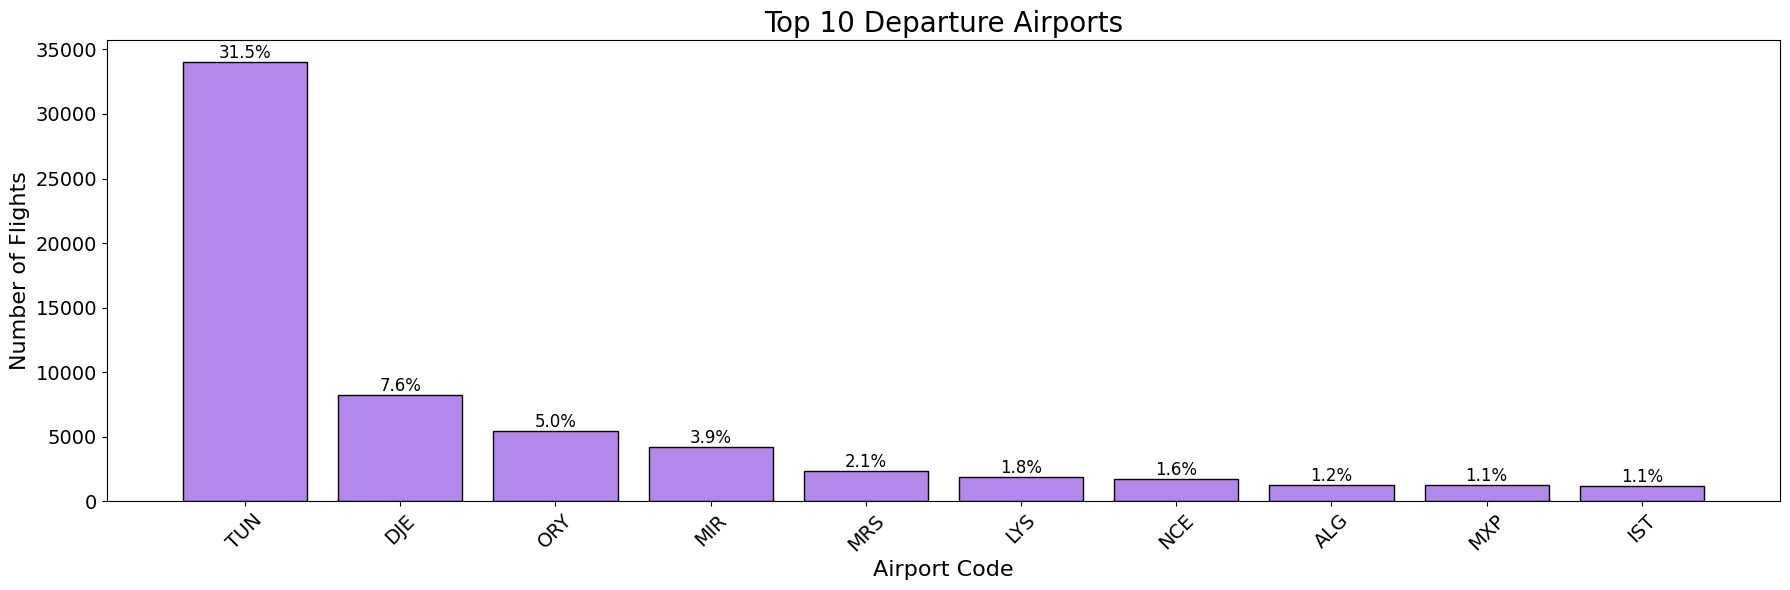

In [49]:
# ----------------------------
# Top Departure Airports
# ----------------------------

top_dep = train_df_eda["DEPSTN"].value_counts().head(10)

plt.figure(figsize=(18, 6))

bars = plt.bar(
    top_dep.index,
    top_dep.values,
    color="#B388EB",
    edgecolor="black"
)

plt.title("Top 10 Departure Airports", fontsize=20)
plt.xlabel("Airport Code", fontsize=16)
plt.ylabel("Number of Flights", fontsize=16)

plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)

# Add percentage labels
total_flights = len(train_df)

for bar in bars:
    height = bar.get_height()
    percent = height / total_flights * 100
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{percent:.1f}%",
        ha="center",
        va="bottom",
        fontsize=12
    )

plt.tight_layout()
plt.show()


In [50]:
print(train_df_eda["DEPSTN"].unique().shape)
train_df["DEPSTN"].unique()


(125,)


array(['CMN', 'MXP', 'TUN', 'DJE', 'TLS', 'IST', 'ORY', 'MIR', 'BRU',
       'ABJ', 'VCE', 'AMS', 'FRA', 'BCN', 'JED', 'ALG', 'LIS', 'SXB',
       'LYS', 'OUA', 'LGW', 'BEY', 'NCE', 'OPO', 'MRS', 'DUS', 'SFA',
       'FCO', 'CDG', 'NKC', 'NTE', 'ZRH', 'GVA', 'OUD', 'MUC', 'BER',
       'HAM', 'NDR', 'NBE', 'CAI', 'BEG', 'VIE', 'ORN', 'MAD', 'TOE',
       'BKO', 'DKR', 'KGL', 'BLQ', 'MLA', 'AHU', 'LHR', 'BOD', 'PRG',
       'LJU', 'SVO', 'MED', 'BUD', 'ARN', 'CPH', 'CRL', 'OST', 'TNG',
       'GAF', 'NAP', 'BRQ', 'OSR', 'YUL', 'NIM', 'TMR', 'JIB', 'CGN',
       'EBL', 'GAE', 'BJA', 'AYT', 'RAK', 'LFW', 'LIL', 'PMO', 'FBM',
       'TBJ', 'PSA', 'KRT', 'GNB', 'CZL', 'MVB', 'VNO', 'ESB', 'LBV',
       'CKY', 'LED', 'KSC', 'BTS', 'AMM', 'OTP', 'TRN', 'IEV', 'HBE',
       'CAG', 'KBP', 'ATH', 'SKG', 'ADB', 'DSS', 'DOH', 'COO', 'LUX',
       'FIH', 'BYJ', 'KEF', 'EBM', 'BDS', 'AAL', 'VKO', 'AAE', 'BRI',
       'VRN', 'SKX', 'HAJ', 'BLL', 'TLL', 'VOG', 'LAD', 'GHA', 'KTW',
       'SJJ', 'KRR',

#### 5.5.5 Arrival Country Distribution

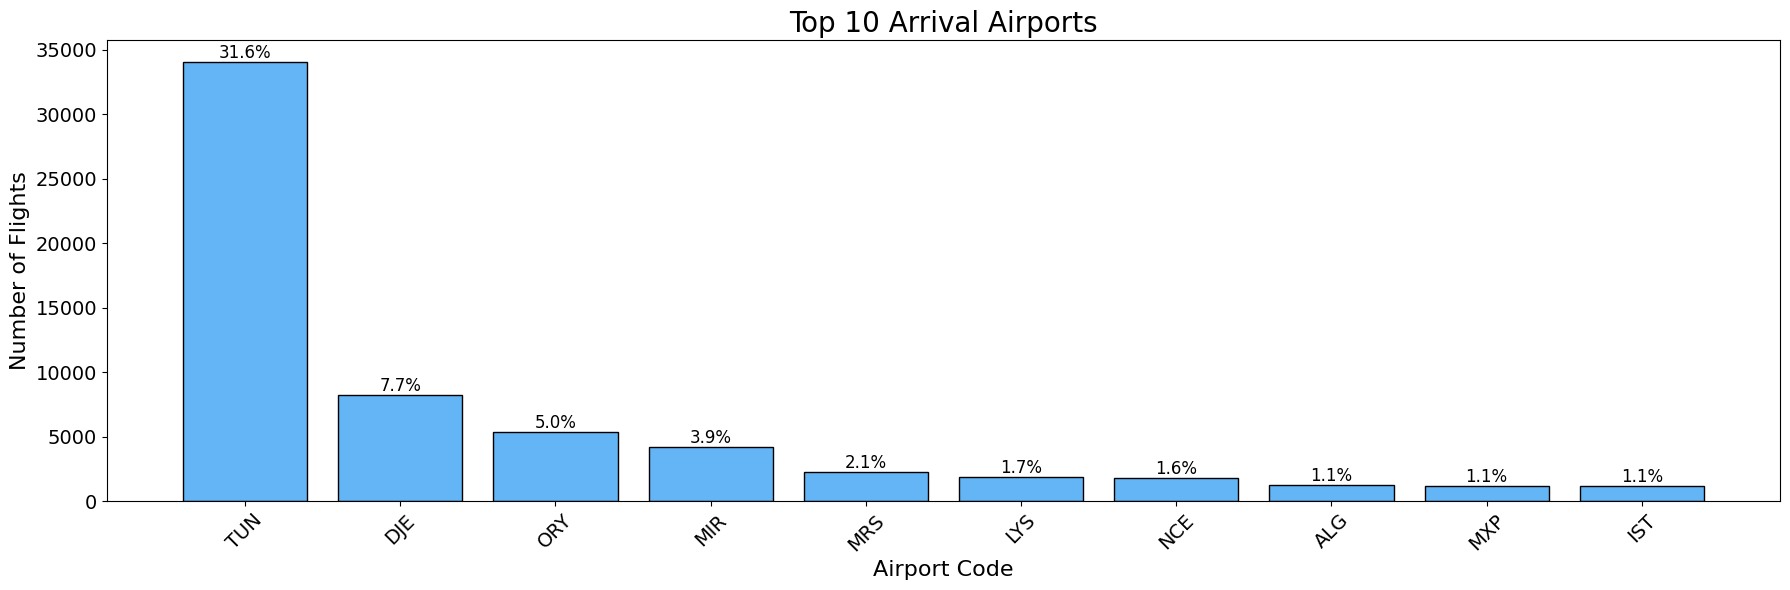

In [51]:
# ----------------------------
# Top Arrival Airports
# ----------------------------

top_arr = train_df_eda["ARRSTN"].value_counts().head(10)

plt.figure(figsize=(18, 6))

bars = plt.bar(
    top_arr.index,
    top_arr.values,
    color="#64B5F6",
    edgecolor="black"
)

plt.title("Top 10 Arrival Airports", fontsize=20)
plt.xlabel("Airport Code", fontsize=16)
plt.ylabel("Number of Flights", fontsize=16)

plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)

# Add percentage labels
for bar in bars:
    height = bar.get_height()
    percent = height / total_flights * 100
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{percent:.1f}%",
        ha="center",
        va="bottom",
        fontsize=12
    )

plt.tight_layout()
plt.show()


In [52]:
print(train_df_eda["ARRSTN"].unique().shape)
train_df_eda["ARRSTN"].unique()

(127,)


array(['GAE', 'TUN', 'MIR', 'FCO', 'GVA', 'DJE', 'ALG', 'MUC', 'ORN',
       'LYS', 'COO', 'DKR', 'ORY', 'NKC', 'NCE', 'CAI', 'NTE', 'JED',
       'BEG', 'SFA', 'BRQ', 'ABJ', 'CMN', 'VCE', 'BRU', 'VIE', 'CDG',
       'OUA', 'IST', 'TOE', 'BER', 'AMS', 'LED', 'DSS', 'NIM', 'BCN',
       'DUS', 'FRA', 'LGW', 'SXB', 'MRS', 'PRG', 'TLS', 'NBE', 'MAD',
       'BOD', 'OUD', 'HAM', 'LHR', 'NAP', 'MXP', 'BKO', 'BEY', 'CKY',
       'ZRH', 'MED', 'NDR', 'VKO', 'BUD', 'BLQ', 'LIS', 'YUL', 'EBL',
       'OST', 'ARN', 'SVO', 'GAF', 'MLA', 'PMO', 'CPH', 'ESB', 'CZL',
       'HAJ', 'RTM', 'HBE', 'ATH', 'CGN', 'OSR', 'BTS', 'OPO', 'LIL',
       'BJA', 'LJU', 'TRN', 'TBJ', 'IEV', 'AHU', 'VNO', 'KSC', 'CAG',
       'VRN', 'TNG', 'CRL', 'SJJ', 'EBM', 'AYT', 'AMM', 'FIH', 'BYJ',
       'BLL', 'KBP', 'OTP', 'GNB', 'CTA', 'PSA', 'SKG', 'JIB', 'SKX',
       'FBM', 'TPS', 'LBV', 'LFW', 'LUX', 'BRI', 'AAE', 'TMR', 'GHA',
       'VOG', 'BDS', 'BGY', 'LAD', 'DOH', 'RAK', 'MVB', 'ADB', 'KGL',
       'KRT'], dtype

**Observation — Top Departure and Arrival Airports**

Tunis-Carthage Airport (TUN) clearly dominates both departure and arrival traffic, accounting for roughly 40% of all flights.
This confirms that TUN acts as the main operational hub for Tunisair.

The remaining top airports (such as DJE, ORY, MIR, MRS) have significantly smaller shares, each contributing less than 10% individually.
This indicates a hub-and-spoke structure, where most routes are centered around Tunis with secondary connections to major regional and European airports.

The similarity between the top departure and arrival airport distributions suggests a balanced inbound and outbound traffic pattern, which is expected for scheduled airline operations.

This strong concentration should be considered during modeling, as airport-specific patterns (especially for TUN) may have a strong influence on delay behavior.


### 5.6 Feature Relationship Analysis (Feature–Feature)

#### 5.6.1 Numerical Feature Correlation Analysis

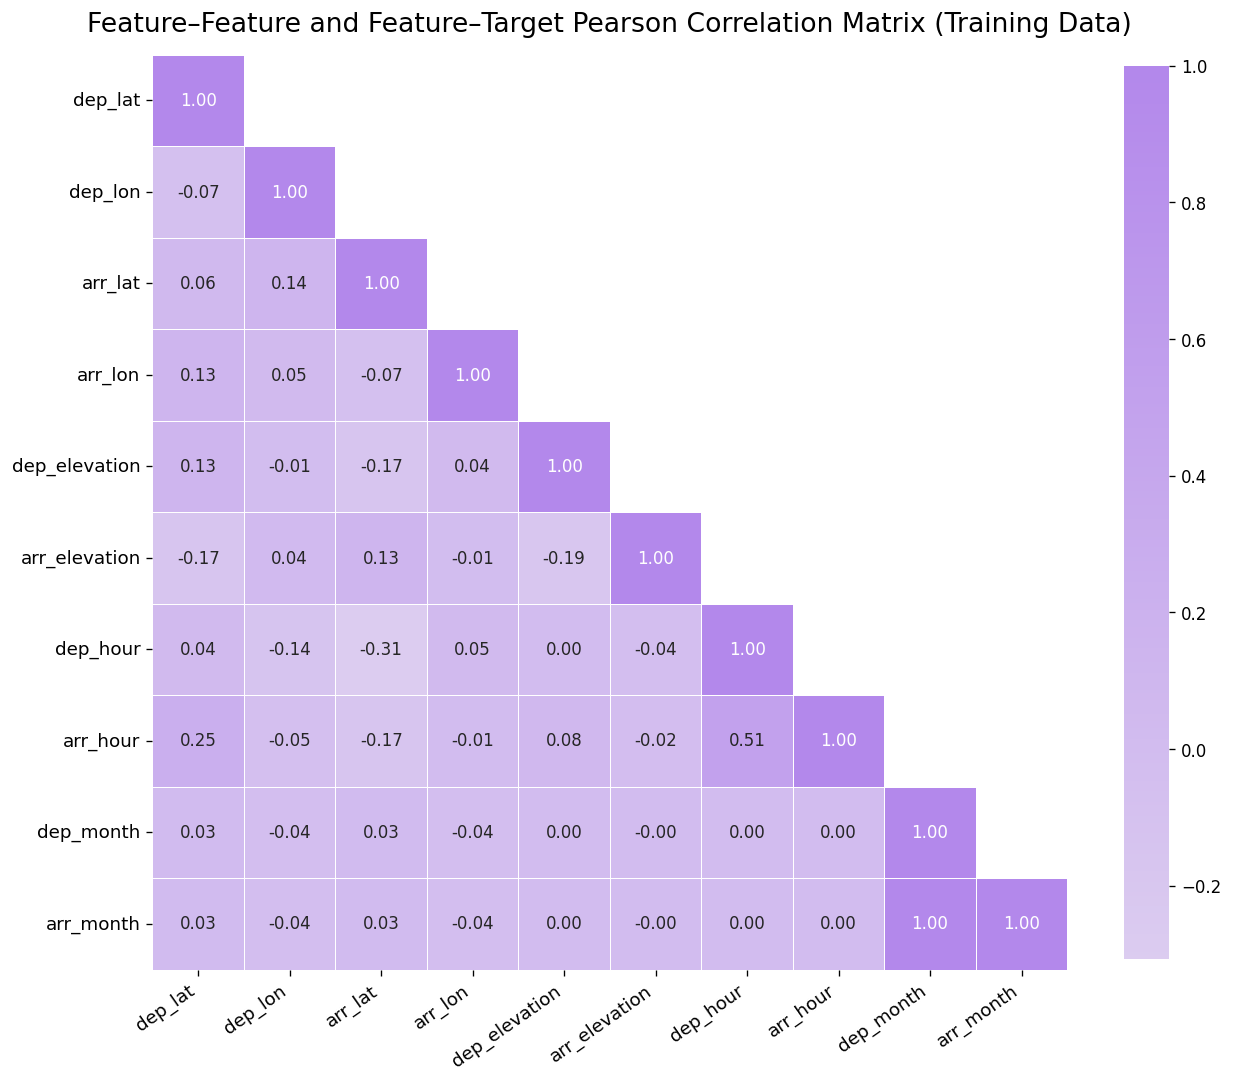

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------
# Correlation matrix
# ----------------------------

num_cols = [
    "dep_lat", "dep_lon",
    "arr_lat", "arr_lon",
    "dep_elevation", "arr_elevation",
    "dep_hour", "arr_hour",
    "dep_month", "arr_month"
]

corr = train_df_eda[num_cols].corr()

# Mask upper triangle (keep lower half only)
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

# Purple theme (your project color)
cmap = sns.light_palette("#B388EB", as_cmap=True)

# ----------------------------
# Plot
# ----------------------------

fig, ax = plt.subplots(figsize=(11, 10), dpi=120)

sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    annot=True,              # KEEP NUMBERS ✅
    fmt=".2f",
    annot_kws={"size": 10},  # bigger numbers (readable)
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    ax=ax
)

# Clean borders
for spine in ax.spines.values():
    spine.set_visible(False)

# Rotate labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=35, ha="right", fontsize=11)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=11)

ax.set_title(
    "Feature–Feature and Feature–Target Pearson Correlation Matrix (Training Data)",
    fontsize=16,
    pad=14
)

plt.tight_layout()
plt.show()

**Observation**

The correlation matrix shows generally low pairwise correlations among most numerical features, indicating limited multicollinearity.

A moderate positive correlation (~0.51) is observed between departure hour and arrival hour, which is expected due to scheduled flight durations and daily traffic patterns.

Departure month and arrival month exhibit perfect correlation (1.00), confirming that both features carry identical temporal information. Therefore, only one of them should be retained for modeling.

Geographic coordinates (latitude and longitude) and elevation features show weak correlations with other variables, suggesting that they provide largely independent spatial and environmental information.

Overall, the numerical feature set appears suitable for modeling with minimal redundancy after removing duplicated temporal features.

**Note on Time Zones**

Departure and arrival time-based features (hour of day, day of week) are currently extracted using local airport times.

This design choice is intentional, as local time patterns capture operational effects such as peak-hour congestion and daily scheduling behavior.

For duration-based or cross-airport temporal features, time zone normalization using airport time zone information (dep_tz, arr_tz) may be required and will be considered during the feature engineering phase.


#### 5.6.2 Redundant Feature Check (Semantic Overlap)

Several feature groups exhibit semantic overlap due to representing the same underlying temporal or spatial concepts at different levels of granularity.

##### Temporal feature overlap
- **dep_month and arr_month**  
  These features are perfectly correlated (correlation = 1.00), as most flights depart and arrive within the same calendar month. Retaining both introduces full redundancy without adding new information.  
  **Decision:** retain dep_month and exclude arr_month.

- **dep_hour and arr_hour**  
  These features show moderate correlation (~0.51), reflecting the dependency between departure and arrival times driven by scheduled flight duration and time zone effects. Since arr_hour represents post-departure information and may partially encode target-related behavior, it is considered less suitable for early modeling stages.  
  **Decision:** retain dep_hour and exclude arr_hour.

##### Geographic feature overlap
- **Absolute geographic coordinates (dep_lat, dep_lon, arr_lat, arr_lon)**  
  While departure and arrival coordinates are not strongly correlated numerically, they jointly encode the same spatial concept: the geometry of a flight route. Using multiple absolute coordinate representations alongside categorical location features risks introducing redundant spatial information and route memorization effects.

  To reduce redundancy and improve interpretability, geographic information is represented at the route level rather than via raw latitude and longitude pairs.

  **Decision:**  
  - Exclude absolute coordinate features (dep_lat, dep_lon, arr_lat, arr_lon).  
  - Replace them with a single route-level feature: **route_distance_km**, representing the great-circle distance between departure and arrival airports.

##### Elevation features
- **dep_elevation and arr_elevation**  
  Airport elevation captures local geographic characteristics that may influence operational conditions; however, elevation values are largely static and closely tied to airport identity. Including both departure and arrival elevation does not provide additional route-level information.

  **Decision:**  
  - Retain dep_elevation as a weak but potentially informative contextual feature.  
  - Exclude arr_elevation to avoid duplicating static airport-specific information.


#### 5.6.3 Multicollinearity Diagnostic (Preparation Step)

At this stage, multicollinearity is assessed qualitatively based on correlation patterns, semantic feature overlap, and route-level structural considerations.

Potential sources of multicollinearity are identified among:
- duplicated temporal variables (departure vs arrival month),
- partially dependent time features (departure vs arrival hour),
- multiple spatial encodings of airport location (coordinates, station identifiers, and country labels).

Rather than applying early feature elimination, these overlaps are addressed through deliberate feature representation choices, such as using **route_distance_km** instead of absolute geographic coordinates. A formal multicollinearity diagnostic using **Variance Inflation Factor (VIF)** will be conducted during the modeling phase after preprocessing and encoding have been applied, ensuring that diagnostics reflect the final model input space.


#### Summary of spatial and temporal feature decisions

##### Retained (mutually exclusive spatial representations)

One of the following spatial representations is selected for modeling:

**Option A — Country-level representation**
- dep_country
- arr_country

**Option B — Station-level representation**
- DEPSTN
- ARRSTN

In both cases, spatial information is complemented by a route-level distance feature.

Additional retained features:
- route_distance_km
- dep_elevation
- dep_month
- dep_hour

##### Excluded
- dep_lat, dep_lon
- arr_lat, arr_lon
- dep_tz, arr_tz
- arr_elevation
- airport identifiers and location descriptors not selected above (*_iata, *_icao, *_name, *_city, *_subd)

**Note:** Country-level and station-level representations are not used simultaneously to avoid redundant geographic encodings and route memorization effects.


#### 5.6.4 Route-Level Structural Observations
During feature–feature inspection, a subset of flights was identified where the departure and arrival airports are identical, resulting in a route distance of zero.

These records correspond to special operational cases (e.g. maintenance, repositioning, or non-revenue flights) and represent structurally valid but atypical routes.

This observation is documented to ensure correct interpretation of route-level features such as is_domestic and route_distance_km. No filtering or preprocessing decision is applied at this stage.

In [54]:
# ----------------------------------
# 5.6.4 Route-Level Structural Observations
# ----------------------------------

# Flights with identical departure and arrival airport
same_airport_mask = train_df_eda["DEPSTN"] == train_df_eda["ARRSTN"]

# How many such cases exist?
same_airport_mask.value_counts()


False    81793
True      4473
Name: count, dtype: int64

In [55]:
# Inspect a few examples
train_df_eda.loc[
    same_airport_mask,
    [
        "ID",
        "DATOP",
        "FLTID",
        "DEPSTN",
        "ARRSTN",
        "STD",
        "STA",
        "STATUS",
        "target"
    ]
].head(10)


,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,target
30605,train_id_30605,2016-03-02,TU 3601,TUN,TUN,2016-03-02 13:00:00,2016-03-02 16.00.00,SCH,0.0
31931,train_id_31931,2016-11-16,AOG 0000,TUN,TUN,2016-11-16 08:19:00,2016-11-16 14.40.00,SCH,0.0
107730,train_id_107730,2018-12-05,WKL 0000,TUN,TUN,2018-12-05 22:00:00,2018-12-06 01.00.00,SCH,0.0
67383,train_id_67383,2017-10-21,WKL 0000,TUN,TUN,2017-10-21 22:00:00,2017-10-22 01.00.00,SCH,0.0
67694,train_id_67694,2017-09-20,A 0000,TUN,TUN,2017-09-20 20:00:00,2017-09-21 11.00.00,SCH,0.0
69834,train_id_69834,2017-01-27,AOG 0000,TUN,TUN,2017-01-27 01:00:00,2017-01-27 06.00.00,SCH,0.0
69189,train_id_69189,2017-07-18,AOG 0000,TUN,TUN,2017-07-18 01:00:00,2017-07-18 05.00.00,SCH,0.0
69486,train_id_69486,2017-06-10,AOG 0000,TUN,TUN,2017-06-10 22:00:00,2017-06-11 04.00.00,SCH,0.0
69175,train_id_69175,2017-08-08,TU 0669,MIR,MIR,2017-08-08 14:40:00,2017-08-08 15.20.00,RTR,0.0
105794,train_id_105794,2018-11-02,WKL 0000,TUN,TUN,2018-11-02 22:00:00,2018-11-03 01.00.00,SCH,0.0


In [56]:
train_df_eda.loc[same_airport_mask, "target"].describe()

count    4473.000000
mean        4.333780
std        52.033387
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      2420.000000
Name: target, dtype: float64

In [57]:
train_df_eda.loc[
    same_airport_mask & (train_df_eda["target"] != 0),
    [
         "ID",
        "DATOP",
        "FLTID",
        "DEPSTN",
        "ARRSTN",
        "STD",
        "STA",
        "STATUS",
        "target"
    ]
].head(15)


,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,target
42572,train_id_42572,2017-06-14,TU 0745,FRA,FRA,2017-06-14 10:30:00,2017-06-14 12.55.00,RTR,10.0
58832,train_id_58832,2017-10-01,TU 0722,TUN,TUN,2017-10-01 14:30:00,2017-10-01 16.50.00,RTR,26.0
97994,train_id_97994,2018-10-30,TU 0930,TUN,TUN,2018-10-30 07:15:00,2018-10-30 08.50.00,RTR,37.0
57168,train_id_57168,2017-09-23,TU 6593,BER,BER,2017-09-23 15:50:00,2017-09-23 18.40.00,RTR,12.0
77201,train_id_77201,2018-07-06,TU 0789,BRU,BRU,2018-07-06 11:00:00,2018-07-06 13.35.00,RTR,121.0
96533,train_id_96533,2018-06-16,TU 8302,DJE,DJE,2018-06-16 14:05:00,2018-06-16 17.05.00,RTR,55.0
28542,train_id_28542,2016-12-05,TU 0750,TUN,TUN,2016-12-05 08:00:00,2016-12-05 09.50.00,RTR,13.0
28311,train_id_28311,2016-12-11,TU 0711,TUN,TUN,2016-12-11 06:55:00,2016-12-11 09.40.00,RTR,2.0
76761,train_id_76761,2018-06-06,TU 0263,VKO,VKO,2018-06-06 01:05:00,2018-06-06 05.30.00,RTR,140.0
79966,train_id_79966,2018-06-22,TU 0880,TUN,TUN,2018-06-22 05:50:00,2018-06-22 08.40.00,RTR,250.0


In [58]:
# ----------------------------------
# 5.6.4 Consistency Check:
# Same airport code vs same coordinates
# ----------------------------------

# 1. Identify flights with same departure and arrival airport code
same_airport_mask = train_df_eda["DEPSTN"] == train_df_eda["ARRSTN"]

# 2. Check whether coordinates are also identical
same_coordinates_mask = (
    (train_df_eda["dep_lat"] == train_df_eda["arr_lat"]) &
    (train_df_eda["dep_lon"] == train_df_eda["arr_lon"])
)

# 3. Subset flights where airport codes are the same
same_airport_df = train_df_eda.loc[
    same_airport_mask,
    [
        "ID",
        "DEPSTN",
        "ARRSTN",
        "dep_lat",
        "dep_lon",
        "arr_lat",
        "arr_lon",
        "STATUS",
        "FLTID",
        "target"
    ]
].copy()

# 4. Flag coordinate consistency
same_airport_df["same_coordinates"] = same_coordinates_mask[same_airport_mask]

# 5. Count consistent vs inconsistent cases
consistency_counts = same_airport_df["same_coordinates"].value_counts()
print("Coordinate consistency counts:")
print(consistency_counts)

# 6. Number of inconsistent cases
n_inconsistent = (~same_airport_df["same_coordinates"]).sum()
print(f"\nNumber of inconsistent cases: {n_inconsistent}")

# 7. Show a few inconsistent examples
inconsistent_examples = same_airport_df.loc[
    ~same_airport_df["same_coordinates"]
].head(10)

inconsistent_examples


Coordinate consistency counts:
same_coordinates
True    4473
Name: count, dtype: int64

Number of inconsistent cases: 0


,ID,DEPSTN,ARRSTN,dep_lat,dep_lon,arr_lat,arr_lon,STATUS,FLTID,target,same_coordinates


A subset of flights operates with identical departure and arrival airports (DEPSTN == ARRSTN).
These records are primarily associated with special operational flight identifiers (e.g. placeholder or technical flight numbers) and non-standard flight statuses, such as scheduled placeholders or repositioning movements.

The majority of these flights exhibit zero delay, which is consistent with non-operational or administrative flight records.
However, a limited number of cases show non-zero delay values, indicating that delay metrics may still be recorded for such flights due to scheduling changes, administrative updates, or system-level delay calculations rather than physical flight movement.

This behavior is documented as a structural characteristic of the dataset.
No filtering, correction, or modeling decision is applied at this stage; instead, this pattern is retained and addressed later through feature engineering and model learning.

### 5.7 Feature–Target Relationship Analysis

#### 5.7.1 Correlation Matrix (Numerical Features vs Target)

In [59]:
train_df_eda.columns

Index(['ID', 'DATOP', 'FLTID', 'DEPSTN', 'ARRSTN', 'STD', 'STA', 'STATUS',
       'AC', 'dep_icao', 'dep_iata', 'dep_name', 'dep_city', 'dep_subd',
       'dep_country', 'dep_elevation', 'dep_lat', 'dep_lon', 'dep_tz',
       'dep_lid', 'arr_icao', 'arr_iata', 'arr_name', 'arr_city', 'arr_subd',
       'arr_country', 'arr_elevation', 'arr_lat', 'arr_lon', 'arr_tz',
       'arr_lid', 'target', 'DATOP_dt', 'STA_dt', 'STD_dt', 'dep_hour',
       'arr_hour', 'dep_day', 'arr_day', 'dep_month', 'arr_month'],
      dtype='object')

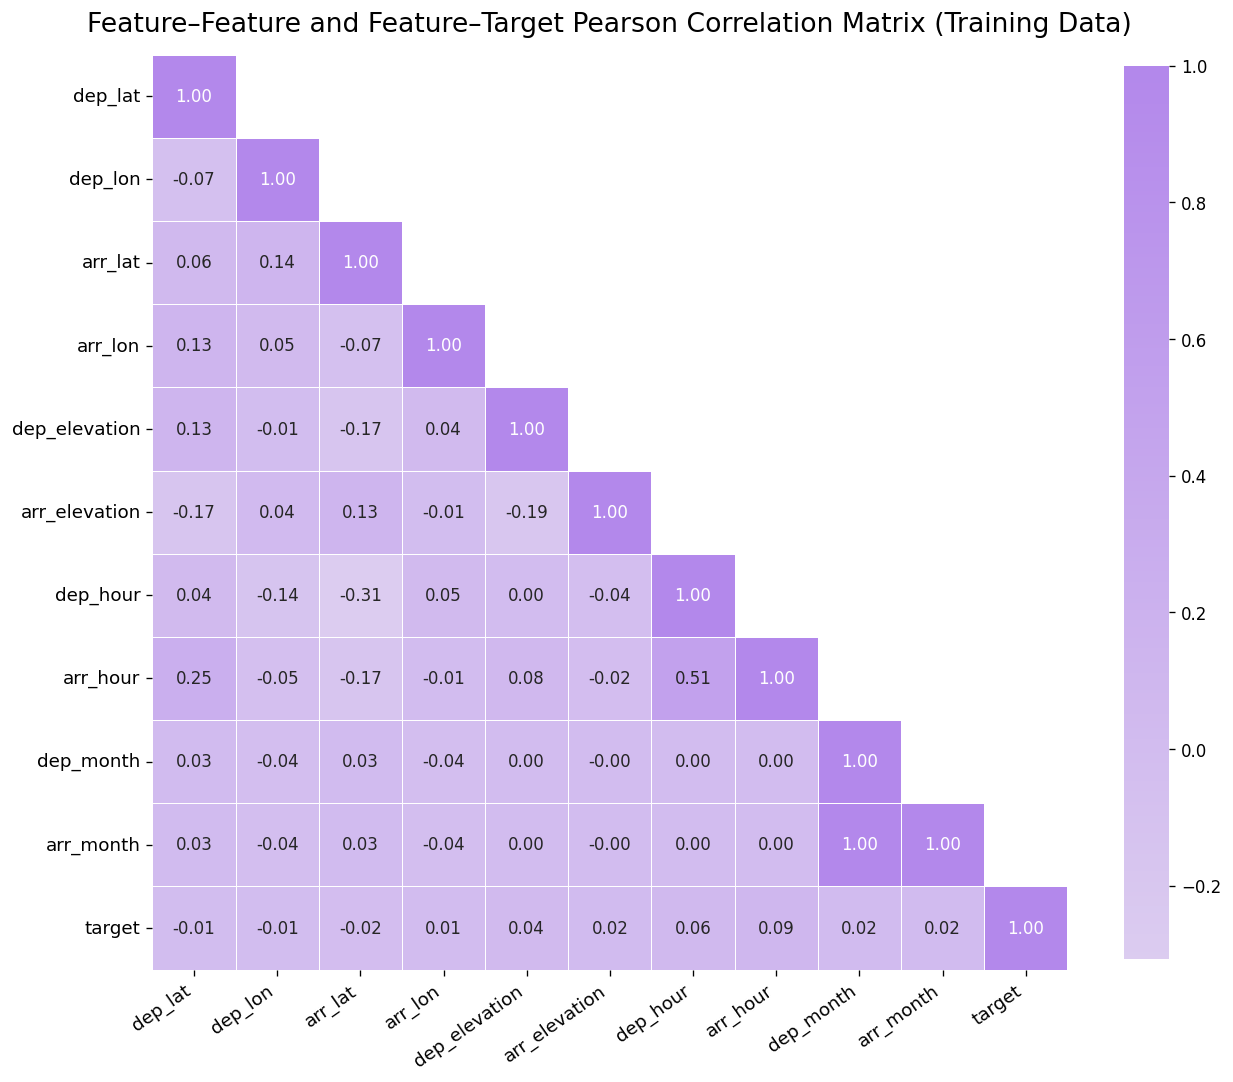

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------
# Correlation matrix
# ----------------------------

num_cols = [
    "dep_lat", "dep_lon",
    "arr_lat", "arr_lon",
    "dep_elevation", "arr_elevation",
    "dep_hour", "arr_hour",
    "dep_month", "arr_month",
    "target"
]

corr = train_df_eda[num_cols].corr()

# Mask upper triangle (keep lower half only)
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

# Purple theme (your project color)
cmap = sns.light_palette("#B388EB", as_cmap=True)

# ----------------------------
# Plot
# ----------------------------

fig, ax = plt.subplots(figsize=(11, 10), dpi=120)

sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    annot=True,              # KEEP NUMBERS ✅
    fmt=".2f",
    annot_kws={"size": 10},  # bigger numbers (readable)
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    ax=ax
)

# Clean borders
for spine in ax.spines.values():
    spine.set_visible(False)

# Rotate labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=35, ha="right", fontsize=11)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=11)

ax.set_title(
    "Feature–Feature and Feature–Target Pearson Correlation Matrix (Training Data)",
    fontsize=16,
    pad=14
)

plt.tight_layout()
plt.show()


#### 5.7.2 Delay vs Time-Based Features

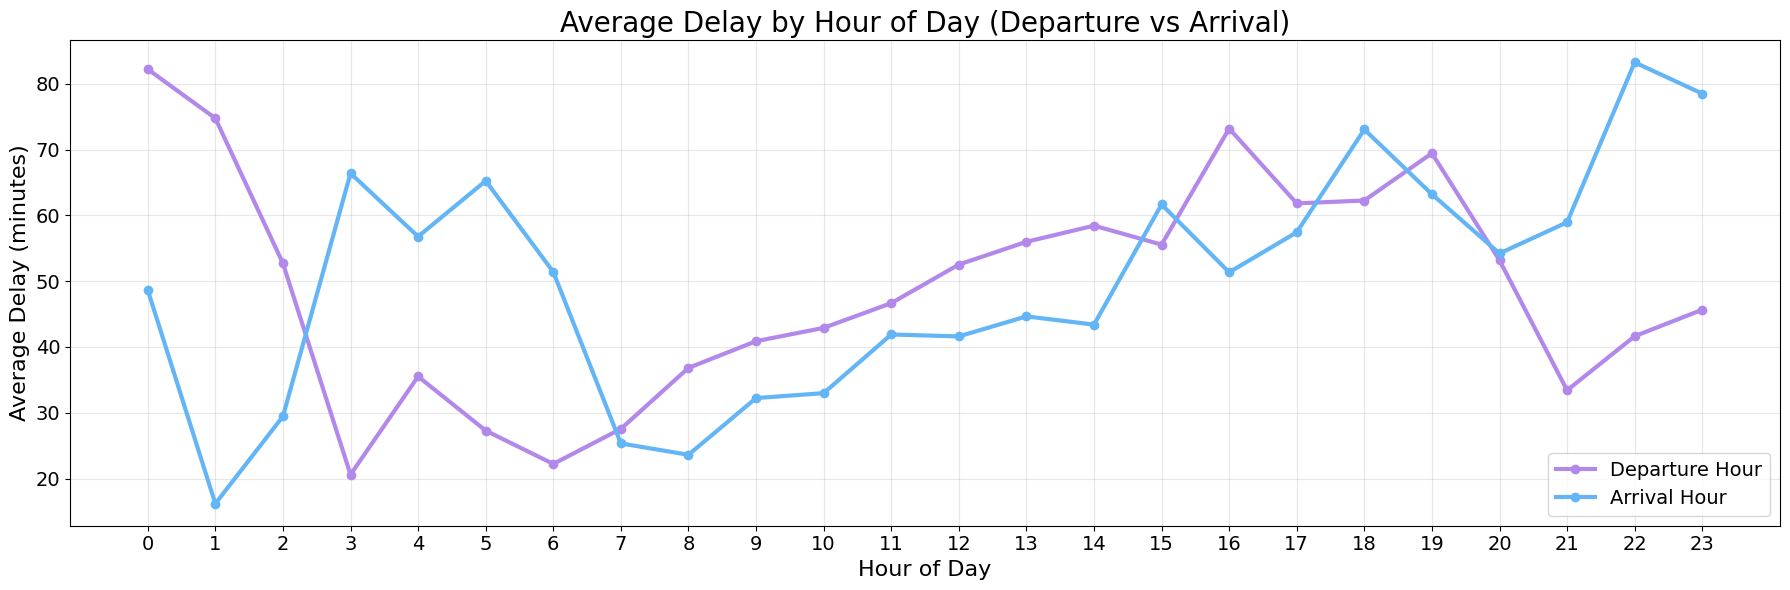

In [61]:
# ----------------------------
# Average delay by departure hour vs arrival hour
# ----------------------------

avg_delay_dep_hour = (
    train_df_eda
    .groupby("dep_hour")["target"]
    .mean()
)

avg_delay_arr_hour = (
    train_df_eda
    .groupby("arr_hour")["target"]
    .mean()
)

plt.figure(figsize=(18, 6))

# Departure line
plt.plot(
    avg_delay_dep_hour.index,
    avg_delay_dep_hour.values,
    marker="o",
    linewidth=3,
    color="#B388EB",
    label="Departure Hour"
)

# Arrival line
plt.plot(
    avg_delay_arr_hour.index,
    avg_delay_arr_hour.values,
    marker="o",
    linewidth=3,
    color="#64B5F6",
    label="Arrival Hour"
)

plt.title("Average Delay by Hour of Day (Departure vs Arrival)", fontsize=20)
plt.xlabel("Hour of Day", fontsize=16)
plt.ylabel("Average Delay (minutes)", fontsize=16)

plt.xticks(range(0, 24), fontsize=14)
plt.yticks(fontsize=14)

plt.grid(alpha=0.3)
plt.legend(fontsize=14)

plt.tight_layout()
plt.show()


**Observation**

Average delay shows a strong non-linear dependence on time of day for both departure and arrival hours.
Early morning departures (approximately 03:00–06:00) exhibit the lowest average delays, indicating relatively uncongested airport operations during off-peak hours.

However, arrival delays during the same early morning window remain comparatively higher, suggesting that arrival performance is influenced not only by local airport conditions but also by upstream delays accumulated from previous flight segments and overnight operations.

Delays increase steadily throughout the day and peak during late afternoon and early evening (approximately 16:00–19:00), which likely reflects growing traffic volume, operational congestion, and cascading delays across the network.

Overall, the distinct yet related temporal patterns observed for departure and arrival hours confirm that both features capture complementary time-dependent information and should be retained as important predictors in the delay modeling stage.


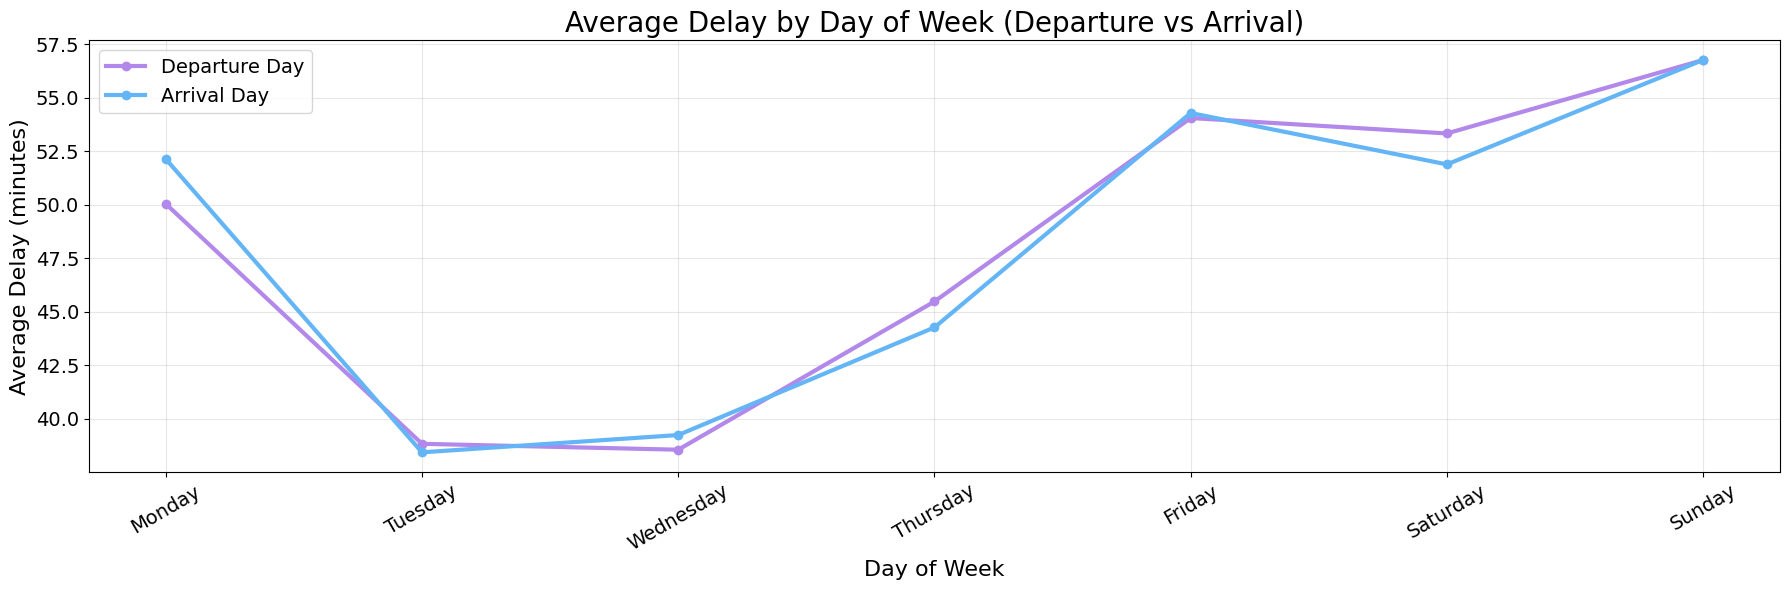

In [62]:
import matplotlib.pyplot as plt

# ----------------------------
# Average delay by day of week (Departure vs Arrival)
# ----------------------------

day_order = ["Monday", "Tuesday", "Wednesday", "Thursday",
             "Friday", "Saturday", "Sunday"]

avg_delay_dep_day = (
    train_df_eda
    .groupby("dep_day")["target"]
    .mean()
    .reindex(day_order)
)

avg_delay_arr_day = (
    train_df_eda
    .groupby("arr_day")["target"]
    .mean()
    .reindex(day_order)
)

# ----------------------------
# Plot
# ----------------------------

plt.figure(figsize=(18, 6))

# Departure
plt.plot(
    avg_delay_dep_day.index,
    avg_delay_dep_day.values,
    marker="o",
    linewidth=3,
    color="#B388EB",
    label="Departure Day"
)

# Arrival
plt.plot(
    avg_delay_arr_day.index,
    avg_delay_arr_day.values,
    marker="o",
    linewidth=3,
    color="#64B5F6",
    label="Arrival Day"
)

plt.title("Average Delay by Day of Week (Departure vs Arrival)", fontsize=20)
plt.xlabel("Day of Week", fontsize=16)
plt.ylabel("Average Delay (minutes)", fontsize=16)

plt.xticks(rotation=30, fontsize=14)
plt.yticks(fontsize=14)

plt.grid(alpha=0.3)
plt.legend(fontsize=14)

plt.tight_layout()
plt.show()


**Observation — Average Delay by Day of Week (Departure vs Arrival)**

Average delay exhibits a clear weekly pattern for both departure and arrival days.
The lowest average delays are observed on Tuesday and Wednesday, indicating more stable and less congested operations during midweek periods.

From Thursday onward, average delays increase steadily and reach their highest levels during Friday, Saturday, and especially Sunday.
This pattern is likely driven by higher passenger demand, increased flight frequency, and accumulated operational congestion during weekend peak travel periods.

The departure and arrival curves follow very similar trends across all weekdays, suggesting that the day-of-week effect is systemic and impacts the entire flight network rather than isolated operational stages.

Overall, the strong and consistent temporal structure confirms that day-of-week is a highly informative temporal feature and should be retained for downstream modeling.

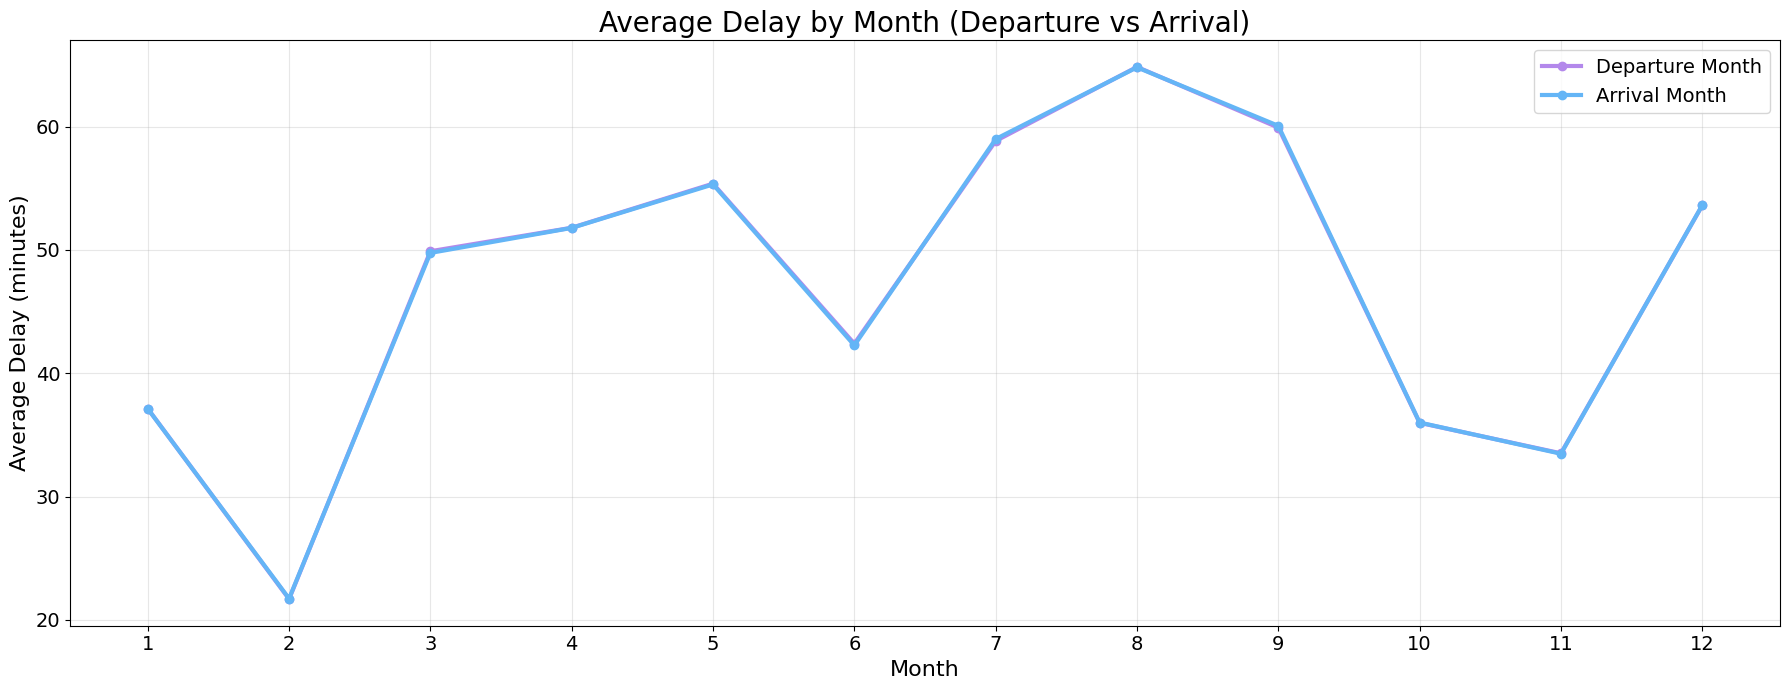

In [63]:

# ----------------------------
# Average delay by month (Departure vs Arrival)
# ----------------------------

months = range(1, 13)

dep_month_avg = (
    train_df_eda
    .groupby("dep_month")["target"]
    .mean()
    .reindex(months)
)

arr_month_avg = (
    train_df_eda
    .groupby("arr_month")["target"]
    .mean()
    .reindex(months)
)

# ----------------------------
# Plot
# ----------------------------

plt.figure(figsize=(18, 7))

plt.plot(
    months,
    dep_month_avg,
    marker="o",
    color="#B388EB",
    linewidth=3,
    label="Departure Month"
)

plt.plot(
    months,
    arr_month_avg,
    marker="o",
    color="#64B5F6",
    linewidth=3,
    label="Arrival Month"
)

plt.title("Average Delay by Month (Departure vs Arrival)", fontsize=20)
plt.xlabel("Month", fontsize=16)
plt.ylabel("Average Delay (minutes)", fontsize=16)

plt.xticks(months, fontsize=14)
plt.yticks(fontsize=14)

plt.grid(alpha=0.3)
plt.legend(fontsize=14)

plt.tight_layout()
plt.show()


**Observation**

Average delay exhibits a clear seasonal pattern across the year. Both **departure** and **arrival** curves almost completely overlap, indicating that monthly effects impact the entire flight pipeline in a highly consistent manner.

Delays are lowest during winter months, particularly in **February**, and gradually increase toward late spring and summer. The highest average delays occur during **July and August**, which likely reflects peak travel demand, increased air traffic congestion, and seasonal operational constraints.

After the summer peak, delays decrease noticeably during autumn (**October–November**), followed by a moderate increase again in **December**, potentially driven by holiday travel demand.

The strong alignment between departure and arrival monthly trends suggests systematic delay propagation across flight operations. Therefore, **month** represents a meaningful seasonal feature with strong predictive signal and should be retained for modeling.


#### 5.7.3 Delay vs Spatial Features (Airports & Geography)

**5.7.3.1 Average Delay by Top Busiest Departure Airports**  

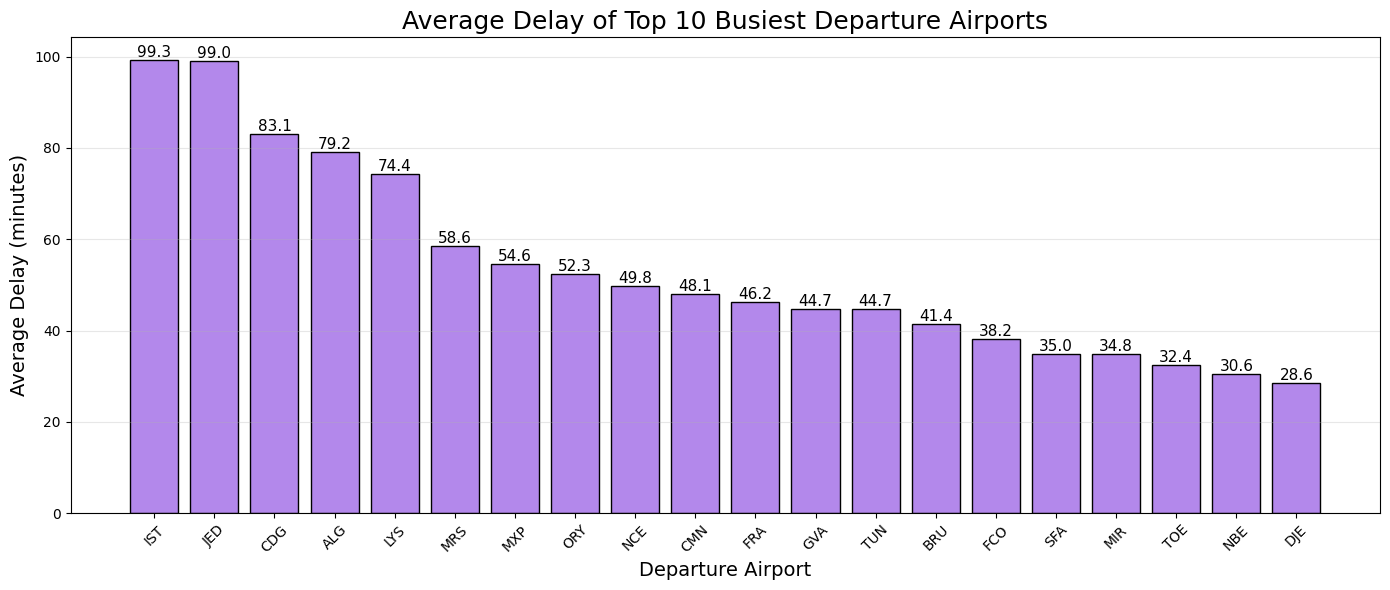

In [64]:
import matplotlib.pyplot as plt

# ----------------------------
# Select top 10 busiest departure airports
# ----------------------------

top_dep_airports = train_df_eda["DEPSTN"].value_counts().head(20).index

dep_delay_avg = (
    train_df_eda[train_df_eda["DEPSTN"].isin(top_dep_airports)]
    .groupby("DEPSTN")["target"]
    .mean()
    .sort_values(ascending=False)
)

# ----------------------------
# Plot
# ----------------------------

plt.figure(figsize=(14, 6))

bars = plt.bar(
    dep_delay_avg.index,
    dep_delay_avg.values,
    color="#B388EB",
    edgecolor="black"
)

# ----------------------------
# Add average delay labels on top
# ----------------------------

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:.1f}",
        ha="center",
        va="bottom",
        fontsize=11
    )

plt.title("Average Delay of Top 10 Busiest Departure Airports", fontsize=18)
plt.xlabel("Departure Airport", fontsize=14)
plt.ylabel("Average Delay (minutes)", fontsize=14)

plt.xticks(rotation=45)
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()


**5.7.3.2 Average Delay by Top Busiest Arrival Airports**  

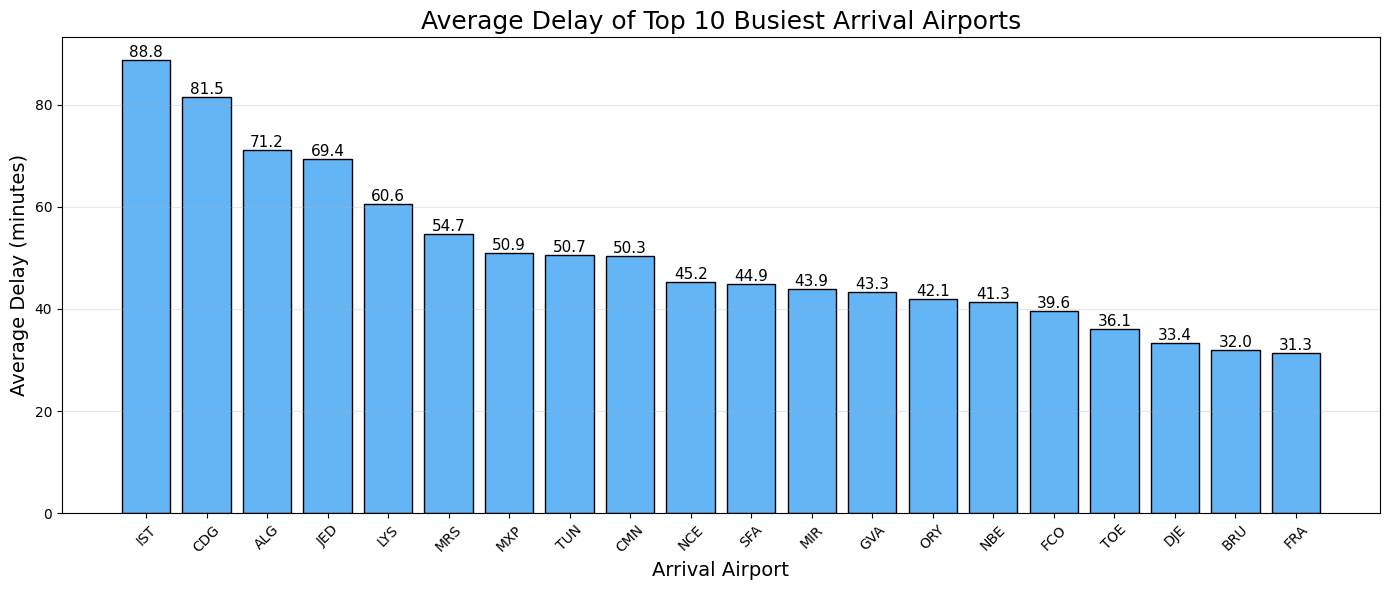

In [65]:
import matplotlib.pyplot as plt

# ----------------------------
# Select top 10 busiest arrival airports
# ----------------------------

top_arr_airports = train_df_eda["ARRSTN"].value_counts().head(20).index

arr_delay_avg = (
    train_df_eda[train_df_eda["ARRSTN"].isin(top_arr_airports)]
    .groupby("ARRSTN")["target"]
    .mean()
    .sort_values(ascending=False)
)

# ----------------------------
# Plot
# ----------------------------

plt.figure(figsize=(14, 6))

bars = plt.bar(
    arr_delay_avg.index,
    arr_delay_avg.values,
    color="#64B5F6",
    edgecolor="black"
)

# ----------------------------
# Add average delay labels on top
# ----------------------------

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:.1f}",
        ha="center",
        va="bottom",
        fontsize=11
    )

plt.title("Average Delay of Top 10 Busiest Arrival Airports", fontsize=18)
plt.xlabel("Arrival Airport", fontsize=14)
plt.ylabel("Average Delay (minutes)", fontsize=14)

plt.xticks(rotation=45)
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()


**Observation**

Average delay varies substantially across the busiest departure and arrival airports, indicating strong spatial heterogeneity in delay behavior.

Airports such as IST and ALG consistently exhibit the highest average delays for both departures and arrivals, while airports like DJE, MIR, and ORY show comparatively lower delay levels.

The strong overlap between high-delay airports in both departure and arrival perspectives suggests that part of the delay pattern is driven by airport-specific operational characteristics (e.g., traffic volume, congestion, infrastructure constraints), rather than purely flight-level randomness.

Overall, origin and destination airport identifiers represent important spatial features and should be retained as predictive inputs for delay modeling.

**5.7.3.3 Delay vs Geographic Coordinates (Latitude / Longitude)**


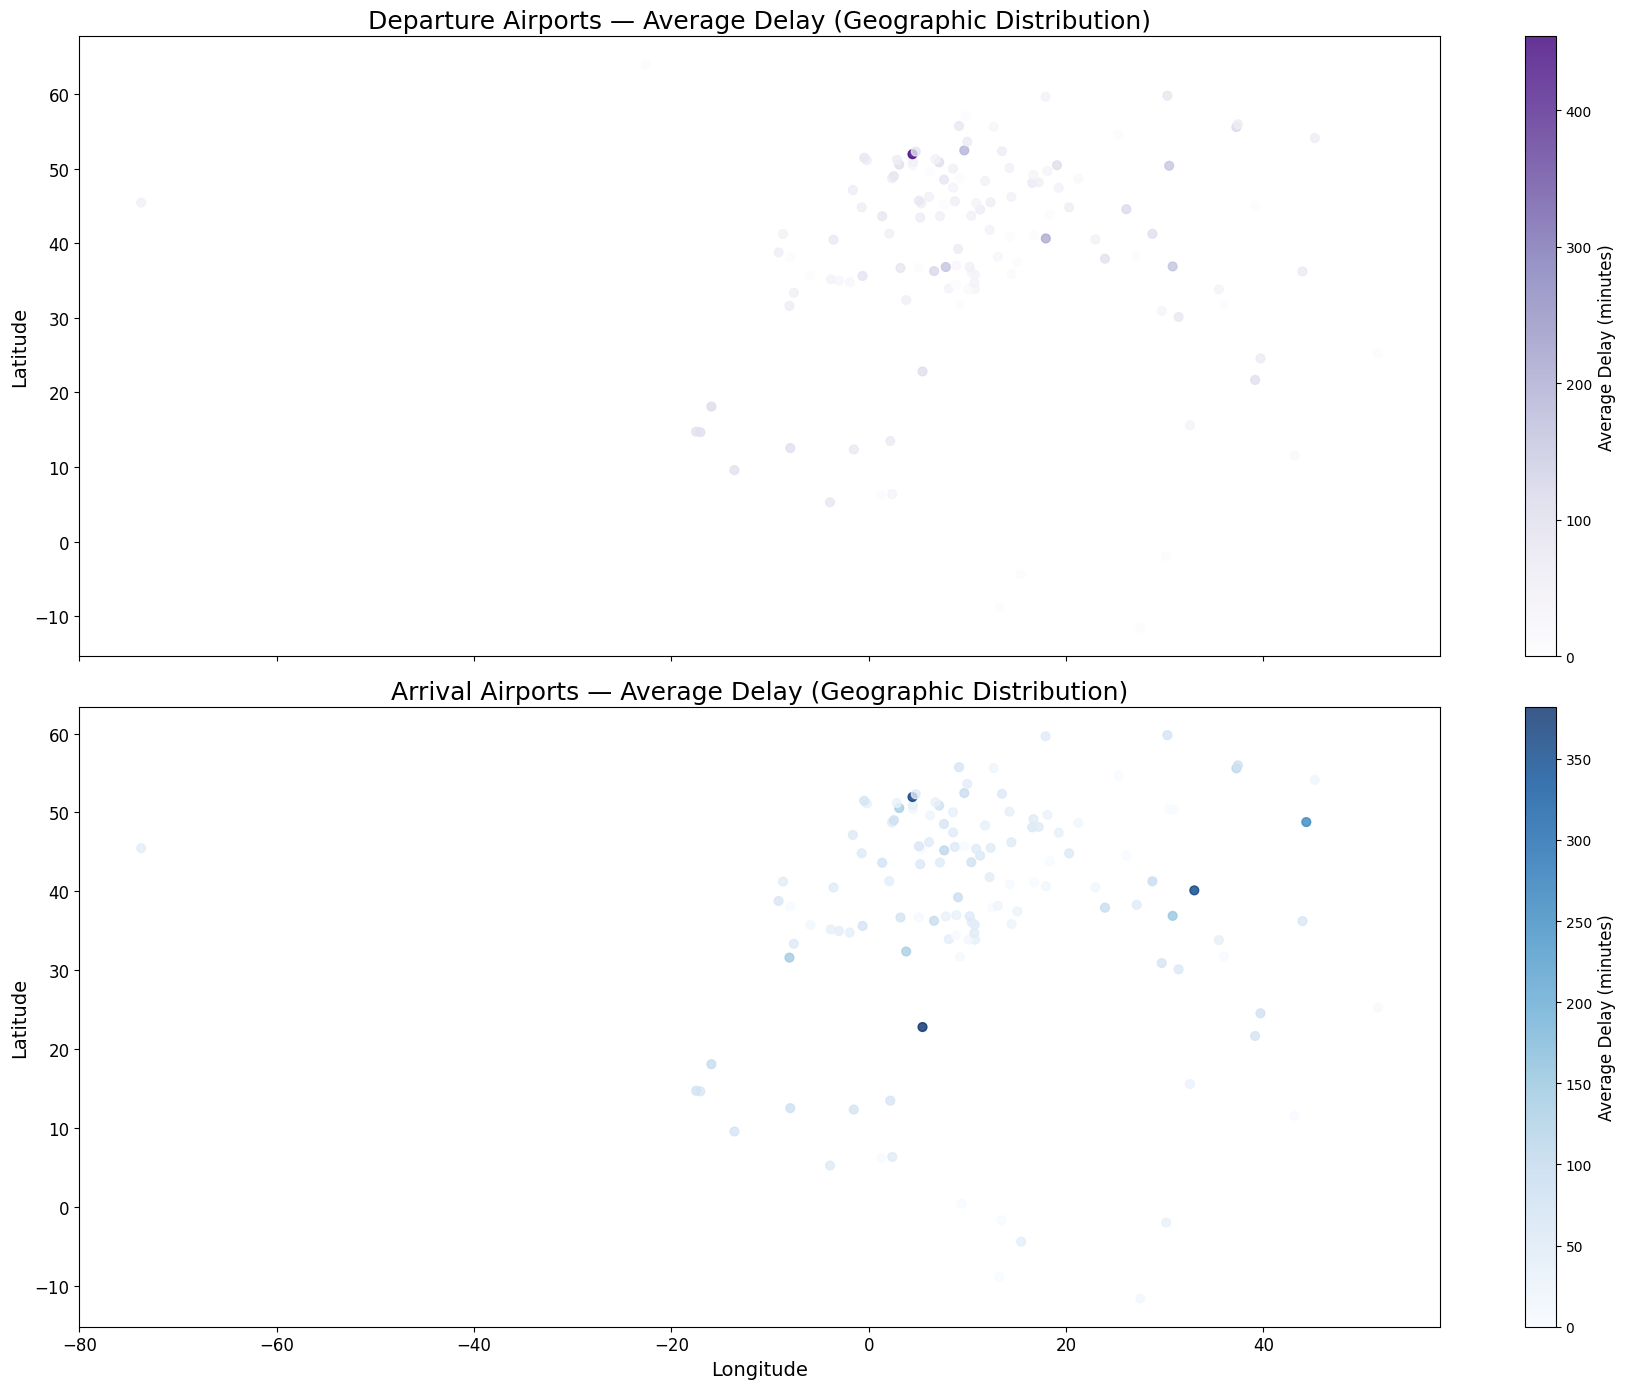

In [66]:
import matplotlib.pyplot as plt

# ----------------------------
# Prepare aggregated spatial delay data
# ----------------------------

# Departure airports: average delay per coordinate
dep_geo_delay = (
    train_df_eda
    .groupby(["dep_lat", "dep_lon"])["target"]
    .mean()
    .reset_index()
)

# Arrival airports: average delay per coordinate
arr_geo_delay = (
    train_df_eda
    .groupby(["arr_lat", "arr_lon"])["target"]
    .mean()
    .reset_index()
)

# ----------------------------
# Plot spatial scatter maps
# ----------------------------

fig, axes = plt.subplots(2, 1, figsize=(18, 14), sharex=True)

# ---- Departure scatter ----
sc1 = axes[0].scatter(
    dep_geo_delay["dep_lon"],
    dep_geo_delay["dep_lat"],
    c=dep_geo_delay["target"],
    cmap="Purples",
    s=40,
    alpha=0.8
)

axes[0].set_title("Departure Airports — Average Delay (Geographic Distribution)", fontsize=18)
axes[0].set_ylabel("Latitude", fontsize=14)
axes[0].tick_params(axis="both", labelsize=12)

cbar1 = plt.colorbar(sc1, ax=axes[0])
cbar1.set_label("Average Delay (minutes)", fontsize=12)

# ---- Arrival scatter ----
sc2 = axes[1].scatter(
    arr_geo_delay["arr_lon"],
    arr_geo_delay["arr_lat"],
    c=arr_geo_delay["target"],
    cmap="Blues",
    s=40,
    alpha=0.8
)

axes[1].set_title("Arrival Airports — Average Delay (Geographic Distribution)", fontsize=18)
axes[1].set_xlabel("Longitude", fontsize=14)
axes[1].set_ylabel("Latitude", fontsize=14)
axes[1].tick_params(axis="both", labelsize=12)

cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label("Average Delay (minutes)", fontsize=12)

plt.tight_layout()
plt.show()


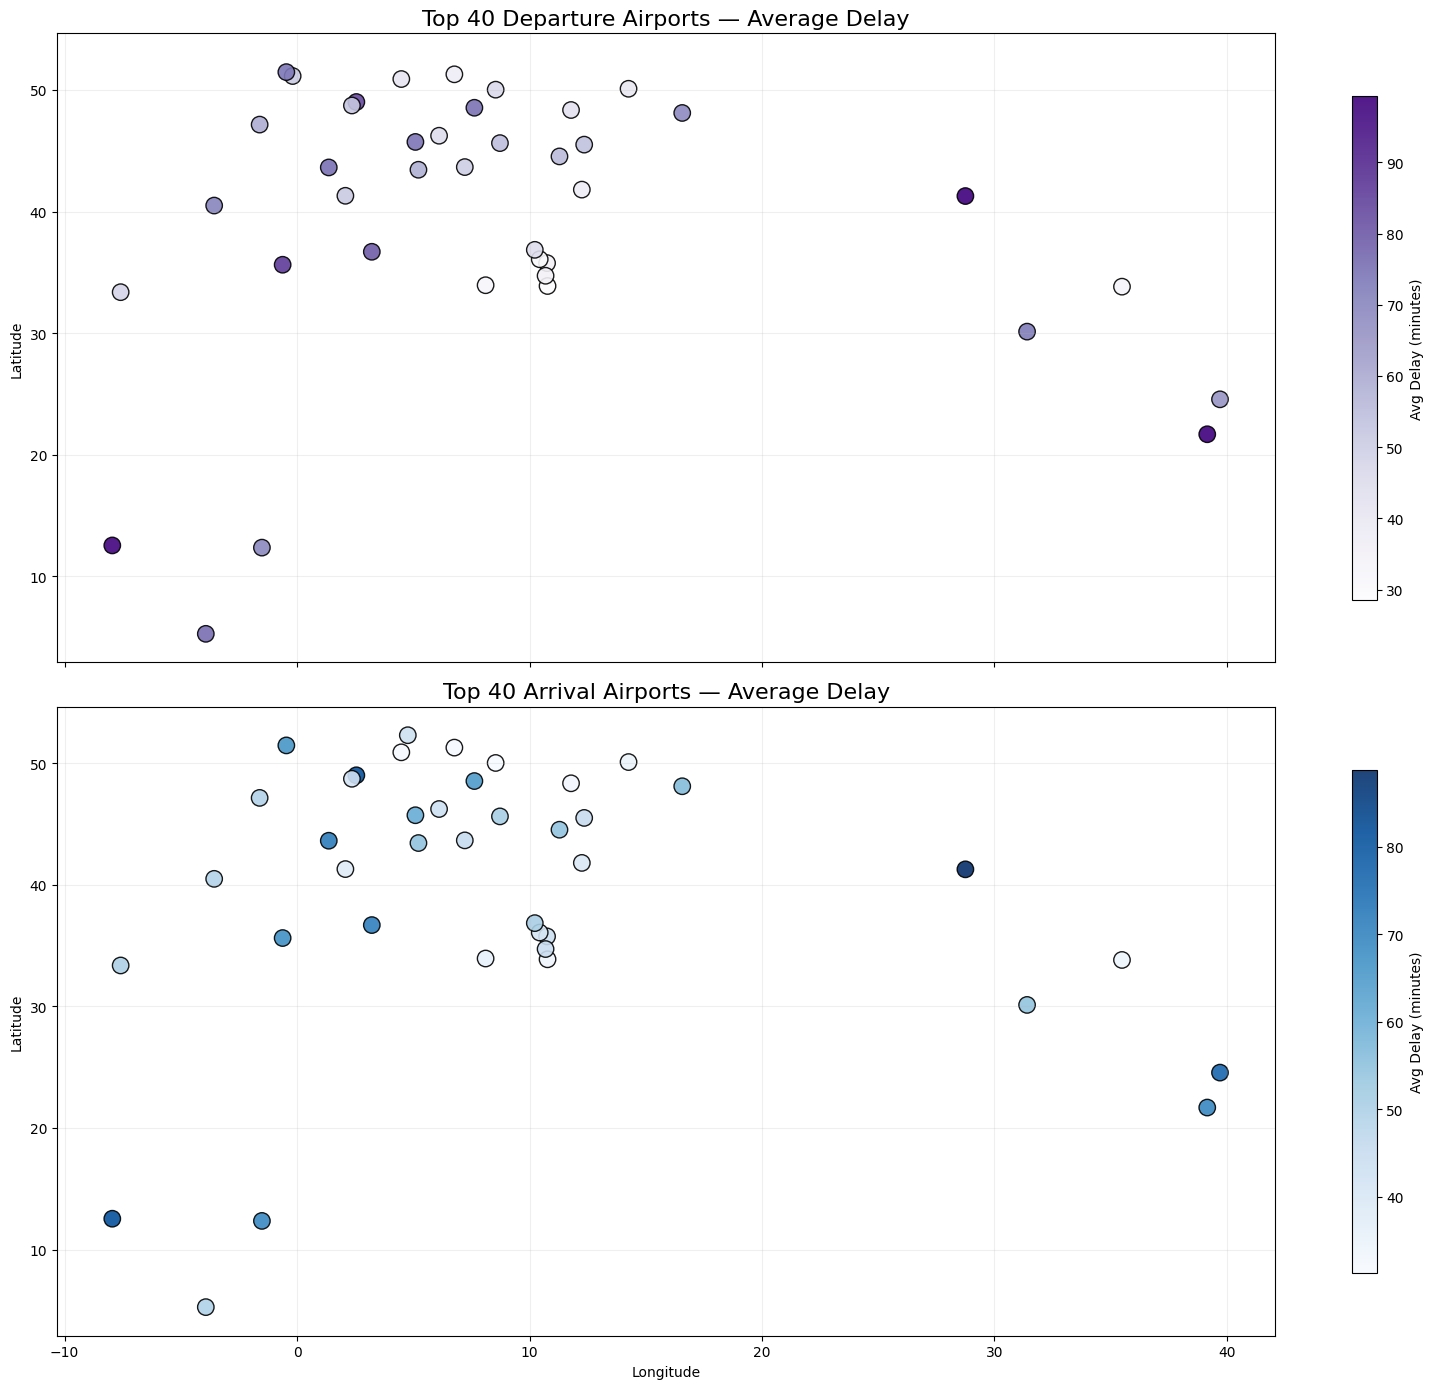

In [67]:
import matplotlib.pyplot as plt

# ----------------------------
# Top 40 busiest departure airports
# ----------------------------

top_dep = (
    train_df_eda["dep_iata"]
    .value_counts()
    .head(40)
    .index
)

dep_geo = (
    train_df_eda[train_df_eda["dep_iata"].isin(top_dep)]
    .groupby("dep_iata")
    .agg({
        "dep_lat": "mean",
        "dep_lon": "mean",
        "target": "mean"
    })
    .reset_index()
)

# ----------------------------
# Top 40 busiest arrival airports
# ----------------------------

top_arr = (
    train_df_eda["arr_iata"]
    .value_counts()
    .head(40)
    .index
)

arr_geo = (
    train_df_eda[train_df_eda["arr_iata"].isin(top_arr)]
    .groupby("arr_iata")
    .agg({
        "arr_lat": "mean",
        "arr_lon": "mean",
        "target": "mean"
    })
    .reset_index()
)

# ----------------------------
# Plot vertical layout
# ----------------------------

fig, axes = plt.subplots(2, 1, figsize=(16, 14), sharex=True, sharey=True)

# Departure map
sc1 = axes[0].scatter(
    dep_geo["dep_lon"],
    dep_geo["dep_lat"],
    c=dep_geo["target"],
    cmap="Purples",
    s=140,
    alpha=0.9,
    edgecolor="black"
)

axes[0].set_title("Top 40 Departure Airports — Average Delay", fontsize=16)
axes[0].set_ylabel("Latitude")
axes[0].grid(alpha=0.2)

# Arrival map
sc2 = axes[1].scatter(
    arr_geo["arr_lon"],
    arr_geo["arr_lat"],
    c=arr_geo["target"],
    cmap="Blues",
    s=140,
    alpha=0.9,
    edgecolor="black"
)

axes[1].set_title("Top 40 Arrival Airports — Average Delay", fontsize=16)
axes[1].set_xlabel("Longitude")
axes[1].set_ylabel("Latitude")
axes[1].grid(alpha=0.2)

# Colorbars
plt.colorbar(sc1, ax=axes[0], shrink=0.8, label="Avg Delay (minutes)")
plt.colorbar(sc2, ax=axes[1], shrink=0.8, label="Avg Delay (minutes)")

plt.tight_layout()
plt.show()


## 6. Target Transformation

### 6.1 Target Distribution Characteristics

Exploratory analysis showed that the delay duration target variable is highly right-skewed with a long tail of extreme delay values.  
Such skewness can negatively affect regression model stability and error optimization.

Therefore, a logarithmic transformation is applied to stabilize variance and reduce the influence of extreme outliers.


### 6.2 Log Transformation of Target Variable

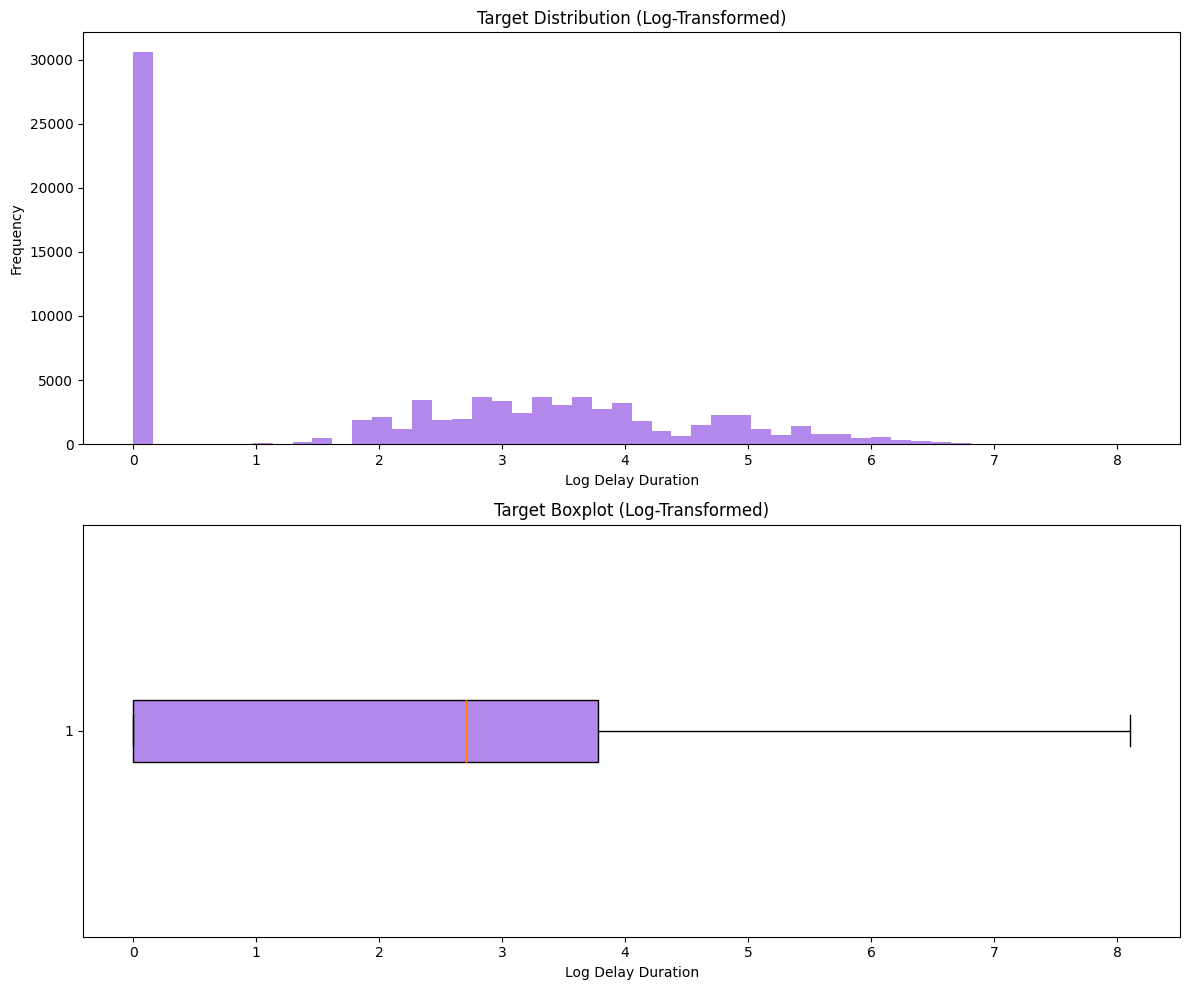

In [68]:

# ----------------------------
# Apply log transformation to target
# ----------------------------

train_df_eda["target_log"] = np.log1p(train_df_eda["target"])

# ----------------------------
# Visualize transformed target distribution
# ----------------------------

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Histogram
axes[0].hist(train_df_eda["target_log"], bins=50, color="#B388EB")
axes[0].set_title("Target Distribution (Log-Transformed)")
axes[0].set_xlabel("Log Delay Duration")
axes[0].set_ylabel("Frequency")

# Boxplot
axes[1].boxplot(
    train_df_eda["target_log"],
    vert=False,
    patch_artist=True,
    boxprops=dict(facecolor="#B388EB")
)
axes[1].set_title("Target Boxplot (Log-Transformed)")
axes[1].set_xlabel("Log Delay Duration")

plt.tight_layout()
plt.show()


In [69]:
(y_train == 0).mean()

0.35461247768529897

### Observation — Target Distribution After Log Transformation

After applying a log transformation to the delay target (`log1p(delay)`), the distribution remains heavily concentrated at zero.

This is expected, as a substantial fraction of flights have **exactly zero delay** (≈35%), and `log1p(0) = 0`.  
As a result, the log transformation reduces skewness among delayed flights but **does not remove the structural mass at zero**.

This indicates that the target exhibits a **zero-inflated continuous structure**, combining:
- a no-delay regime (delay = 0)
- a positive-delay regime with a right-skewed distribution

This characteristic limits the performance of standard regression models and suggests that delay prediction may not be well-represented as a single continuous regression problem.


## 7. Feature Engineering

In [70]:
train_df_eda.columns

Index(['ID', 'DATOP', 'FLTID', 'DEPSTN', 'ARRSTN', 'STD', 'STA', 'STATUS',
       'AC', 'dep_icao', 'dep_iata', 'dep_name', 'dep_city', 'dep_subd',
       'dep_country', 'dep_elevation', 'dep_lat', 'dep_lon', 'dep_tz',
       'dep_lid', 'arr_icao', 'arr_iata', 'arr_name', 'arr_city', 'arr_subd',
       'arr_country', 'arr_elevation', 'arr_lat', 'arr_lon', 'arr_tz',
       'arr_lid', 'target', 'DATOP_dt', 'STA_dt', 'STD_dt', 'dep_hour',
       'arr_hour', 'dep_day', 'arr_day', 'dep_month', 'arr_month',
       'target_log'],
      dtype='object')

### 7.1 Feature Cleaning & Removal Rationale

This section documents feature removal decisions applied **prior to feature engineering and preprocessing**.
The focus is on eliminating structurally uninformative, identifier-like, or redundant features, based on earlier EDA findings (Section 5).


#### 7.1.1 Constant / Non-Informative Features

The columns `dep_lid` and `arr_lid` contain 100% missing values across the training data.
As these features are entirely unobserved rather than partially missing, they are considered structurally non-informative.

**Decision:**  
- Remove `dep_lid` and `arr_lid` from the modeling pipeline.


#### 7.1.2 Identifier-like Features

Several features serve exclusively as record-level or administrative identifiers and do not encode predictive information.

- `ID` uniquely identifies individual rows.
- `FLTID` represents an operational reference with mixed and unstructured semantics.

While such identifiers may be useful for traceability or exploratory analysis, their raw values are not suitable for direct model input.

**Decision:**  
- Exclude `ID` and `FLTID` from modeling.  
- Retain them only for EDA, auditing, and potential downstream feature extraction.



#### 7.1.3 High-Missingness Features

Most features exhibit no or negligible missingness.
The columns `dep_subd` and `arr_subd` show a low missing rate (~1.8–1.9%), which does not justify removal at this stage.

**Decision:**  
- Retain `dep_subd` and `arr_subd` as optional categorical features.  
- Their usefulness will be evaluated later during feature selection and model-specific preprocessing.


#### 7.1.4 Redundant Feature Removal (Feature–Feature Decisions)

Redundancy-related feature removal decisions were finalized based on the semantic and structural analyses conducted in Section 5.6.
This subsection summarizes **execution-level decisions only**, without repeating earlier justification.

##### Temporal features
- Retain: `dep_hour`, `dep_day`, `dep_month`
- Remove: `arr_hour`, `arr_day`, `arr_month`
- Raw timestamps (`STD`, `STA`, `DATOP`) removed after deterministic feature extraction

##### Geographic and spatial features
- Retain (mutually exclusive spatial representations):
  - **Option A (country-level):** `dep_country`, `arr_country`
  - **Option B (station-level):** `DEPSTN`, `ARRSTN`
- Retain (route-level): `route_distance_km`
- Remove: `dep_lat`, `dep_lon`, `arr_lat`, `arr_lon`
- Remove: `dep_city`, `arr_city`, `dep_name`, `arr_name`
- Remove: `dep_iata`, `arr_iata`, `dep_icao`, `arr_icao`
- Remove: `dep_tz`, `arr_tz`

##### Elevation
- Retain: `dep_elevation`
- Remove: `arr_elevation`

##### Operational status
- Retain: `STATUS`

**Note:**  
Country-level and station-level spatial encodings are not used simultaneously to avoid redundant geographic representations and route memorization effects.



#### Summary

Feature removal decisions in this section aim to:
- eliminate structurally uninformative and identifier-only fields,
- reduce redundancy across temporal and geographic representations,
- and establish a clean, well-defined input space for deterministic feature construction (Section 7.2).

No feature removal decisions in this section are based on model performance.


### 7.2 Deterministic Feature Construction

Deterministic features are features that can be derived directly and consistently from the raw input data, without using target information or relying on model-specific assumptions.
They are fully defined by known attributes such as the flight schedule, geographic context, and route structure.

Because these features do not depend on historical delay outcomes, they can be safely constructed prior to model training and evaluation.
This ensures that feature construction remains reproducible, leakage-free, and independent of the chosen modeling approach.

#### 7.2.1 Temporal Features

Exploratory analysis revealed clear temporal patterns in flight delay behavior.
Based on these observations, calendar-based features such as **departure hour**, **arrival hour**, **day of the week**, and **month** are formally included as deterministic features.

These features are derived directly from scheduled departure and arrival timestamps.
They capture systematic temporal effects, including daily cycles, weekday versus weekend differences, and seasonal variation, without introducing temporal dependence between observations.


#### 7.2.2 Geographic Features

Geographic features describe where a flight operates in physical and regional terms.
They are based on the location of the departure and arrival airports and capture differences in geography that may influence flight operations.

For each origin and destination airport, these features include latitude and longitude (to describe position on the globe), elevation (to reflect altitude-related conditions), country (to capture regional and regulatory context), and time zone (to reflect local operational timing).

Together, these features provide basic information about the geographic environment in which a flight takes place.
They do not rely on past delay outcomes and therefore can be safely constructed before model training without introducing information leakage.


#### 7.2.3 Route-Level Features

Route-level features describe properties of a flight that depend on the combination of the departure and arrival airports, rather than on each airport individually.
In other words, these features focus on the characteristics of the route itself.

Examples include whether a flight operates within the same country or crosses national borders, as well as how far the origin and destination airports are from each other.
Such information helps capture differences between short-haul and long-haul routes, as well as variations in operational complexity.

These features provide additional context about the nature of a flight route without using any historical delay information.
They are fully deterministic and can therefore be constructed safely before model training.

In [71]:
# ----------------------------------
# 7.2.3 Route-Level Feature Construction
# ----------------------------------

# ----------------------------------
# Helper function: Haversine distance
# ----------------------------------
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Compute great-circle distance between two points on Earth (in kilometers)
    using the Haversine formula.
    """
    # Earth radius in kilometers
    R = 6371.0

    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = (
        np.sin(dlat / 2.0) ** 2
        + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
    )
    c = 2 * np.arcsin(np.sqrt(a))

    return R * c


# ----------------------------------
# 1. Domestic vs International route
# ----------------------------------
# 1 if departure and arrival countries are the same, else 0
train_df_eda["is_domestic"] = (
    train_df_eda["dep_country"] == train_df_eda["arr_country"]
).astype(int)


# ----------------------------------
# 2. Route distance (km)
# ----------------------------------
train_df_eda["route_distance_km"] = haversine_distance(
    train_df_eda["dep_lat"],
    train_df_eda["dep_lon"],
    train_df_eda["arr_lat"],
    train_df_eda["arr_lon"],
)


# ----------------------------------
# Sanity check
# ----------------------------------
train_df_eda[["is_domestic", "route_distance_km"]].describe()


,is_domestic,route_distance_km
count,86266.000000,86266.000000
mean,0.176559,1281.743959
std,0.381297,884.332335
min,0.000000,0.000000
25%,0.000000,798.765483
50%,0.000000,1262.514744
75%,0.000000,1663.643801
max,1.000000,6770.460906


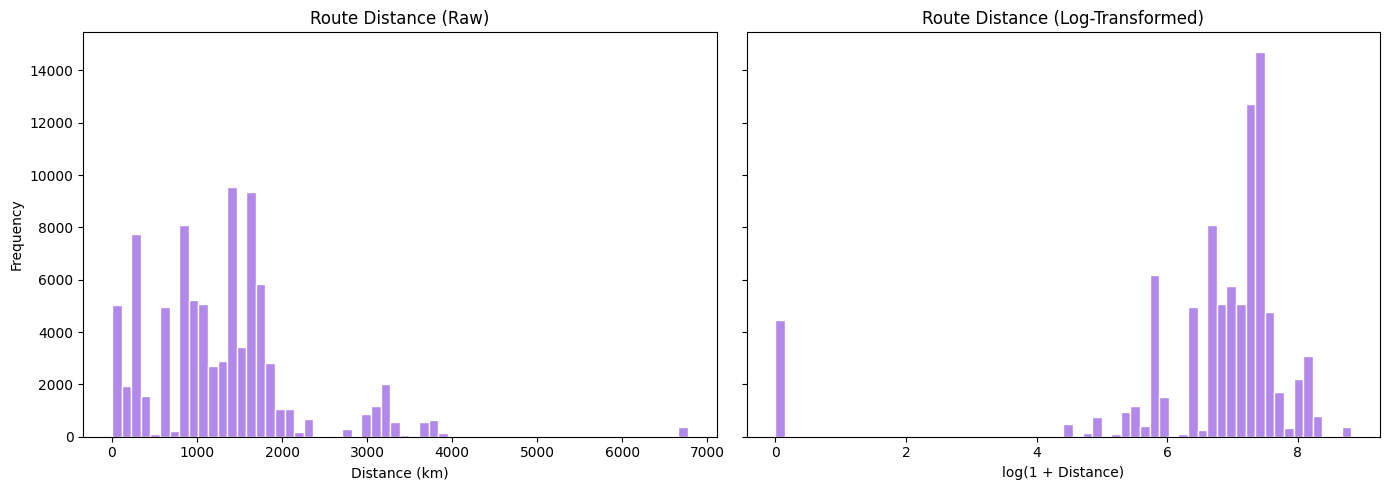

In [72]:
import numpy as np
import matplotlib.pyplot as plt

# Use project color
MAIN_COLOR = "#B388EB"

# Raw feature
x_raw = train_df_eda["route_distance_km"]

# Log-transformed feature
x_log = np.log1p(x_raw)

# --------------------------------------------------
# Plot side-by-side
# --------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Raw distribution
axes[0].hist(x_raw, bins=60, color=MAIN_COLOR, edgecolor="white")
axes[0].set_title("Route Distance (Raw)")
axes[0].set_xlabel("Distance (km)")
axes[0].set_ylabel("Frequency")

# Log-transformed distribution
axes[1].hist(x_log, bins=60, color=MAIN_COLOR, edgecolor="white")
axes[1].set_title("Route Distance (Log-Transformed)")
axes[1].set_xlabel("log(1 + Distance)")

plt.tight_layout()
plt.show()


## 8. Preprocessing and Modeling Pipelines

### 8.1 Preprocessing Strategy Overview

This section defines the overall preprocessing strategy used in the modeling phase.
A clear separation is maintained between **feature definition** and **feature processing** to ensure reproducibility, transparency, and to prevent data leakage.

Deterministic features are conceptually defined in earlier sections, while their actual construction and transformation are applied within preprocessing pipelines.
This approach guarantees that the same operations are consistently applied to training and validation data.

Preprocessing decisions are explicitly treated as **model-dependent**.
Different model families may require different handling of numerical scaling, categorical encoding, or feature inclusion, and these choices are reflected through modular pipeline design.

All preprocessing steps are implemented using scikit-learn pipelines and transformers.
This ensures a clean and reproducible workflow, enables fair model comparison, and prevents information from the validation or test sets from leaking into the training process.


### 8.2 Feature Grouping for Preprocessing

Before applying any preprocessing transformations, features are organized into conceptually coherent groups.
This grouping step defines *how* different types of features should be treated during preprocessing, without yet applying any transformations.

Features are grouped based on their data type, semantic meaning, and expected preprocessing requirements.
This structure enables flexible, model-specific preprocessing pipelines while keeping feature handling explicit and interpretable.

The following groups are defined:

* **Numerical features**, which may require scaling or transformation
* **Temporal features**, derived from scheduled timestamps
* **Categorical features**, separated by cardinality characteristics
* **Geographic and route-level features**, representing spatial and relational context

This grouping serves as the foundation for all subsequent preprocessing pipelines and ensures consistent feature handling across different model families.


#### 8.2.1 Numerical Features (Continuous)

This group includes numerical features that represent true continuous quantities, where arithmetic operations such as differences, averages, and scaling are meaningful.

In this project, the numerical feature group consists of physical and route-level measurements derived from airport and route characteristics, including:

- `dep_elevation`
- `route_distance_km`

These features have a natural metric structure and describe continuous properties of the operating environment and flight route geometry. They are therefore well suited for standard numerical preprocessing steps such as scaling or normalization.

Absolute geographic coordinates (`dep_lat`, `dep_lon`, `arr_lat`, `arr_lon`) and arrival elevation were intentionally excluded to avoid redundant spatial encodings, as spatial information is represented at the route level.

Temporal variables stored as numbers (e.g. `dep_hour`, `dep_month`) are **explicitly excluded** from this group, as they represent cyclic or ordinal information and require separate handling.


#### 8.2.2 Temporal Features (Cyclic / Ordinal)

Temporal features describe when a flight is scheduled to operate rather than measuring a physical quantity.
Although these features are represented numerically, their values do not imply linear or metric relationships.

In this project, the temporal feature group includes:

- `dep_hour`
- `dep_day`
- `dep_month`

The feature `dep_hour` is **cyclic** in nature, where the transition from 23 to 0 represents continuity rather than a large numeric jump.
Similarly, `dep_month` reflects seasonal structure rather than linear magnitude.

Arrival-based temporal features (`arr_hour`, `arr_day`, `arr_month`) were intentionally excluded to avoid redundancy and post-departure information leakage, as documented in Sections 5.6 and 7.1.

For this reason, temporal features are treated as a separate group and are excluded from standard numerical preprocessing.
Their representation and encoding strategy is deferred to the preprocessing pipeline and may vary depending on the model family (e.g. cyclic encoding for linear models or raw ordinal values for tree-based models).

At this stage, no aggregation or grouping (e.g. time-of-day buckets or seasonal bins) is applied to temporal features.
Such transformations are intentionally postponed to allow flexible, model-specific experimentation during the preprocessing and modeling phase.


#### 8.2.3 Geographic and Route-Level Features

This feature group includes attributes that describe the geographic context of a flight and the structural relationship between its departure and arrival locations.

In this project, geographic information is represented using **a single spatial abstraction level**, selected to avoid redundant encodings of location.

Depending on the chosen modeling strategy, one of the following mutually exclusive representations is used:

- **Country-level representation**
  - `dep_country`
  - `arr_country`

- **Station-level representation**
  - `DEPSTN`
  - `ARRSTN`

Country-level and station-level representations are not used simultaneously in order to prevent redundant geographic encoding and route memorization effects.

Time zone features (`dep_tz`, `arr_tz`) are excluded from this group, as temporal information is already captured through departure-based time features and route-level structure, and explicit time zone variables may introduce post-departure leakage.

Route-level features describe characteristics that arise from the combination of departure and arrival locations rather than from either airport alone.
In this project, spatial relationships between airports are encoded explicitly using:

- `route_distance_km`

This feature captures the geometric relationship between origin and destination and replaces the need for raw latitude and longitude coordinates.

All geographic and route-level features in this group are treated as categorical or continuous variables according to their semantic meaning and are processed separately from temporal and purely numerical feature groups.


#### 8.2.4 Categorical Features (Low vs High Cardinality)

Categorical features in this dataset vary substantially in their number of unique categories and frequency distributions.
To support appropriate preprocessing and encoding decisions, categorical variables are conceptually grouped into **low-cardinality** and **high-cardinality** feature sets.

##### Low-cardinality categorical features

Low-cardinality features are characterized by a small, stable set of categories with sufficient sample support per category.
These features are well suited for standard encoding techniques such as one-hot encoding and are unlikely to introduce excessive sparsity.

In this project, low-cardinality categorical features include:
- `STATUS`
- `is_domestic`

The feature `is_domestic` is a route-type indicator derived from the relationship between departure and arrival locations and captures whether a flight operates within a single country or crosses national borders.

##### High-cardinality categorical features

High-cardinality features contain a large number of unique categories and may exhibit long-tailed frequency distributions.
Such features require careful handling to avoid high-dimensional sparse representations and overfitting.

Depending on the selected spatial representation strategy, high-cardinality categorical features include **one** of the following mutually exclusive options:

- **Country-level representation**
  - `dep_country`
  - `arr_country`

- **Station-level representation**
  - `DEPSTN`
  - `ARRSTN`

Country-level and station-level representations are not used simultaneously in order to prevent redundant geographic encoding and route memorization effects.

##### Preprocessing strategy

At this stage, categorical features are grouped **conceptually only**.
No encoding or transformation is applied yet, as the final handling strategy depends on:
- the observed cardinality and sparsity in the training data,
- the selected model family,
- and the structure of the preprocessing pipeline.

Potential handling strategies for high-cardinality features include category grouping, frequency-based encoding, target-aware encoding (applied strictly within cross-validation), or model-specific native handling (e.g. tree-based models).

Final assignment of categorical features to encoding strategies is performed during pipeline construction, ensuring consistency with data leakage prevention and model assumptions.



### 8.3 Custom Preprocessing Transformers

#### 8.3.1 DeterministicFeatureBuilder

In [73]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np


class DeterministicFeatureBuilder(BaseEstimator, TransformerMixin):
    """
    Deterministic, leakage-free feature construction.

    Responsibilities:
    - Build deterministic temporal and route-level features
    - Preserve only features required by downstream preprocessing
    - Be robust to ndarray input during cross-validation
    """

    def fit(self, X, y=None):
        # Store column names to safely reconstruct DataFrame during CV
        if not isinstance(X, pd.DataFrame):
            raise ValueError("DeterministicFeatureBuilder requires DataFrame input at fit time.")
        self.input_columns_ = X.columns.tolist()
        return self

    def transform(self, X):
        # Reconstruct DataFrame if sklearn passes ndarray (CV case)
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.input_columns_)

        X = X.copy()

        # --------------------------------------------------
        # Datetime parsing (departure time only)
        # --------------------------------------------------
        X["STD_dt"] = pd.to_datetime(
            X["STD"],
            format="%Y-%m-%d %H:%M:%S",
            errors="coerce"
        )

        # --------------------------------------------------
        # Temporal deterministic features
        # --------------------------------------------------
        X["dep_hour"] = X["STD_dt"].dt.hour
        X["dep_day"] = X["STD_dt"].dt.dayofweek
        X["dep_month"] = X["STD_dt"].dt.month

        # --------------------------------------------------
        # Route-level deterministic features
        # --------------------------------------------------
        X["is_domestic"] = (X["dep_country"] == X["arr_country"]).astype(int)

        X["route_distance_km"] = self._haversine_distance(
            X["dep_lat"],
            X["dep_lon"],
            X["arr_lat"],
            X["arr_lon"]
        )

        # --------------------------------------------------
        # Required columns for downstream ColumnTransformer
        # --------------------------------------------------
        required_cols = [
            # numeric continuous
            "dep_elevation",
            "route_distance_km",

            # temporal
            "dep_hour",
            "dep_day",
            "dep_month",

            # binary
            "is_domestic",

            # categorical
            "STATUS",
            "DEPSTN",
            "ARRSTN",
            "AC"
        ]

        # Ensure all required columns exist
        for col in required_cols:
            if col not in X.columns:
                X[col] = np.nan

        # --------------------------------------------------
        # Drop all unused columns
        # --------------------------------------------------
        X = X[required_cols]

        return X

    @staticmethod
    def _haversine_distance(lat1, lon1, lat2, lon2):
        """
        Vectorized haversine distance (kilometers).
        """
        R = 6371.0  # Earth radius in km

        lat1 = np.radians(lat1)
        lon1 = np.radians(lon1)
        lat2 = np.radians(lat2)
        lon2 = np.radians(lon2)

        dlat = lat2 - lat1
        dlon = lon2 - lon1

        a = (
            np.sin(dlat / 2) ** 2
            + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
        )
        c = 2 * np.arcsin(np.sqrt(a))

        return R * c


In [74]:
# ============================================================
# Sanity Check — DeterministicFeatureBuilder
# ============================================================

# Take a small sample
X_check = X_train.iloc[:100].copy()

# Apply feature builder
builder = DeterministicFeatureBuilder()
X_built = builder.fit_transform(X_check)

# ------------------------------------------------------------
# 1. Shape check
# ------------------------------------------------------------
print("Input shape :", X_check.shape)
print("Output shape:", X_built.shape)

# ------------------------------------------------------------
# 2. Column check
# ------------------------------------------------------------
print("\nOutput columns:")
print(X_built.columns.tolist())

# ------------------------------------------------------------
# 3. Missing values check
# ------------------------------------------------------------
print("\nMissing values per column:")
print(X_built.isna().sum())

# ------------------------------------------------------------
# 4. Basic statistics (numeric sanity)
# ------------------------------------------------------------
print("\nNumeric summary:")
display(X_built[[
    "dep_elevation",
    "route_distance_km",
    "dep_hour",
    "dep_day",
    "dep_month",
    "is_domestic"
]].describe())

# ------------------------------------------------------------
# 5. Value range checks
# ------------------------------------------------------------
print("\nValue range checks:")
print("dep_hour range :", X_built['dep_hour'].min(), X_built['dep_hour'].max())
print("dep_day range  :", X_built['dep_day'].min(), X_built['dep_day'].max())
print("dep_month range:", X_built['dep_month'].min(), X_built['dep_month'].max())
print("is_domestic values:", X_built['is_domestic'].unique())

# ------------------------------------------------------------
# 6. Categorical head
# ------------------------------------------------------------
print("\nCategorical preview:")
display(X_built[["STATUS", "DEPSTN", "ARRSTN", "AC"]].head())


Input shape : (100, 31)
Output shape: (100, 10)

Output columns:
['dep_elevation', 'route_distance_km', 'dep_hour', 'dep_day', 'dep_month', 'is_domestic', 'STATUS', 'DEPSTN', 'ARRSTN', 'AC']

Missing values per column:
dep_elevation        0
route_distance_km    0
dep_hour             0
dep_day              0
dep_month            0
is_domestic          0
STATUS               0
DEPSTN               0
ARRSTN               0
AC                   0
dtype: int64

Numeric summary:


,dep_elevation,route_distance_km,dep_hour,dep_day,dep_month,is_domestic
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000
mean,282.530000,1346.448604,11.820000,3.370000,6.810000,0.15000
std,537.227496,860.146228,5.152973,1.856765,3.286627,0.35887
min,9.000000,0.000000,0.000000,0.000000,1.000000,0.00000
25%,21.750000,798.765483,8.000000,2.000000,4.000000,0.00000
50%,22.000000,1262.514744,12.000000,3.000000,7.000000,0.00000
75%,291.000000,1665.119104,16.000000,5.000000,10.000000,0.00000
max,2265.000000,3681.291720,22.000000,6.000000,12.000000,1.00000



Value range checks:
dep_hour range : 0 22
dep_day range  : 0 6
dep_month range: 1 12
is_domestic values: [1 0]

Categorical preview:


,STATUS,DEPSTN,ARRSTN,AC
30962,SCH,GAF,GAE,UG AT7AT7
34625,ATA,NCE,TUN,TU 320IMS
76736,ATA,LHR,TUN,TU 32AIMD
52580,ATA,LED,MIR,TU 320IMU
97130,ATA,TUN,FCO,TU 31BIMQ


In [75]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

class TopKCategoricalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, top_k=10, rare_label="__RARE__"):
        self.top_k = top_k
        self.rare_label = rare_label
        self.top_categories_ = {}

    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        for col in X.columns:
            self.top_categories_[col] = (
                X[col]
                .value_counts()
                .head(self.top_k)
                .index
                .tolist()
            )
        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()
        for col in X.columns:
            top_cats = self.top_categories_.get(col, [])
            X[col] = X[col].where(X[col].isin(top_cats), self.rare_label)
        return X


#### Hour binning (traffic / congestion aware)

In [76]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd


class HourBinner(BaseEstimator, TransformerMixin):
    """
    Bin departure hour into operational time blocks.
    """

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = pd.Series(X.squeeze())

        bins = pd.cut(
            X,
            bins=[-1, 5, 10, 15, 20, 23],
            labels=[
                "night",
                "morning",
                "midday",
                "evening",
                "late_evening"
            ]
        )

        return bins.to_frame()


#### Day of week transformer (categorical, NOT cyclic)

In [77]:
class DayOfWeekCategorical(BaseEstimator, TransformerMixin):
    """
    Treat day of week as categorical variable.
    Monday=0 ... Sunday=6
    """

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(X, columns=["dep_day"])


#### Month → Seasonal bins (business-relevant)

In [78]:
class MonthToSeason(BaseEstimator, TransformerMixin):
    """
    Convert month to meteorological season.
    """

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = pd.Series(X.squeeze())

        season = X.map({
            12: "winter", 1: "winter", 2: "winter",
            3: "spring", 4: "spring", 5: "spring",
            6: "summer", 7: "summer", 8: "summer",
            9: "autumn", 10: "autumn", 11: "autumn"
        })

        return season.to_frame(name="season")


In [79]:
X_tmp = DeterministicFeatureBuilder().fit_transform(X_train.iloc[:50])

print(
    HourBinner().fit_transform(X_tmp[["dep_hour"]]).head(),
    DayOfWeekCategorical().fit_transform(X_tmp[["dep_day"]]).head(),
    MonthToSeason().fit_transform(X_tmp[["dep_month"]]).head(),
    sep="\n\n"
)


      dep_hour
30962   midday
34625  evening
76736  evening
52580    night
97130   midday

       dep_day
30962        3
34625        5
76736        6
52580        4
97130        6

       season
30962  autumn
34625  summer
76736  summer
52580  summer
97130  winter


### 8.4 Final Feature Group Definition

In [80]:
train_df_eda.columns

Index(['ID', 'DATOP', 'FLTID', 'DEPSTN', 'ARRSTN', 'STD', 'STA', 'STATUS',
       'AC', 'dep_icao', 'dep_iata', 'dep_name', 'dep_city', 'dep_subd',
       'dep_country', 'dep_elevation', 'dep_lat', 'dep_lon', 'dep_tz',
       'dep_lid', 'arr_icao', 'arr_iata', 'arr_name', 'arr_city', 'arr_subd',
       'arr_country', 'arr_elevation', 'arr_lat', 'arr_lon', 'arr_tz',
       'arr_lid', 'target', 'DATOP_dt', 'STA_dt', 'STD_dt', 'dep_hour',
       'arr_hour', 'dep_day', 'arr_day', 'dep_month', 'arr_month',
       'target_log', 'is_domestic', 'route_distance_km'],
      dtype='object')

In [81]:
# ----------------------------------
# 8.4 Feature Group Definition
# ----------------------------------
# Feature groups are defined based on:
# - statistical nature (continuous, categorical, temporal)
# - semantic meaning
# - required preprocessing strategy
# These groups are shared across preprocessing families.

# --------------------------------------------------
# Numerical continuous features
# --------------------------------------------------
numeric_linear_cols = [
    "dep_elevation"   # can be negative → log is invalid
]

numeric_log_cols = [
    "route_distance_km"  # strictly positive, right-skewed
]

# --------------------------------------------------
# Temporal features (ordinal / cyclic)
# --------------------------------------------------

temporal_cols = [
    "dep_hour",     # cyclic (binned or cyclic-encoded)
    "dep_day",      # ordinal
    "season"        # categorical seasonal indicator
]

# --------------------------------------------------
# Binary geographic / route-level features
# --------------------------------------------------
# Numeric binary indicators derived from spatial relationships.
# Do NOT treat as categorical.
geo_route_cols = [
    "is_domestic"           # 1 if dep_country == arr_country, else 0
]

# --------------------------------------------------
# Categorical features — low cardinality
# --------------------------------------------------
# Small and stable number of categories.
# Suitable for one-hot encoding.
categorical_low_cols = [
    "STATUS"                # operational flight status (ATA, SCH, etc.)
]

# --------------------------------------------------
# Categorical features — high cardinality
# --------------------------------------------------
# Many distinct values; naive one-hot encoding is avoided.
# Frequency or target-aware encoding is preferred.
#
# Only ONE spatial representation level is used to avoid redundancy.
# Here: station-level encoding (DEPSTN / ARRSTN).
categorical_high_cols = ["AC"]

categorical_mid_cols = [
    "DEPSTN",               # departure station code
    "ARRSTN",               # arrival station code                    # aircraft / fleet identifier
]


### 8.5 Preprocessing Strategy by Model Family

In this project, preprocessing is defined **by model family**, not by individual models.  
Models with similar mathematical assumptions share the same preprocessing logic.


#### Family 1 — Linear & Distance-Based Models

**Models:**
- Linear Regression / Ridge / Lasso / ElasticNet  
- Gradient Descent / SGD  
- Support Vector Machines (SVR)  
- K-Nearest Neighbors (KNN)

**Key assumptions:**
- Sensitive to feature scale  
- Distance and magnitude matter  
- Skewed distributions should be stabilized  

**Typical preprocessing:**
- Imputation  
- Scaling (StandardScaler or RobustScaler)  
- Optional log transformation  


#### Family 2 — Polynomial Models

**Models:**
- Polynomial Linear Regression  
- Polynomial Ridge / Lasso  
- Polynomial + SGD  

**Key assumptions:**
- Same assumptions as linear models  
- Feature interactions are explicitly expanded  
- Strong multicollinearity after expansion  

**Typical preprocessing:**
- Imputation  
- Optional log transformation  
- Polynomial feature expansion  
- Scaling **after** expansion  


#### Family 3 — Tree-Based Models

**Models:**
- Decision Tree  
- Random Forest  
- Gradient Boosting  
- XGBoost  

**Key assumptions:**
- Scale-invariant  
- Order matters, not distance  
- Robust to skewness  

**Typical preprocessing:**
- Imputation only  
- No scaling  
- No log transformation (unless semantically meaningful)  


#### 8.5.1 Preprocessing Definition — Family 1 (Linear & Distance-Based Models)
*(Helper Transformations + Feature Pipelines + ColumnTransformer)*

In [82]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    FunctionTransformer
)
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder
import numpy as np
import pandas as pd


# --------------------------------------------------
# Pipelines
# --------------------------------------------------

# Numerical continuous features
distance_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("log", FunctionTransformer(np.log1p, validate=False)),
    ("scaler", StandardScaler())
])

elevation_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Binary numeric features (NO encoding)
binary_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent"))
])

# Low-cardinality categorical features
categorical_low_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore"))
])

# Mid-cardinality categorical features (Top-K + OneHot)
categorical_mid_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("topk", TopKCategoricalEncoder(top_k=10)),
    ("onehot", OneHotEncoder(
        handle_unknown="ignore",
        sparse_output=False
    ))
])

# High-cardinality categorical feature (Target Encoding)
categorical_ac_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("target_enc", TargetEncoder(
        smoothing=10,
        min_samples_leaf=50
    ))
])

# Temporal categorical features (EDA-driven)
temporal_hour_pipe = Pipeline([
    ("hour_bin", HourBinner()),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

temporal_day_pipe = Pipeline([
    ("day_cat", DayOfWeekCategorical()),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

temporal_season_pipe = Pipeline([
    ("season", MonthToSeason()),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])


# --------------------------------------------------
# ColumnTransformer — Family 1 (Linear / Distance-based)
# --------------------------------------------------

preprocessor_family1_linear = ColumnTransformer(
    transformers=[
        # Numeric continuous
        ("elev", elevation_pipe, ["dep_elevation"]),

        # Distance (log-transformed)
        ("dist", distance_pipe, ["route_distance_km"]),

        # Temporal categorical (EDA-driven)
        ("hour", temporal_hour_pipe, ["dep_hour"]),
        ("day", temporal_day_pipe, ["dep_day"]),
        ("season", temporal_season_pipe, ["dep_month"]),

        # Binary route-level feature
        ("binary", binary_pipe, ["is_domestic"]),

        # Low-cardinality categorical
        ("cat_low", categorical_low_pipe, [
            "STATUS"
        ]),

        # Mid-cardinality categorical (Top-K + OneHot)
        ("cat_mid", categorical_mid_pipe, [
            "DEPSTN",
            "ARRSTN"
        ]),

        # High-cardinality categorical (Target Encoding)
        ("cat_ac", categorical_ac_pipe, [
            "AC"
        ])
    ],
    remainder="drop"
)



#### 8.5.2 Preprocessing Definition — Family 2 (Polynomial Models)
*(Helper Transformations + Feature Pipelines + ColumnTransformer)*

In [88]:
# ============================================================
# 8.5.2 Preprocessing Definition — Family 2 (Polynomial Models)
# Helper Transformers + Feature Pipelines + ColumnTransformer
# ============================================================

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    FunctionTransformer,
    PolynomialFeatures
)
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder
import numpy as np
import pandas as pd


# --------------------------------------------------
# Feature pipelines — Family 2
# --------------------------------------------------

# Numerical continuous + polynomial expansion
numeric_poly_linear_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(
        degree=2,
        include_bias=False
    ))
])

numeric_poly_log_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("log", FunctionTransformer(np.log1p, validate=False)),
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(
        degree=2,
        include_bias=False
    ))
])

# Binary numeric (no scaling needed, but safe)
binary_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent"))
])

# Low-cardinality categorical features
categorical_low_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(
        drop="first",
        handle_unknown="ignore"
    ))
])

# Mid-cardinality categorical features (Top-K + OneHot)
categorical_mid_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("topk", TopKCategoricalEncoder(top_k=10)),
    ("onehot", OneHotEncoder(
        handle_unknown="ignore",
        sparse_output=False
    ))
])

# High-cardinality categorical feature (Target Encoding for AC)
ac_target_encoder = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("target_enc", TargetEncoder(
        smoothing=10,
        min_samples_leaf=50
    ))
])

# Temporal categorical features (EDA-driven)
temporal_hour_pipe = Pipeline([
    ("hour_bin", HourBinner()),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

temporal_day_pipe = Pipeline([
    ("day_cat", DayOfWeekCategorical()),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

temporal_season_pipe = Pipeline([
    ("season", MonthToSeason()),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])


# --------------------------------------------------
# ColumnTransformer — Family 2 (Polynomial Models)
# --------------------------------------------------

preprocessor_family2_poly = ColumnTransformer(
    transformers=[
        # Numeric — polynomial
        ("elev_poly", numeric_poly_linear_pipe, ["dep_elevation"]),
        ("dist_poly", numeric_poly_log_pipe, ["route_distance_km"]),

        # Temporal categorical (EDA-driven)
        ("hour", temporal_hour_pipe, ["dep_hour"]),
        ("day", temporal_day_pipe, ["dep_day"]),
        ("season", temporal_season_pipe, ["dep_month"]),

        # Binary route-level feature
        ("binary", binary_pipe, ["is_domestic"]),

        # Low-cardinality categorical
        ("cat_low", categorical_low_pipe, [
            "STATUS"
        ]),

        # Mid-cardinality categorical (Top-K + OneHot)
        ("cat_mid", categorical_mid_pipe, [
            "DEPSTN",
            "ARRSTN"
        ]),

        # High-cardinality categorical (Target Encoding)
        ("cat_ac", ac_target_encoder, [
            "AC"
        ])
    ],
    remainder="drop"
)


#### 8.5.3 Preprocessing Definition — Family 3 (Tree-Based Models)
*(Helper Transformations + Feature Pipelines + ColumnTransformer)*

In [90]:
# --------------------------------------------------
# 8.5.3 Preprocessing Definition — Family 3 (Tree-Based Models)
# --------------------------------------------------

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder
import numpy as np
import pandas as pd


# --------------------------------------------------
# Pipelines (Tree-friendly)
# --------------------------------------------------

# Numeric continuous (NO scaling)
numeric_tree_linear_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

numeric_tree_log_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("log", FunctionTransformer(np.log1p, validate=False))
])

# Temporal categorical features
temporal_tree_hour_pipe = Pipeline([
    ("hour_bin", HourBinner()),
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

temporal_tree_day_pipe = Pipeline([
    ("day_cat", DayOfWeekCategorical()),
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

temporal_tree_season_pipe = Pipeline([
    ("season", MonthToSeason()),
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Binary features
binary_tree_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent"))
])

# Low-cardinality categorical
categorical_low_tree_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(
        drop=None,
        handle_unknown="ignore",
        sparse_output=False
    ))
])

# Mid-cardinality categorical (Top-K + OneHot)
categorical_mid_tree_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("topk", TopKCategoricalEncoder(top_k=10)),
    ("onehot", OneHotEncoder(
        handle_unknown="ignore",
        sparse_output=False
    ))
])

# High-cardinality categorical (AC — Target Encoding)
ac_target_tree_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("target_enc", TargetEncoder(
        smoothing=10,
        min_samples_leaf=50
    ))
])


# --------------------------------------------------
# ColumnTransformer — Family 3 (Tree-Based Models)
# --------------------------------------------------

preprocessor_family3_tree = ColumnTransformer(
    transformers=[
        # Numeric
        ("elev", numeric_tree_linear_pipe, ["dep_elevation"]),
        ("dist", numeric_tree_log_pipe, ["route_distance_km"]),

        # Temporal
        ("hour", temporal_tree_hour_pipe, ["dep_hour"]),
        ("day", temporal_tree_day_pipe, ["dep_day"]),
        ("season", temporal_tree_season_pipe, ["dep_month"]),

        # Binary
        ("binary", binary_tree_pipe, ["is_domestic"]),

        # Low-cardinality categorical
        ("cat_low", categorical_low_tree_pipe, ["STATUS"]),

        # Mid-cardinality categorical
        ("cat_mid", categorical_mid_tree_pipe, [
            "DEPSTN",
            "ARRSTN"
        ]),

        # High-cardinality categorical (AC)
        ("cat_ac", ac_target_tree_pipe, ["AC"])
    ],
    remainder="drop"
)


## 9. Modeling (Regression Phase)

### 9.1 Baseline Linear Regression (Raw Target)

In [92]:
# ============================================================
# Model 1 — Linear Regression (Baseline)
# Target: raw delay (minutes), NO log-transform
# ============================================================

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np


# ------------------------------------------------------------
# Pipeline: Deterministic Feature Builder + Preprocessing + Model
# ------------------------------------------------------------

pipe_lr_m1 = Pipeline(steps=[
    # Builds dep_hour, dep_month, is_domestic, route_distance_km, etc.
    ("feature_builder", DeterministicFeatureBuilder()),
    
    # Family 1 preprocessor (ColumnTransformer)
    ("preprocessor", preprocessor_family1_linear),
    
    # Linear regression baseline
    ("regressor", LinearRegression())
])


# ------------------------------------------------------------
# Cross-validation (R²)
# ------------------------------------------------------------

cv = KFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

r2_cv = cross_val_score(
    pipe_lr_m1,
    X_train,
    y_train,
    cv=cv,
    scoring="r2"
).mean()


# ------------------------------------------------------------
# Fit model on full training set
# ------------------------------------------------------------

pipe_lr_m1.fit(X_train, y_train)


# ------------------------------------------------------------
# Predictions
# ------------------------------------------------------------

y_train_pred = pipe_lr_m1.predict(X_train)
y_val_pred   = pipe_lr_m1.predict(X_val)


# ------------------------------------------------------------
# Metrics
# ------------------------------------------------------------

r2_train = r2_score(y_train, y_train_pred)
r2_val   = r2_score(y_val, y_val_pred)

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_val   = np.sqrt(mean_squared_error(y_val, y_val_pred))


# ------------------------------------------------------------
# Feature count (after preprocessing)
# ------------------------------------------------------------
# IMPORTANT: use the fitted pipeline to avoid leakage / mismatch

X_train_transformed = pipe_lr_m1.named_steps["preprocessor"].transform(
    pipe_lr_m1.named_steps["feature_builder"].transform(X_train)
)

feature_count = X_train_transformed.shape[1]


# ------------------------------------------------------------
# Store results (standardized format)
# ------------------------------------------------------------

results_m1 = {
    "model": "Model 1 — Linear Regression (Baseline, raw target)",
    "family": "Linear & Distance-Based",
    "r2_train": r2_train,
    "r2_val": r2_val,
    "r2_cv": r2_cv,
    "rmse_train": rmse_train,
    "rmse_val": rmse_val,
    "feature_count": feature_count,
}


# ------------------------------------------------------------
# Quick sanity print
# ------------------------------------------------------------

print("Model 1 — Linear Regression (Baseline)")
print(f"R² train : {r2_train:.3f}")
print(f"R² val   : {r2_val:.3f}")
print(f"R² CV    : {r2_cv:.3f}")
print(f"RMSE val : {rmse_val:.2f}")
print(f"Features : {feature_count}")


Model 1 — Linear Regression (Baseline)
R² train : 0.060
R² val   : 0.054
R² CV    : 0.058
RMSE val : 114.42
Features : 46


Summary:

Very low explanatory power on both train and validation sets.

Indicates weak linear relationship between features and raw delay duration.

High RMSE driven by heavy-tailed target distribution and many zero-delay samples.

### 9.2 Linear Regression with Log-Transformed Target

In [94]:
# ============================================================
# Model 2 — Linear Regression (Baseline, log-target)
# ============================================================

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# ------------------------------------------------------------
# Log-transform target
# ------------------------------------------------------------

y_train_log = np.log1p(y_train)
y_val_log   = np.log1p(y_val)

# ------------------------------------------------------------
# Pipeline: Feature Builder + Preprocessing + Model
# ------------------------------------------------------------

pipe_lr_m1 = Pipeline(steps=[
    ("feature_builder", DeterministicFeatureBuilder()),
    ("preprocessor", preprocessor_family1_linear),  # ColumnTransformer
    ("regressor", LinearRegression())
])

# ------------------------------------------------------------
# Cross-validation (on log-target)
# ------------------------------------------------------------

cv = KFold(n_splits=5, shuffle=True, random_state=42)

r2_cv = cross_val_score(
    pipe_lr_m1,
    X_train,
    y_train_log,
    cv=cv,
    scoring="r2"
).mean()

# ------------------------------------------------------------
# Fit model
# ------------------------------------------------------------

pipe_lr_m1.fit(X_train, y_train_log)

# ------------------------------------------------------------
# Predict (log-scale)
# ------------------------------------------------------------

y_train_pred_log = pipe_lr_m1.predict(X_train)
y_val_pred_log   = pipe_lr_m1.predict(X_val)

# ------------------------------------------------------------
# Back-transform predictions
# ------------------------------------------------------------

y_train_pred = np.expm1(y_train_pred_log)
y_val_pred   = np.expm1(y_val_pred_log)

# ------------------------------------------------------------
# Metrics (original scale)
# ------------------------------------------------------------

r2_train = r2_score(y_train, y_train_pred)
r2_val   = r2_score(y_val, y_val_pred)

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_val   = np.sqrt(mean_squared_error(y_val, y_val_pred))

# ------------------------------------------------------------
# Feature count
# ------------------------------------------------------------

X_tmp = pipe_lr_m1.named_steps["feature_builder"].transform(X_train)
X_tmp = pipe_lr_m1.named_steps["preprocessor"].transform(X_tmp)
feature_count = X_tmp.shape[1]

# ------------------------------------------------------------
# Store results
# ------------------------------------------------------------

results_m1 = {
    "model": "Model 1 — Linear Regression (log-target)",
    "family": "Linear",
    "r2_train": r2_train,
    "r2_val": r2_val,
    "r2_cv": r2_cv,
    "rmse_train": rmse_train,
    "rmse_val": rmse_val,
    "feature_count": feature_count,
}

# ------------------------------------------------------------
# Quick print
# ------------------------------------------------------------

print("Model 1 — Linear Regression (log-target)")
print(f"R² train : {r2_train:.3f}")
print(f"R² val   : {r2_val:.3f}")
print(f"R² CV    : {r2_cv:.3f}")
print(f"RMSE val : {rmse_val:.2f}")
print(f"Features : {feature_count}")


Model 1 — Linear Regression (log-target)
R² train : -0.057
R² val   : -0.056
R² CV    : 0.301
RMSE val : 120.91
Features : 46


Summary:

Log transformation reduces skewness but does not resolve modeling issues.

Performance remains poor on validation despite improved cross-validation score.

Highlights mismatch between regression assumptions and target structure.

### 9.3 Random Forest Regression (Raw Target)

In [ ]:
# ============================================================
# Model 2 — Random Forest Regressor (Baseline)
# Target: raw delay (minutes)
# ============================================================

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# ------------------------------------------------------------
# Pipeline: Deterministic Feature Builder + Tree Preprocessing + Model
# ------------------------------------------------------------

pipe_rf_m12 = Pipeline(steps=[
    ("feature_builder", DeterministicFeatureBuilder()),
    ("preprocessor", preprocessor_family3_tree),
    ("regressor", RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        min_samples_leaf=20,
        n_jobs=-1,
        random_state=42
    ))
])

# ------------------------------------------------------------
# Cross-validation (R²)
# ------------------------------------------------------------

cv = KFold(n_splits=5, shuffle=True, random_state=42)

r2_cv = cross_val_score(
    pipe_rf_m12,
    X_train,
    y_train,
    cv=cv,
    scoring="r2",
    #n_jobs=-1
).mean()

# ------------------------------------------------------------
# Fit model
# ------------------------------------------------------------

pipe_rf_m12.fit(X_train, y_train)

# ------------------------------------------------------------
# Predictions
# ------------------------------------------------------------

y_train_pred = pipe_rf_m12.predict(X_train)
y_val_pred   = pipe_rf_m12.predict(X_val)

# ------------------------------------------------------------
# Metrics
# ------------------------------------------------------------

r2_train = r2_score(y_train, y_train_pred)
r2_val   = r2_score(y_val, y_val_pred)

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_val   = np.sqrt(mean_squared_error(y_val, y_val_pred))

# ------------------------------------------------------------
# Feature count
# ------------------------------------------------------------

X_train_built = pipe_rf_m12.named_steps["feature_builder"].transform(X_train)
X_train_transformed = pipe_rf_m12.named_steps["preprocessor"].transform(X_train_built)

feature_count = X_train_transformed.shape[1]

# ------------------------------------------------------------
# Store results
# ------------------------------------------------------------

results_m12 = {
    "model": "Model 12 — Random Forest (Baseline)",
    "family": "Tree-Based",
    "r2_train": r2_train,
    "r2_val": r2_val,
    "r2_cv": r2_cv,
    "rmse_train": rmse_train,
    "rmse_val": rmse_val,
    "feature_count": feature_count,
}

# ------------------------------------------------------------
# Quick sanity print
# ------------------------------------------------------------

print("Model 12 — Random Forest (Baseline)")
print(f"R² train : {r2_train:.3f}")
print(f"R² val   : {r2_val:.3f}")
print(f"R² CV    : {r2_cv:.3f}")
print(f"RMSE val : {rmse_val:.2f}")
print(f"Features : {feature_count}")


Model 12 — Random Forest (Baseline)
R² train : 0.165
R² val   : 0.083
R² CV    : 0.083
RMSE val : 112.68
Features : 47


Summary:

Captures limited non-linear structure.

Slight improvement over linear regression but still weak generalization.

Model struggles to learn meaningful patterns due to zero-inflated target.

### 9.4 Random Forest Regression with Log-Transformed Target

In [98]:
# ============================================================
# Model 2 — Random Forest Regressor (log-target)
# ============================================================

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# ------------------------------------------------------------
# Log-transform target
# ------------------------------------------------------------

y_train_log = np.log1p(y_train)
y_val_log   = np.log1p(y_val)

# ------------------------------------------------------------
# Pipeline: Feature Builder + Tree Preprocessing + Model
# ------------------------------------------------------------

pipe_rf_m13 = Pipeline(steps=[
    ("feature_builder", DeterministicFeatureBuilder()),
    ("preprocessor", preprocessor_family3_tree),
    ("regressor", RandomForestRegressor(
        n_estimators=400,
        max_depth=None,
        min_samples_leaf=20,
        min_samples_split=10,
        n_jobs=-1,
        random_state=42
    ))
])

# ------------------------------------------------------------
# Cross-validation (on log-target)
# ------------------------------------------------------------

cv = KFold(n_splits=5, shuffle=True, random_state=42)

r2_cv_log = cross_val_score(
    pipe_rf_m13,
    X_train,
    y_train_log,
    cv=cv,
    scoring="r2",
    #n_jobs=-1
).mean()

# ------------------------------------------------------------
# Fit model
# ------------------------------------------------------------

pipe_rf_m13.fit(X_train, y_train_log)

# ------------------------------------------------------------
# Predict (log-scale)
# ------------------------------------------------------------

y_train_pred_log = pipe_rf_m13.predict(X_train)
y_val_pred_log   = pipe_rf_m13.predict(X_val)

# ------------------------------------------------------------
# Back-transform predictions
# ------------------------------------------------------------

y_train_pred = np.expm1(y_train_pred_log)
y_val_pred   = np.expm1(y_val_pred_log)

# ------------------------------------------------------------
# Metrics (original scale)
# ------------------------------------------------------------

r2_train = r2_score(y_train, y_train_pred)
r2_val   = r2_score(y_val, y_val_pred)

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_val   = np.sqrt(mean_squared_error(y_val, y_val_pred))

# ------------------------------------------------------------
# Feature count
# ------------------------------------------------------------

X_tmp = pipe_rf_m13.named_steps["feature_builder"].transform(X_train)
X_tmp = pipe_rf_m13.named_steps["preprocessor"].transform(X_tmp)
feature_count = X_tmp.shape[1]

# ------------------------------------------------------------
# Store results
# ------------------------------------------------------------

results_m13 = {
    "model": "Model 13 — Random Forest (log-target)",
    "family": "Tree-Based",
    "r2_train": r2_train,
    "r2_val": r2_val,
    "r2_cv_log": r2_cv_log,
    "rmse_train": rmse_train,
    "rmse_val": rmse_val,
    "feature_count": feature_count,
}

# ------------------------------------------------------------
# Quick sanity print
# ------------------------------------------------------------

print("Model 13 — Random Forest (log-target)")
print(f"R² train (orig) : {r2_train:.3f}")
print(f"R² val   (orig) : {r2_val:.3f}")
print(f"R² CV    (log)  : {r2_cv_log:.3f}")
print(f"RMSE val       : {rmse_val:.2f}")
print(f"Features       : {feature_count}")


Model 13 — Random Forest (log-target)
R² train (orig) : -0.000
R² val   (orig) : -0.018
R² CV    (log)  : 0.367
RMSE val       : 118.71
Features       : 47


Summary:

Cross-validation performance improves modestly.

Validation performance remains unstable and close to zero.

Confirms that the main issue is not model complexity, but target formulation.

### 9.5 Target Distribution Analysis and Modeling Implications

As already observed and hypothesized during **Section 6 (Exploratory Data Analysis)**, the delay target does not follow a smooth or approximately symmetric distribution that would naturally favor standard regression modeling.

A closer inspection confirms this early intuition: approximately **35% of all flights exhibit zero delay**, resulting in a **zero-inflated and highly right-skewed target distribution**.  
Even after applying a log transformation (`log(1 + delay)`), the distribution remains dominated by a large mass at zero, with a long and sparse right tail representing delayed flights.

This structure implies that a single regression model is implicitly forced to solve two fundamentally different tasks at once:

1. **Predicting whether a delay occurs at all** (binary event)
2. **Estimating the magnitude of the delay**, conditional on a delay having occurred

This mismatch between the target structure and the regression objective explains the consistently weak performance observed across both linear and tree-based regression models, even after feature engineering, preprocessing refinements, and log transformation of the target.

Consequently, the modeling strategy is revised to better align with the data-generating process.  
Instead of directly predicting delay duration, the next modeling stage reformulates the problem as a **binary classification task**, focusing on distinguishing delayed versus non-delayed flights. This separation allows models to first learn the structural decision boundary governing delay occurrence, before potentially addressing delay magnitude in a subsequent modeling stage.


## 10. Classification Modeling

### 10.1 Problem Reframing: From Regression to Classification

As already observed in **Section 6 (EDA)** and later confirmed by the regression experiments in **Section 9**, the target variable representing flight delay duration exhibits a **strong zero inflation**.

Approximately **35% of all flights have exactly zero delay**, creating a large and dense mass at the lower bound of the target distribution. Even after applying a logarithmic transformation (`log1p`), this zero mass remains dominant and continues to shape the distribution.

This structure poses a fundamental challenge for standard regression models. They are forced to simultaneously learn two qualitatively different phenomena:
- **whether a delay occurs at all**, and
- **how long the delay lasts once it occurs**.

As a result, regression models show low and unstable performance, since the underlying data-generating processes for delayed and non-delayed flights are fundamentally different.

From an operational and decision-making perspective, the primary question of interest can therefore be simplified to:

> **Will this flight be delayed or not?**

This motivates a reformulation of the problem into a **binary classification task**, where the modeling objective is to predict the *occurrence* of any delay rather than its exact duration.

By reframing the task in this way, the zero-inflation issue is addressed directly, and the resulting models become more stable, interpretable, and better aligned with real-world decision-making needs.


In [ ]:
# ============================================================
# Binary target construction
# ============================================================

# Original regression target
y = train_df["target"]

# Binary delay indicator
y_delay_flag = (y > 0).astype(int)

# Feature matrix (unchanged)
X = train_df.drop(columns=["target"])


# ============================================================
# Train / validation split for classification
# (Stratified due to class imbalance)
# ============================================================

from sklearn.model_selection import train_test_split

X_train_cls, X_val_cls, y_train_cls, y_val_cls = train_test_split(
    X,
    y_delay_flag,
    test_size=0.2,
    random_state=42,
    stratify=y_delay_flag
)

# Optional: recombine for EDA or inspection
train_df_cls = X_train_cls.copy()
train_df_cls["delay_flag"] = y_train_cls

val_df_cls = X_val_cls.copy()
val_df_cls["delay_flag"] = y_val_cls


### 10.2 Classification Models — Baseline Comparison

In [ ]:
# ============================================================
# 10.2 Classification Models — Baseline
# Target: delay_flag (1 if delay > 0 else 0)
# ============================================================

# ------------------------------------------------------------
# Binary target construction
# ------------------------------------------------------------
y_train_cls = (y_train > 0).astype(int)
y_val_cls   = (y_val > 0).astype(int)

# Container for results
rows = []

# ============================================================
# Model C1 — Logistic Regression (Baseline)
# ============================================================

from sklearn.linear_model import LogisticRegression

pipe_logit_c1 = Pipeline(steps=[
    ("feature_builder", DeterministicFeatureBuilder()),
    ("preprocessor", preprocessor_family1_linear),  # linear-friendly
    ("classifier", LogisticRegression(
        class_weight="balanced",
        max_iter=2000,
        solver="lbfgs"
    ))
])

pipe_logit_c1.fit(X_train, y_train_cls)

y_pred_c1  = pipe_logit_c1.predict(X_val)
y_proba_c1 = pipe_logit_c1.predict_proba(X_val)[:, 1]

rows.append(
    metric_report(
        y_val_cls,
        y_pred_c1,
        y_proba_c1,
        label="Model C1 — Logistic Regression (balanced)"
    )
)

# ============================================================
# Model C2 — Random Forest Classifier (Baseline)
# ============================================================

from sklearn.ensemble import RandomForestClassifier

pipe_rf_c2 = Pipeline(steps=[
    ("feature_builder", DeterministicFeatureBuilder()),
    ("preprocessor", preprocessor_family3_tree),   # tree-friendly
    ("classifier", RandomForestClassifier(
        n_estimators=300,
        min_samples_leaf=20,
        class_weight="balanced",
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

pipe_rf_c2.fit(X_train, y_train_cls)

y_pred_c2  = pipe_rf_c2.predict(X_val)
y_proba_c2 = pipe_rf_c2.predict_proba(X_val)[:, 1]

rows.append(
    metric_report(
        y_val_cls,
        y_pred_c2,
        y_proba_c2,
        label="Model C2 — Random Forest (balanced)"
    )
)

# ============================================================
# Model C3 — XGBoost Classifier (Baseline)
# ============================================================

from xgboost import XGBClassifier

pipe_xgb_c3 = Pipeline(steps=[
    ("feature_builder", DeterministicFeatureBuilder()),
    ("preprocessor", preprocessor_family3_tree),   # tree-friendly
    ("classifier", XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

pipe_xgb_c3.fit(X_train, y_train_cls)

y_pred_c3  = pipe_xgb_c3.predict(X_val)
y_proba_c3 = pipe_xgb_c3.predict_proba(X_val)[:, 1]

rows.append(
    metric_report(
        y_val_cls,
        y_pred_c3,
        y_proba_c3,
        label="Model C3 — XGBoost Classifier"
    )
)

# ============================================================
# Comparison table
# ============================================================

df_cls_baseline = pd.DataFrame(rows)
display(df_cls_baseline)


/Users/nazilafazeli/bootcamp/week8/flight-delay-prediction-challenge/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/nazilafazeli/bootcamp/week8/flight-delay-prediction-challenge/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/nazilafazeli/bootcamp/week8/flight-delay-prediction-challenge/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn

,model,accuracy,precision,specificity,recall,f1,roc_auc,pr_auc
0,Model C1 — Logistic Regression (balanced),0.778133,0.805428,0.613039,0.867548,0.835335,0.811778,0.862000
1,Model C2 — Random Forest (balanced),0.790884,0.819321,0.646034,0.869335,0.843587,0.844197,0.891366
2,Model C3 — XGBoost Classifier,0.802337,0.792155,0.543355,0.942602,0.860855,0.847754,0.893199


In [ ]:
# ============================================================
# 10.2 Classification Models — Baseline + Calibration
# Target: delay_flag (1 if delay > 0 else 0)
# ============================================================

from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# ------------------------------------------------------------
# Binary target
# ------------------------------------------------------------
y_train_cls = (y_train > 0).astype(int)
y_val_cls   = (y_val > 0).astype(int)

rows = []

# ============================================================
# Model C1 — Logistic Regression (Baseline, already calibrated)
# ============================================================

pipe_logit_c1 = Pipeline(steps=[
    ("feature_builder", DeterministicFeatureBuilder()),
    ("preprocessor", preprocessor_family1_linear),
    ("classifier", LogisticRegression(
        class_weight="balanced",
        max_iter=2000,
        solver="lbfgs"
    ))
])

pipe_logit_c1.fit(X_train, y_train_cls)

y_pred_c1  = pipe_logit_c1.predict(X_val)
y_proba_c1 = pipe_logit_c1.predict_proba(X_val)[:, 1]

rows.append(
    metric_report(
        y_val_cls,
        y_pred_c1,
        y_proba_c1,
        label="Model C1 — Logistic Regression (balanced)"
    )
)

# ============================================================
# Model C2 — Random Forest + Calibration
# ============================================================

rf_base = Pipeline(steps=[
    ("feature_builder", DeterministicFeatureBuilder()),
    ("preprocessor", preprocessor_family3_tree),
    ("rf", RandomForestClassifier(
        n_estimators=300,
        min_samples_leaf=20,
        class_weight="balanced",
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

rf_calibrated = CalibratedClassifierCV(
    estimator=rf_base,
    method="isotonic",      # better for RF if enough data
    cv=3
)

rf_calibrated.fit(X_train, y_train_cls)

y_pred_c2  = rf_calibrated.predict(X_val)
y_proba_c2 = rf_calibrated.predict_proba(X_val)[:, 1]

rows.append(
    metric_report(
        y_val_cls,
        y_pred_c2,
        y_proba_c2,
        label="Model C2 — Random Forest (calibrated)"
    )
)

# ============================================================
# Model C3 — XGBoost + Calibration
# ============================================================

xgb_base = Pipeline(steps=[
    ("feature_builder", DeterministicFeatureBuilder()),
    ("preprocessor", preprocessor_family3_tree),
    ("xgb", XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

xgb_calibrated = CalibratedClassifierCV(
    estimator=xgb_base,
    method="sigmoid",       # Platt scaling works well for boosting
    cv=3
)

xgb_calibrated.fit(X_train, y_train_cls)

y_pred_c3  = xgb_calibrated.predict(X_val)
y_proba_c3 = xgb_calibrated.predict_proba(X_val)[:, 1]

rows.append(
    metric_report(
        y_val_cls,
        y_pred_c3,
        y_proba_c3,
        label="Model C3 — XGBoost (calibrated)"
    )
)

# ============================================================
# Comparison table
# ============================================================

df_cls_calibrated = pd.DataFrame(rows)
display(df_cls_calibrated)


ImportError: cannot import name '_fit_context' from 'sklearn.base' (/Users/nazilafazeli/bootcamp/week8/flight-delay-prediction-challenge/.venv/lib/python3.11/site-packages/sklearn/base.py)